<a href="https://colab.research.google.com/github/wangmichelle1/combating-hate-crimes/blob/main/Combating_Hate_Crimes_in_the_United_States.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We want to propose an efficient way to combat hate crimes in America. Recent 
stories from the media such as Asian hate crimes in San Francisco and attacks 
against innocent black victims indicate that America has been failing to protect 
its diverse people for too long. Observing how hate crime rates fluctuate in 
relation to the enforcement or lack thereof of certain actions to address hate 
crimes can help us to gain a better sense of how we can lower hate crime rates 
today. For example, we can compare statistics from years with low hate crime rates against 
those with high hate crime rates. Noticing that a particular year 
had low hate crime rates may direct us toward seeking information regarding 
initiatives passed by the federal government during that year that may have 
contributed to that decline. For various years, we can also compare hate crime data such 
as the biases that inspired a hate crime (e.g. racial bias or gender bias), the 
hate crimes’ locations, and the victims’ demographics. Thereby, we could propose 
which groups and locations should be prioritized with services to protect them 
from possible hate crimes as well as highlight organizations that aid groups 
most at risk for hate crimes. Our data could even help people move to a certain 
area where they would be safer if they realize that people of their demographic 
are prone to attacks where they live. We hope to assist both the government and 
the people.

In [ ]:
!pip install -q gwpy

In [ ]:
import csv
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import operator 
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
  accuracy_score
from copy import copy
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [ ]:
def csv_to_dicts(filename):
    """
    Gets data from a CSV file and compiles it a list of dictionaries

    
    
    Args:
      filename (str): The name of the csv file to read

    Returns:
      all_data (list of dicts): Contains all of the data complied to a list.
                                Each dict within the list represents a row. The
                                keys are column names in the CSV file and the 
                                values are items corresponding to that column 
                                in the CSV file

    """
    all_data = []
    
    # Organizes the data within each row of the csv file into a dictionary
    with open(filename, "r") as infile:
        for line_num, line in enumerate(infile):
          row_data = {}

          # Each item in the first row of the CSV file is a column name that 
          # serves as a key in each dictionary within the list containing all of 
          # the data
          if line_num == 0:
              data_desc = list(line.strip().split(","))

          # The rest of the rows are organized into dictionaries. The keys are
          # column names in the CSV file, and the values are the items that
          # correspond to that column 
          else:
            file_data = list(line.strip().split(","))
            for i in range(len(file_data)):
              row_data[data_desc[i]] = file_data[i]

            # Each dictionary is added to the list containing all of the data
            all_data.append(row_data)

    return all_data

In [ ]:
def get_attack_years(incidents):

  """
  Args:
    incidents (list of dicts): Contains all of the hate crime data complied to a 
                               list. Each dict within the list represents a row. 
                               The keys are column names in the CSV file and the 
                               values are items corresponding to that column 
                               in the CSV file
  
  Returns:
    attack_years (list of ints): list of unique years in the CSV file
  """
  attack_years = []
  
  for incident in incidents:

      # Combines all the unique years that incidents occur into a list
      for key, value in incident.items():
        if key == year_col:
          if value not in attack_years:
            attack_years.append(value)

  return attack_years

In [ ]:
def incidents_per_year(year_col, stat_col, incidents):

  """Calculates the number of incidents specified in stat_col per year

  Args:
    year_col (string): the name of the column containing the incident years
    stat_col (string): a name of a column containing the incidents of interest
    incidents (list of dicts): Contains all of the hate crimedata complied to a 
                               list. Each dict within the list represents a row. 
                               The keys are column names in the CSV file and the 
                               values are items corresponding to that column 
                               in the CSV file

    Returns: counts (dictionary): the number of incidents (value) per year (key)
  """
  counts = defaultdict(lambda: 0)

  attack_years = get_attack_years(incidents)
    
  for year in attack_years:

    # Calculates the number of incidents (value) specified by stat_col per 
    # year (key). This data is organized into a dictionary. 
    for incident in incidents:
      for key, value in incident.items():
        if key == year_col:
            if incident[stat_col] != '':
              counts[incident[year_col]] += int(incident[stat_col])
  return counts

In [ ]:
def get_state(incidents):

  """
  Args:
    incidents (list of dicts): Contains all of the hate crime data complied to a 
                               list. Each dict within the list represents a row. 
                               The keys are column names in the CSV file and the 
                               values are items corresponding to that column 
                               in the CSV file
  
  Returns:
    attack_years (list of ints): list of unique years in the CSV file
  """
  attack_years = []
  
  for incident in incidents:

      # Combines all the unique years that incidents occur into a list
      for key, value in incident.items():
        if key == year_col:
          if value not in attack_years:
            attack_years.append(value)

  return attack_years

In [ ]:
def stat_over_time(stat_col, year_col, colors, alpha, incidents):

  """ Plots the relationship between incidents and time

  Args:
    stat_col (string): a name of a column containing the incidents of interest
    year_col (string): the name of the column containing the incident years
    colors (list or string): the colors used for the points on the plot
    alpha (float): the points' transparency values
    incidents (list of dicts): Contains all of the hate crimedata complied to a 
                               list. Each dict within the list represents a row. 
                               The keys are column names in the CSV file and the 
                               values are items corresponding to that column 
                               in the CSV file
  """

  years = []
  num_of_attacks = []

  # Calculates the number of incidents specified by stat_col (value) per year 
  # (key) and organizes the data into a dictionary
  counts = incidents_per_year(year_col, stat_col, incidents)
  # Plots the number of incidents specified by stat_col in the U.S. over time
  for year, count in counts.items():
    years.append(int(year))
    num_of_attacks.append(count)

  plt.plot(years, num_of_attacks, color = colors)

In [ ]:
def stat_per_region(stat_col, incidents, alpha, ylabel, ylim = None):
  """ Plots the relationship between incidents and time per region

  Args:
    stat_col (string): a name of a column containing the incidents of interest
    year_col (string): the name of the column containing the incident years
    incidents (list of dicts): Contains hate crime data complied in a list. Each
                               dict within the list represents a row. The keys
                               are column names in the CSV file and the values
                               are items corresponding to that column in the CSV
                               file
    alpha (float): the points' transparency values
    ylabel (string): label for the y axis
    ylim (tuple of ints): adjusts the y axis scale of the plot
  """
  region_attacks = []
  stat_counts = []
  year_col = 'DATA_YEAR'
  region_col = 'REGION_NAME'
  colors = ['peru', 'cornflowerblue', 'maroon', 'dimgrey']

  # a list of the regions we are concerned about
  regions = ['South', 'West', 'Northeast', 'Midwest']

  for i in range(len(regions)):

    region_data = incidents
    for region_dict in region_data:
      for key, value in region_dict.items():
        if key == region_col and value == regions[i]:
          region_attacks.append(region_dict)

    attack_years = get_attack_years(incidents)
    region_attack_count = defaultdict(lambda: 0)

    # Counts the number of attacks in a certain region per year
    for region_attack in region_attacks:
      for key, value in region_attack.items():
        if key == stat_col:
          if value != '':
            region_attack_count[region_attack[year_col]] += int(value)
    years = [int(year) for year in region_attack_count.keys()]
    stat_counts = [count for count in region_attack_count.values()]
    plt.subplot(4, 1, i + 1)
        
    plt.plot(years, stat_counts, color = colors[i], alpha = alpha)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    if ylim != None:
      plt.ylim(ylim)

    # Each subplot is labeled based on the bias they are representing
    plt.gca().title.set_text(regions[i])

  # resizes the graph to ensure that it can be clearly read
  plt.gcf().set_size_inches(15, 15)

  # adjusts spacing between graphs
  plt.subplots_adjust(wspace=.8, hspace=2)

In [ ]:
def clean_data(data, value_of_interest, val_col):
  """Cleans the hate crime data to only include hate crime incidents with the
  statistic of interest

  Args:
    data (list of dicts): Contains hate crime data complied in a list. Each dict
                          within the list represents a row. The keys are column
                          names in the CSV file and the values are items
                          corresponding to that column in the CSV file
    value_of_interest (string): the value used as a filter for cleaning the data
    val_col (string): the name of the column that holds value_of_interest

  Returns:
    data (list of dicts): a cleaned out version of data
  """

  for incident in data:
    for key, value in incident.items():
      if key == val_col:
        if value == value_of_interest:
          incident[val_col] = 1
        else:
          incident[val_col] = 0

  return data

In [ ]:
def stat_per_state(stat_col, stat_list, subplot_rows, subplot_columns, 
                   alpha = None, colors = None):
  """ Makes a subplot to show the frequency of specific incidents per state
  
  Args:
    stat_col (string): a name of a column containing the incidents of interest
    stat_list (list of strings): the values in the stat_column represented on 
                                 the plot
    subplot_rows (int): the number of rows in the subplot
    subplot_columns (int): the number of columns in the subplot
    alpha (float): the points' transparency values
    colors (string): the colors used for the plot
  """
  state_col = 'STATE_NAME'

  for i in range(len(stat_list)):

    incidents = csv_to_dicts(HATE_CRIME_FILE)

    # Cleans the hate crime data to only include hate crime incidents with the
    # offender race of interest
    clean_incident_data = clean_data(incidents, stat_list[i], stat_col)

    # Counts the number of states with incidents specified by stat_value
    incident_dict = defaultdict(lambda: 0)

    for incident in clean_incident_data:
      for key, value in incident.items():
        if key == state_col:
          incident_dict[incident[state_col]] += incident[stat_col]
   
    # sort dictionary (cannot use reverse method since this is not python 3.8)
    sorted_incident_dict = dict(sorted(incident_dict.items(), 
                                    key=operator.itemgetter(1), reverse=True))

    state_name = list(sorted_incident_dict.keys())
    state_freq = list(sorted_incident_dict.values())

    # Plots the data from the dictionary for only the top 25 states
    top_name = state_name[:25]
    top_state = state_freq[:25]
    plt.subplot(subplot_rows, subplot_columns, i + 1)
    plt.bar(top_name, top_state, label=top_name, color=colors[i], width = 1)
    plt.tick_params(labelsize = 9.5)
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Hate Crimes')
    plt.title(stat_list[i])

In [ ]:
def get_cv_acc_knn(x, y_true, k, n_splits = 10):
    
    """ Calculates the cross validated accuracy for the k-NN classifier
    
    Args:
        x (matrix): input feature matrix (the features we use to define distances)
        y_true (matrix): target variable vector
        k (integer): number of neighbors
        n_splits (integer): number of folds in total
        
    Returns:
        validated_accuracy (float): cross validated accuracy score
    """

    # initialize a knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # construction of kfold object
    # Use StratifiedKFold for nominal data
    kfold = StratifiedKFold(n_splits)

    # allocate an empty array to store predictions in
    y_pred = copy(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # fit happens "inplace", we modify the internal state of knn_classifier 
        # to remember all the training samples
        knn_classifier.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_pred[test_idx] = knn_classifier.predict(x_test)
    
    # Calculates the cross validated accuracy of the k-NN classifier
    validated_accuracy = accuracy_score(y_true, y_pred)

    return validated_accuracy

In [ ]:
def train_dec_tree_hate_crimes(df_hate_crime_filtered, max_depth=3, 
                               x_feat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df_hate_crime_filtered (pd.DataFrame): hate crimes from 1991 to 2020
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """

    # extract data from dataframe
    y_feat = 'BIAS_DESC'
    x = df_hate_crime_filtered.loc[:, x_feat_list].values
    y = df_hate_crime_filtered.loc[:, y_feat].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf = dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(90, 60)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_feat_list,
                       class_names=dec_tree_clf.classes_)
    
    return dec_tree_clf


In [ ]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_list = np.flip(feat_list)
        feat_import = feat_import[idx] 
        feat_import = np.flip(feat_import)
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')


Timeline of tactics made by people in efforts to reduce hate crimes in the United States

| Year | Tactic Name                                                                                                                                               | Tactic Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
|------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1948 | Conspiracy Against Rights, 18 U.S.C. 241                                                                                                                  | This statute makes it unlawful for two or more persons to conspire to injure, threaten, or intimidate a person in any state, territory, or district in the free exercise or enjoyment of any right or privilege secured to him or her by the Constitution or the laws of the U.S.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 1968 | First federal hate crimes statute                                                                                                                         | Made it a crime to use, or threaten to use, force to willfully interfere with any person because of race, color, religion, or national origin and because the person is participating in a federally protected activity, such as public education, employment, jury service, travel, or the enjoyment of public accommodations, or helping another person to do so.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 1968 | Congress rule #1                                                                                                                                          | Congress made it a crime to use, or threaten to use, force to interfere with housing rights because of the victim’s race, color, religion, sex, or national origin                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 1968 | Criminal Interference with Right to Fair Housing, 42 U.S.C. 3631                                                                                          | This statute makes it a crime to use, or threaten to use force to interfere with housing rights because of the victim’s race, color, religion, sex, disability, familial status, or national origin.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 1968 | Violent Interference with Federally Protected Rights, 18 U.S.C. 245                                                                                       | This statute makes it a crime to use, or threaten to use force to willfully interfere with any person because of race, color, religion, or national origin and because the person is participating in a federally protected activity, such as public education, employment, jury service, travel, or the enjoyment of public accommodations, or helping another person to do so.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 1968 | Title I of the Civil Rights Act of 1968                                                                                                                   | Title I of the Civil Rights Act of 1968, enacted 18 U.S.C. 245(b)(2), permits federal prosecution of anyone who "willfully injures, intimidates or interferes with, or attempts to injure, initimidate or interfere with ... any person because of his race, color, religion or national origin" or because of the victim's attempt to engage in one of six types of federally protected activities, such as attending school, patronizing a public place/facility, applying for employment, acting as a juror in a state court or voting.Persons violating this law face a fine or imprisonment of up to one year, or both. If bodily injury results or if such acts of intimidation involve the use of firearms, explosives or fire, individuals can receive prison terms of up to 10 years, while crimes involving kidnapping, sexual assault, or murder can be punishable by life in prison or the death penalty. U.S. District Courts provide for criminal sanctions only. The Violence Against Women Act of 1994 contained a provision at 42 U.S.C. 13981 which allowed victims of gender-motivated hate crimes to seek "compensatory and punitive damages, injunctive and declaratory relief, and such other relief as a court may deem appropriate". |
| 1988 | Congress rule #2                                                                                                                                          | Congress added protections on the basis of familial status and disability were added                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 1988 | Damage to Religious Property, Church Arson Prevention Act, 18 U.S.C. 247                                                                                  | This statute prohibits the intentional defacement, damage, or destruction of religious real property because of the religious nature of the property, where the crime affects interstate or foreign commerce, or because of the race, color, or ethnic characteristics of the people associated with the property. The statute also criminalizes the intentional obstruction by force, or threat of force of any person in the enjoyment of that person’s free exercise of religious beliefs.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 1990 | The Hate Crimes Statistics Act                                                                                                                            | 101st Congress - The Hate Crimes Statistics Act was reintroduced in 1989 in the U.S. House of Representatives. It was also introduced in the 99th and 100th congresses. It would require the Department of Justice to collect and publish data about crimes motivated by hatred based on race, religion, ethnicity and sexual orientation. President George H.W. Bush signed the bill into law in 1990                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| 1993 | The Hate Crimes Sentencing Enhancement Act                                                                                                                | The Hate Crimes Sentencing Enhancement Act was reintroduced in the House in 1993 (it was also introduced in the 102nd Congress). It would allow judges to impose harsher penalties for hate crimes, including hate crimes based on gender, disability and sexual orientation that occur in national parks and on other federal property. The Hate Crimes Sentencing Enhancement Act was added as an amendment to the Violent Crime and Law Enforcement Act of 1994. It was later enacted.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| 1994 | The Violent Crime Control and Law Enforcement Act                                                                                                         | The Violent Crime Control and Law Enforcement Act, enacted in 28 U.S.C. 994 note Sec. 280003, requires the United States Sentencing Commission to increase the penalties for hate crimes committed on the basis of the actual or perceived race, color, religion, national origin, ethnicity, or gender of any person. In 1995, the Sentencing Commission implemented these guidelines, which only apply to federal crimes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 1996 | Church Arson Prevention Act, 18 U.S.C. 247                                                                                                                | Makes it a crime to deface, damage, or destroy religious real property, or interfere with a person’s religious practice, in situations affecting interstate commerce. The Act also bars defacing, damaging, or destroying religious property because of the race, color, or ethnicity of persons associated with the property.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 1997 | President Bill Clinton in his weekly radio address #1                                                                                                     | President Clinton devotes his weekly radio address to hate crimes, specifically citing bias crimes against LGBTQ people. He asks Attorney General Janet Reno to review the laws concerning hate crimes and help the federal government develop a plan of action. "Such hate crimes, committed solely because the victims have a different skin color or a different faith or are gays or lesbians, leave deep scars not only on the victims but on our larger community. They are acts of violence against America itself." - Clinton                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| 1997 | HRC Executive Director Elizabeth Birch participates in a White House hate crimes summit convened by Clinton                                               | HRC asks the White House to focus also on how law enforcement officials are trained to investigate and prosecute bias crimes. Before the summit concludes, Clinton unveils a package of initiatives that includes expanding federal hate crimes laws to encompass crimes aimed at people because they are gay or disabled, or because of their sex.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 1997 | 105th Congress                                                                                                                                            | The Hate Crimes Prevention Act is introduced in the House and the Senate. The bill would extend the protection of the current federal hate crimes law to include those who are victimized because of their sexual orientation, gender or disability. It would also strengthen current law regarding hate crimes based on race, religion and national origin.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 1997 | Campus Hate Crimes Right to Know Act                                                                                                                      | The Campus Hate Crimes Right to Know Act of 1997 enacted 20 U.S.C. 1092(f)(1)(F)(ii)which requires campus security authorities to collect and report data on hate crimes committed on the basis of race, gender, religion, sexual orientation, ethnicity, or disability. This bill was brought to the forefront by Senator Robert Torricelli.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 1999 | Judy Shepard, speaking before a U.S. Senate panel to urge the passage of federal hate crimes legislation                                                  | Judy Shepard speaks before a U.S. Senate panel to urge the passage of hate crimes legislation. "I know this measure is not a cure-all, and it won't stop all hate violence. But it will send the message that this senseless violence is unacceptable and un-American. My son Matthew was the victim of a brutal hate crime, and I believe this legislation is necessary to make sure no family again has to suffer like mine."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 1999 | President Clinton's State of the Union address                                                                                                            | President Clinton mentions the passage of the Hate Crimes Prevention Act among his priorities in his State of the Union address.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 1999 | 106th Congress                                                                                                                                            | The Hate Crimes Prevention Act is reintroduced in the House and the Senate.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 1999 | The Hate Crimes Prevention Act                                                                                                                            | The Senate passes the Hate Crimes Prevention Act after it is incorporated as an amendment to the Commerce, Justice and State appropriations bill.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 1999 | HRC public service announcements                                                                                                                          | HRC begins airing public service announcements featuring Judy and Dennis Shepard and aimed at curbing anti-LGBTQ violence and promoting a greater understanding of LGBTQ issues.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2000 | HRC's Equality Rocks Concert                                                                                                                              | Celebrities and 45,000 people gather at RFK Stadium in Washington, D.C., for HRC's Equality Rocks concert. One of the most powerful moments comes when HRC Executive Director Elizabeth Birch introduces Dennis and Judy Shepard and several other families who have been affected by hate crimes. They include Louvon Harris and Darrell Varrett, the sister and nephew of James Byrd Jr.; Chuck and Eleanor Kadish, parents of Ben Kadish, a young boy seriously injured when a man carried out a violent rampage of a Jewish day school in Los Angeles; and Ismael and Deena Illeto, the brother and sister-in-law of Joseph Illeto, a Filipino-American postal worker who died during that rampage.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 2000 | HRC radio ad campaign                                                                                                                                     | HRC launches a radio ad campaign featuring Judy Shepard that asks then-presidential candidate George W. Bush, "Will you support including sexual orientation in federal hate crimes law?" HRC works with state and local groups in Texas to organize a rally in Austin, where local activists chanted and carried signs that read, "Answer Judy's Question."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 2001 | MTV airs a movie about Matthew Shepard's murder                                                                                                           | MTV airs a movie about the murder of Matthew Shepard and shuts down programming for 17 hours to run a list of the names of hundreds of victims of hate crimes. More than 50,000 people send e-mails or signed petitions urging Congress and the Bush administration to support the hate crimes bill.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 2001 | 107th Congress                                                                                                                                            | The Local Law Enforcement Hate Crimes Prevention Act is introduces in the House and the Local Law Enforcement Enhancement Act is introduced in the Senate. The legislation would provide federal assistance to states and local jurisdictions to prosecute hate crimes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 2001 | Addressing 9/11                                                                                                                                           | Following the attacks of Sept. 11, 2001, scores of hate-related incidents are directed at Muslims and people who appear to be of Middle Eastern descent. HRC works with allies to address these incidents and respond to the targeted communities. President Bush and federal law enforcement authorities speak out against these crimes and launch probes into more than 200 incidents across the country.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 2003 | 108th Congress                                                                                                                                            | The Local Law Enforcement Hate Crimes Prevention Act is reintroduced in the House and the Local Law Enforcement Enhancement Act is reintroduced in the Senate.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 2005 | 109th Congress                                                                                                                                            | The Local Law Enforcement Hate Crimes Prevention Act is reintroduced in the House and the Local Law Enforcement Enhancement Act is reintroduced in the Senate                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 2007 | Gallup poll                                                                                                                                               | A Gallup poll shows that 68 percent of Americans favor including sexual orientation and gender identity in federal hate crimes law. More than half of conservatives (57 percent) and Republicans (60 percent) back inclusive legislation. Support is strongest among self-identified liberals (82 percent), Democrats (75 percent), those affiliated with non-Christian religious faiths (74 percent) and Catholics (72 percent).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 2007 | 110th Congress                                                                                                                                            | The Local Law Enforcement Hate Crimes Prevention Act is introduced in the House, and the Matthew Shepard Local Law Enforcement Enhancement Act is introduced in the Senate.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 2007 | HRC makes a video in support of the Matthew Shepard Act's passage                                                                                         | HRC produces a two-minute video in support of the passage of the Matthew Shepard Act. It features the stories of LGBTQ people who been injured or killed by hate violence: Evan Kittredge, Fred Martinez and Matthew Shepard. Using images from photojournalist Lynn Johnson with Cyndi Lauper’s song "All Through the Night," the video is a poignant call for people to get involved in the fight to pass hate crimes legislation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 2007 | The House passes the Local Law Enforcement Hate Crimes Prevention Act                                                                                     | The House passes the Local Law Enforcement Hate Crimes Prevention Act by a floor vote of 237-180.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 2007 | Williams Institute report                                                                                                                                 | The Williams Institute reports that on average, 13 out of 100,000 gay, lesbian and bisexual people report hate violence every year. The 13 compares to 8 for African-Americans, 12 for Muslim-Americans and 15 for Jewish-Americans.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 2007 | HRC confronts the right wing                                                                                                                              | HRC produces a video that confronts the lies from the right wing about hate crimes legislation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 2007 | Peter D. Hart Research Associates' poll                                                                                                                   | Peter D. Hart Research Associates releases the results of a poll showing that support for protections against hate violence is strong - even across partisan and racial lines. The results show that three in four voters support including sexual orientation in federal hate crimes laws, including 85 percent of Democrats, 74 percent of Independents, 64 percent of Republicans, 74 percent of African-Americans, 74 percent of Latinos and 74 percent of Caucasians.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 2007 | Judy Shepard's milestone                                                                                                                                  | Judy Shepard is featured on the front cover of HRC’s Equality magazine. By this date, she has spoken to more than 1 million youths about the damaging effects of hate and the importance of embracing diversity.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2007 | The Matthew Shepard Local Law Enforcement Enhancement Act becomes an amendment to the Department of Defense Authorization Act                             | The Senate invokes cloture on the hate crimes legislation by a vote of 60-39. A voice vote adds the Matthew Shepard Local Law Enforcement Enhancement Act as an amendment to the Department of Defense Authorization Act. It is the first time that a transgender-inclusive piece of legislation passes both chambers of Congress.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 2007 | President Bush's veto threat                                                                                                                              | President Bush issues a veto threat for the Defense authorization bill if hate crimes legislation is attached, ending consideration of the hate crimes bill in the 110th Congress.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 2007 | Removal of the hate crimes amendment                                                                                                                      | The hate crimes amendment is stripped from the Defense Department authorization legislation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 2008 | Obama's plan to help the LGBTQ+ community                                                                                                                 | President-elect Barack Obama’s transition team releases its vision of support for the civil rights and LGBTQ community in a straightforward and timely plan. It details a plan to expand hate crimes statutes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 2009 | The Shepard Byrd Act                                                                                                                                      | Makes it a federal crime to willfully cause bodily injury, or attempt to do so using a dangerous weapon, because of the victim’s actual or perceived race, color, religion, or national origin. The Act also extends federal hate crime prohibitions to crimes committed because of the actual or perceived religion, national origin, gender, sexual orientation, gender identity, or disability of any person, only where the crime affected interstate or foreign commerce or occurred within federal special maritime and territorial jurisdiction. The Shepard-Byrd Act is the first statute allowing federal criminal prosecution of hate crimes motivated by the victim’s actual or perceived sexual orientation or gender identity.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 2009 | Matthew Shepard and James Byrd Jr. Hate Crimes Prevention Act                                                                                             | The Shepard Byrd Act makes it a federal crime to willfully cause bodily injury, or attempt to do so using a dangerous weapon, because of the victim’s actual or perceived race, color, religion, or national origin. The Act also extends federal hate crime prohibitions to crimes committed because of the actual or perceived religion, national origin, gender, sexual orientation, gender identity, or disability of any person, only where the crime affected interstate or foreign commerce or occurred within federal special maritime and territorial jurisdiction. The Shepard-Byrd Act is the first statute allowing federal criminal prosecution of hate crimes motivated by the victim’s actual or perceived sexual orientation or gender identity.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2009 | 111th Congress                                                                                                                                            | The Local Law Enforcement Hate Crimes Prevention Act is introduced in the House, and the Matthew Shepard Hate Crimes Prevention Act is introduced in the Senate.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2009 | Fight Hate Now                                                                                                                                            | HRC launches http://www.fighthatenow.org/ to counter lies and distortions about federal hate crimes legislation. It provides supporters with the tools to directly contact their members of Congress to urge them to support the legislation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 2009 | "10 Years"                                                                                                                                                | HRC releases a new video in conjunction with the campaign to pass federal hate crimes legislation. The video, "10 Years," features Judy Shepard. HRC also announces the #FightHateNow hashtag for Twitter users to contribute to and stay current on the status of the federal hate crimes bill.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2009 | HRC's national call-in campaign                                                                                                                           | HRC holds a national call-in campaign for supporters to call their congressional representatives to urge quick passage of hate crimes legislation, the Local Law Enforcement Hate Crimes Prevention Act of 2009.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2009 | The House passes the Local Law Enforcement Hate Crimes Prevention Act                                                                                     | The House passes the Local Law Enforcement Hate Crimes Prevention Act by a floor vote of 249-175.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 2009 | The Senate passes the hate crimes bill                                                                                                                    | Senate cloture motion on the hate crimes bill passes by a 63-28 vote. The bill is added to the Defense Department Authorization bill.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| 2009 | The Senate passes the Defense Department Authorization bill                                                                                               | The Senate passes the Defense Department Authorization bill, on which the Matthew Shepard Hate Crimes Prevention Act is attached as an amendment. The bill goes to a conference committee to work out differences between the House and Senate versions of the legislation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 2009 | The House fails to strip the hate crimes provision from the Defense Dept. authorization bill conference report.                                           | The House fails to pass a motion, by a 178-234 vote, to instruct conferees to strip the hate crimes provision (now titled "Matthew Shepard and James Byrd, Jr. Hate Crimes Prevention Act") from the Defense Dept. authorization bill conference report.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| 2009 | 13th annual HRC National Dinner                                                                                                                           | President Obama reiterates his support for hate crimes legislation at the 13th annual HRC National Dinner. Dennis and Judy Shepard are honored with the first annual Edward M. Kennedy National Leadership Award.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 2009 | The Senate passes the Defense Department authorization bill that includes a provision for inclusive federal hate crimes legislation                       | The Senate votes 68-29 to pass the Defense Department authorization bill that includes a provision for inclusive federal hate crimes legislation. HRC launches Love Conquers Hate to celebrate the victory.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 2021 | COVID-19 Hate Crimes Act                                                                                                                                  | This statute directs the Department of Justice to speed up the review of hate crimes for bringing charges. The Department must also work to improve the reporting of hate crimes and hate incidents in light of the rise in anti-Asian hate during the COVID-19 pandemic. To meet this goal, the law requires the Department to reach out to law enforcement agencies and to provide them with helpful tools and resources for reporting, enforcing, and preventing hate crimes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 2021 | The Khalid Jabara and Heather Heyer National Opposition to Hate, Assault, and Threats to Equality Act of 2021 (Jabara-Heyer NO HATE Act), 34 U.S.C. 30507 | This statute, an amendment to the COVID-19 Hate Crimes Act, provides new grants, training, and other forms of assistance to help state, local, and Tribal law enforcement agencies with hate crime reporting, prioritizing agencies that have a history of not reporting any hate crimes. The law also directs the Department of Justice to report back to Congress on its efforts to improve hate crime reporting.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 2022 | Emmett Till Antilynching Act                                                                                                                              | On March 29, 2022, President Joe Biden signed the Emmett Till Antilynching Act, which expanded existing United States federal hate crime law to apply to the crime of lynching, defining it as an act of two or more people in a conspiracy to maim or kill a person based on real or perceived traits of a victim as protected under federal law. It was the first anti-lynching bill to be passed by Congress following over 200 bills filed since the Reconstruction era.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |

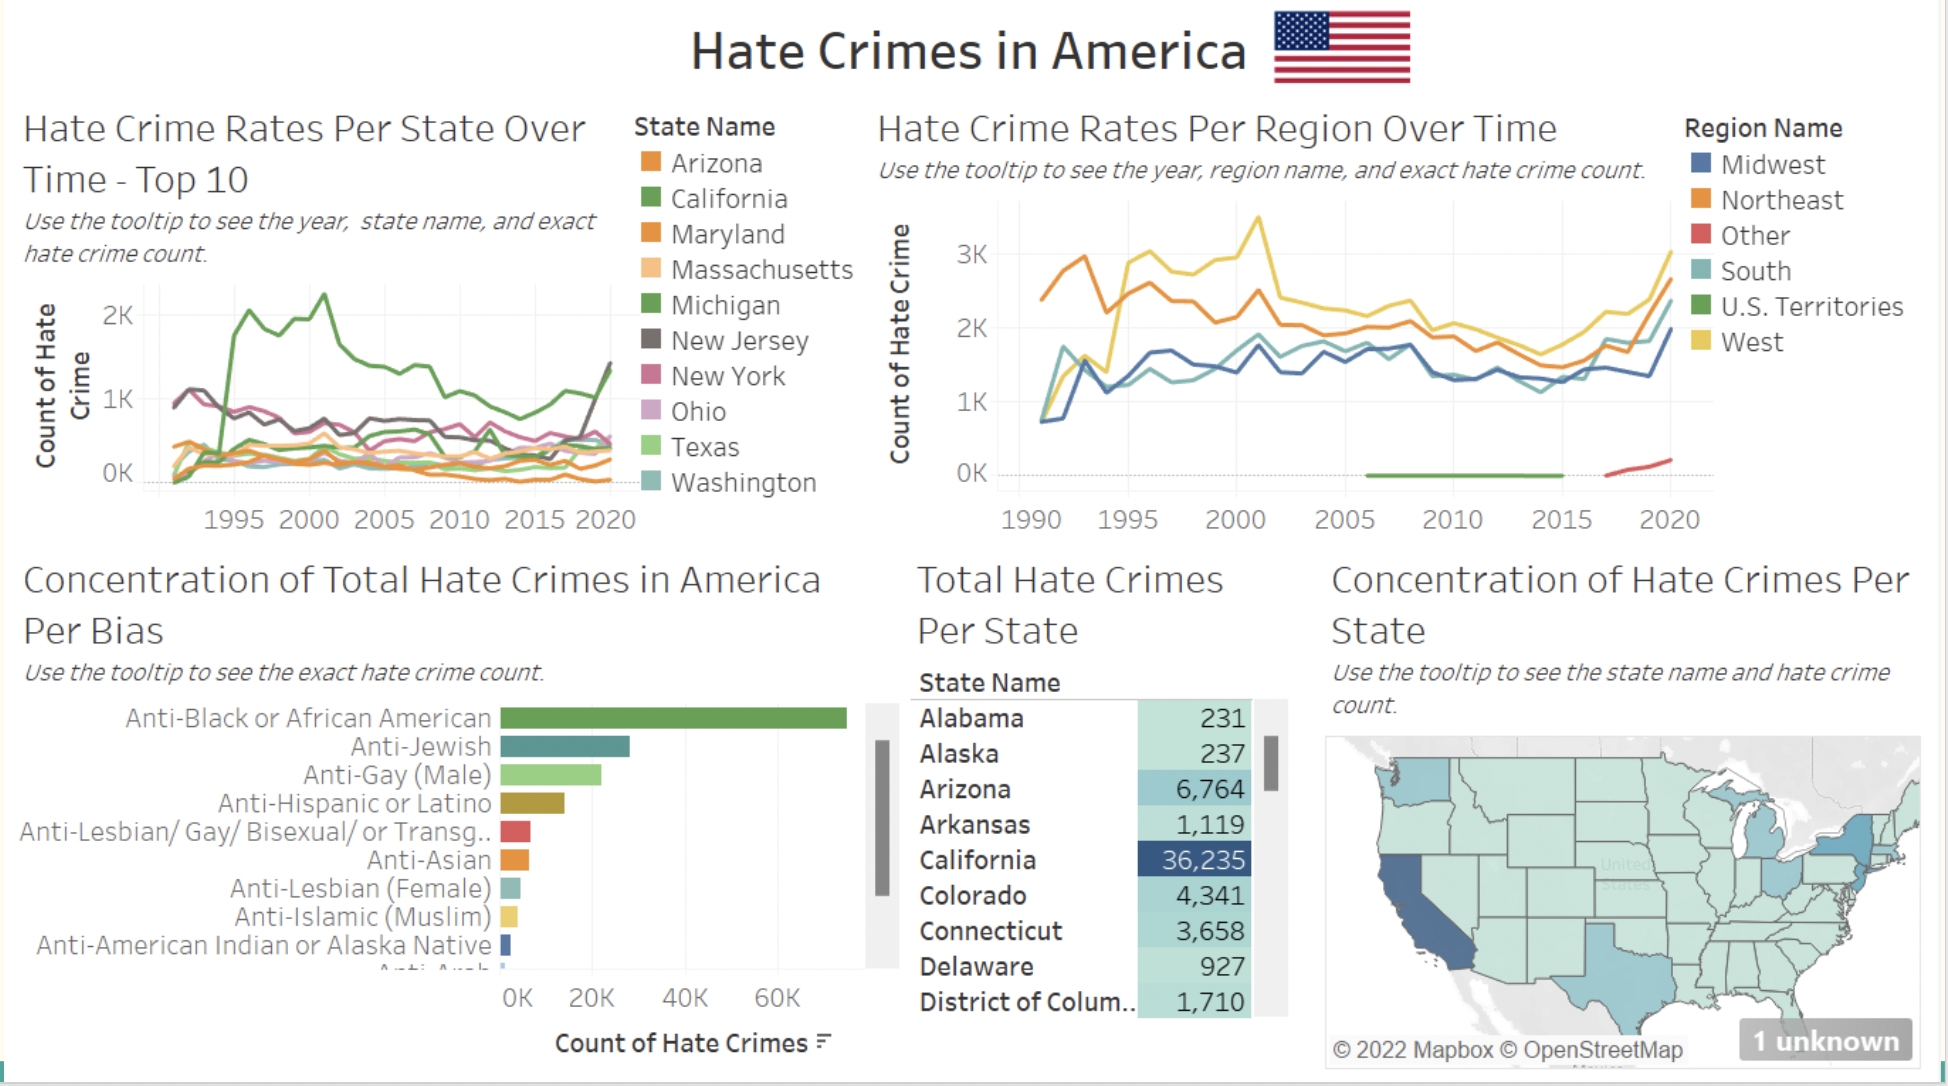

This is a dashboard created in Tableau. There are 5 graphs displayed on this one dashboard. On the top left, there is a display of the ten states with the highest overall count of hate crime over the time of the the dataset we used. It is clear that California definitely seems to have the most hate crimes for the most part, but by 2020, seems to be close to the count of hate crime as with the other states. On the top right, the line graph displayed the count of hate crime with regards to time, colored by region. It is clear that the starting in 1990, the Northeast seems to have the greatest count in hate crime, but starting in 1995, the west seems to take the lead up until 2020 as well. This correlates to the fact that California is in the west. To the bottom left, we can see the concentration of total crimes in American per bias. This is extremely impactful as it is clear that Anti-Black or African American bias is clearly the most popular bias in these incidents - which can suggest to governments on what to focus new laws on. To the bottom middle, there is a highlight table of total hate crimes for every state - the list of numbers along with colors clearly help to quantify the differences among each state - California being the greatest of course, as seen through other graphs on this dashboard as well. Lastly, the map on the bottom right goes along with the highlight table, but shows a more visual representation, where darker states mean more hate crimes. With these graphs, the government can make smart decisions with regards to which areas to focus on. 


In [ ]:
HATE_CRIME_FILE = "hate_crime_modified.csv"

In [ ]:
# seaborn makes your plot look nicer!
sns.set(font_scale = 1.28)

Hate crime rates in general over time

Text(0.5, 0.98, 'Hate Crimes in the United States Over Time')

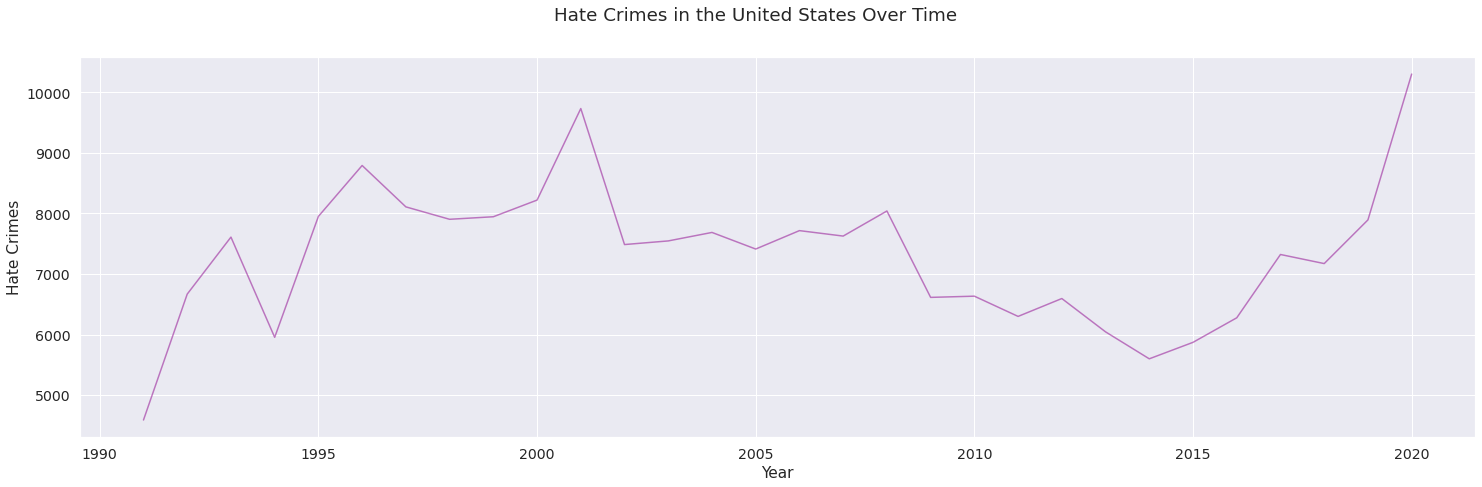

In [ ]:
year_col = 'DATA_YEAR'
years = []
hate_crimes_lst = []
annual_attacks = defaultdict(lambda: 0)

incidents = csv_to_dicts(HATE_CRIME_FILE)
attack_years = get_attack_years(incidents)

for year in attack_years:

  # Calculates the number of hate crimes over time in the United States 
  for incident in incidents:
    for key, value in incident.items():
      if key == year_col and value == year:
            annual_attacks[year] += 1

for year, hate_crimes in annual_attacks.items():
  years.append(int(year))
  hate_crimes_lst.append(hate_crimes)

plt.plot(years, hate_crimes_lst, color = 'darkmagenta', alpha = .5)

# Labels the line chart and re-sizes it for clarity
plt.gcf().set_size_inches(25, 7)
plt.ylabel('Hate Crimes')
plt.xlabel('Year')
plt.suptitle('Hate Crimes in the United States Over Time')

After increasingly rapidly between 1990 and about 1992-1993, hate crime rates steady declines before spiking again around 1995. Hate crimes rates remained stagnant until experiencing another spike after 2000. Hate crime rates then experienced a dramatic drop and steadily declines before rapidly increasing after 2015. Even though the United States was able to manage hate crime rates momentarily, they are rapidly on the rise again. This concerning piece of information suggests that initiatives implemented to address hate crimes in the past are becoming outdated as America is an encompassing a stringer environment of hate between individuals. Organizations aimed at reducing hate crimes need to evaluate which actions done by the United States to combat hate crimes have been helpful or not to devise a better solution that can allow hate crimes rates to decrease again.

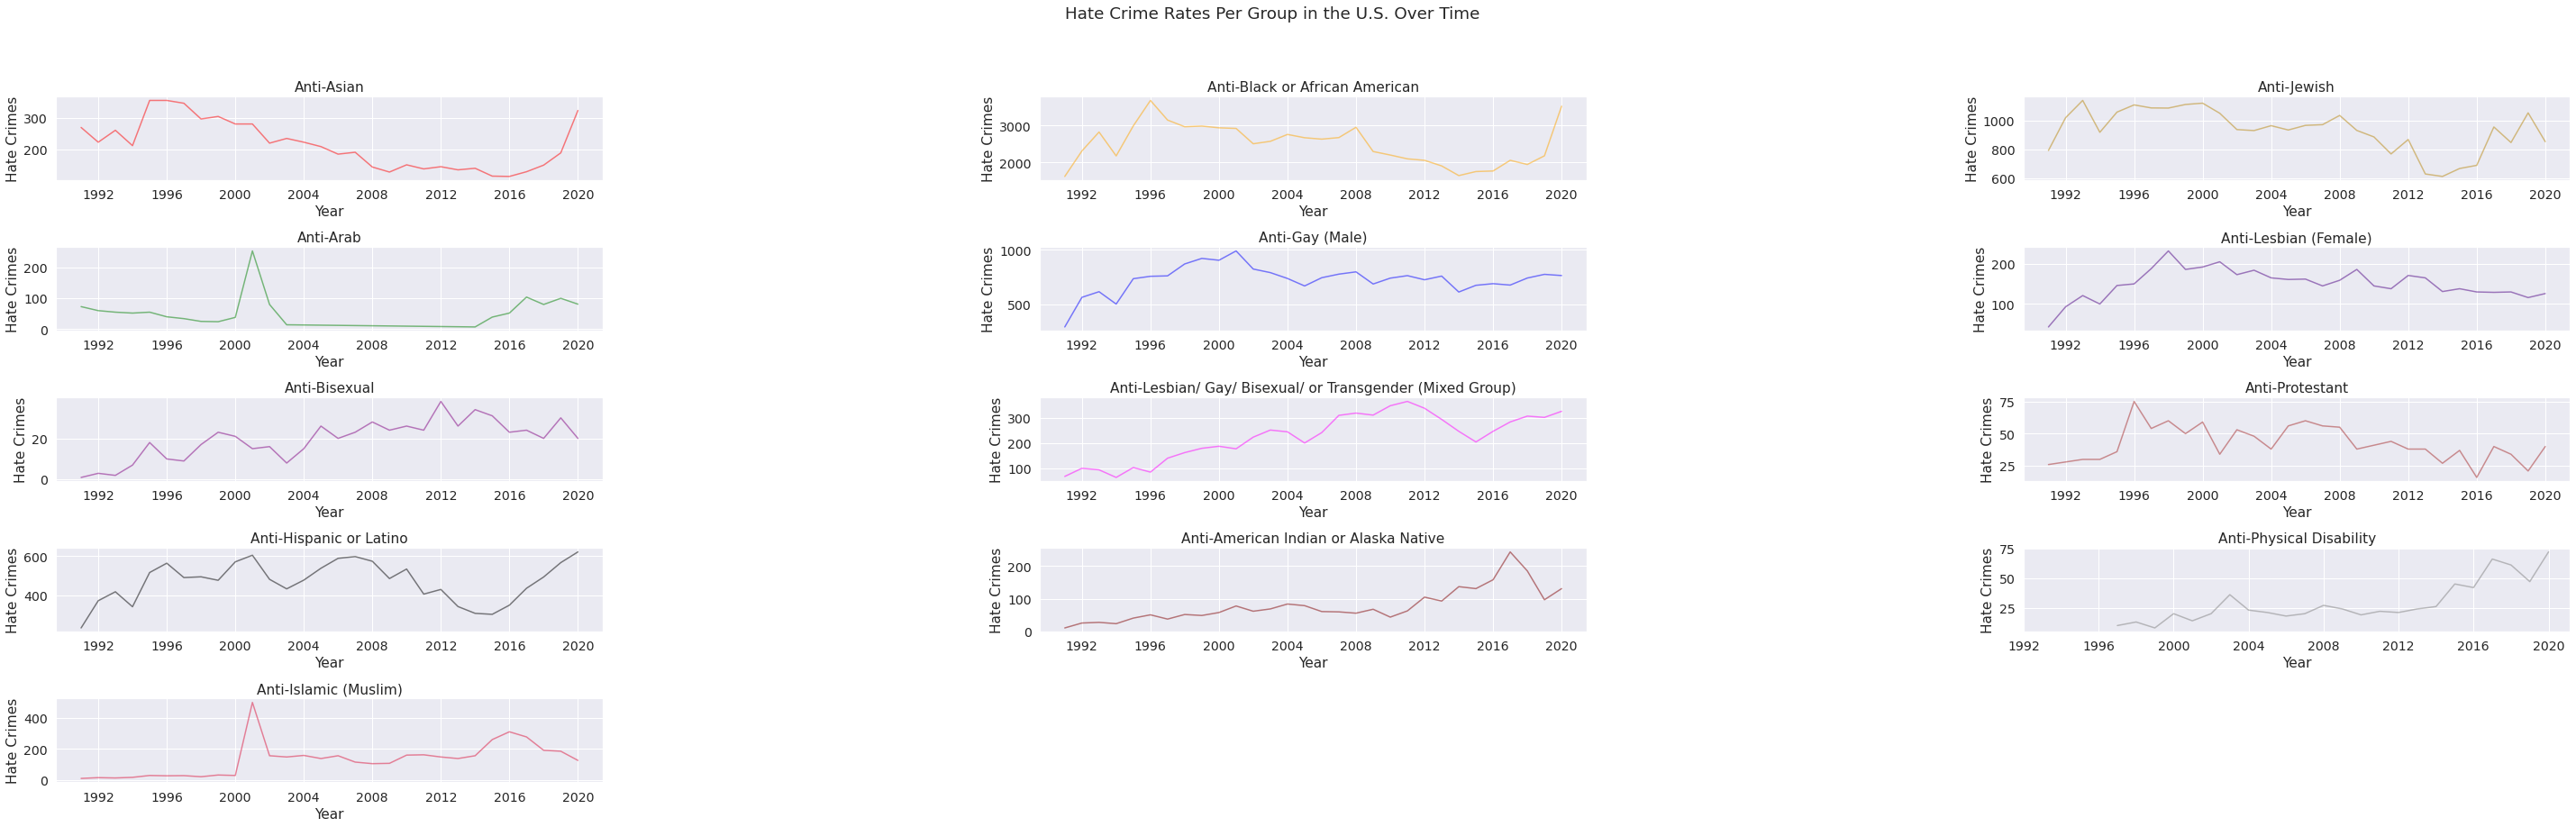

In [ ]:
year_col = 'DATA_YEAR'
bias_col = 'BIAS_DESC'
colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 'purple', 
          'fuchsia', 'brown', 'black', 'maroon', 'gray', 'crimson']

# a list of the biases we are concerned about
biases = ['Anti-Asian', 'Anti-Black or African American', 'Anti-Jewish', 
          'Anti-Arab', 'Anti-Gay (Male)', 'Anti-Lesbian (Female)', 
          'Anti-Bisexual', 
          'Anti-Lesbian/ Gay/ Bisexual/ or Transgender (Mixed Group)', 
          'Anti-Protestant', 'Anti-Hispanic or Latino', 
          'Anti-American Indian or Alaska Native', 'Anti-Physical Disability',
          'Anti-Islamic (Muslim)']

# Tracks the number of attacks of people of a certain group in one year
for i in range(len(biases)):

  incidents = csv_to_dicts(HATE_CRIME_FILE)

  # Cleans the hate crime data to only include hate crime incidents with the
  # offender race of interest
  bias_data = clean_data(incidents, biases[i], bias_col)

  bias_counts = defaultdict(lambda: 0)
  
  for incident in bias_data:
    for key, value in incident.items():
      if key == bias_col and value == 1:
          bias_counts[incident[year_col]] += 1
  years = [int(year) for year in bias_counts.keys()]
  counts = [count for count in bias_counts.values()]

  # Creates subplots for the number of attacks that a hate crime group received
  # over time

  plt.subplot(5, 3, i + 1)
  plt.plot(years, counts, color = colors[i], alpha = 0.5)
  plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
  plt.xlabel("Year")
  plt.ylabel("Hate Crimes")

  # Each subplot is labeled based on the bias they are representing
  plt.gca().title.set_text(biases[i])

# Gives the plot a title
plt.suptitle('Hate Crime Rates Per Group in the U.S. Over Time')

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(50, 14)

# adjusts spacing between graphs
plt.subplots_adjust(wspace=.8, hspace=.8)

Nearly all of the subplots display a recent spike in hate crimes. Specifically, hate crimes involving anti-Asian, anti-Black or African American, anti-Hispanic or Latino, and anti-Physical Disability sentiments increased dramatically after 2016. The y axes of the subplots reveal that Blacks and African Americans receive disproportionately more hate crimes than people represented in the other sub-plots. The 2001 spike in Anti-Arab and Anti-Islamic (Muslim) cases are likely attributed to the Anti-Arab sentiments that came after the attack on the Twin Towers on September 11, 2001. These statistics prove that hate crimes are an ongoing issue that require more work to truly get abolished in the United States.

Bias vs. state

Text(0.5, 0.98, 'Trends for Incident Biases in 25 States')

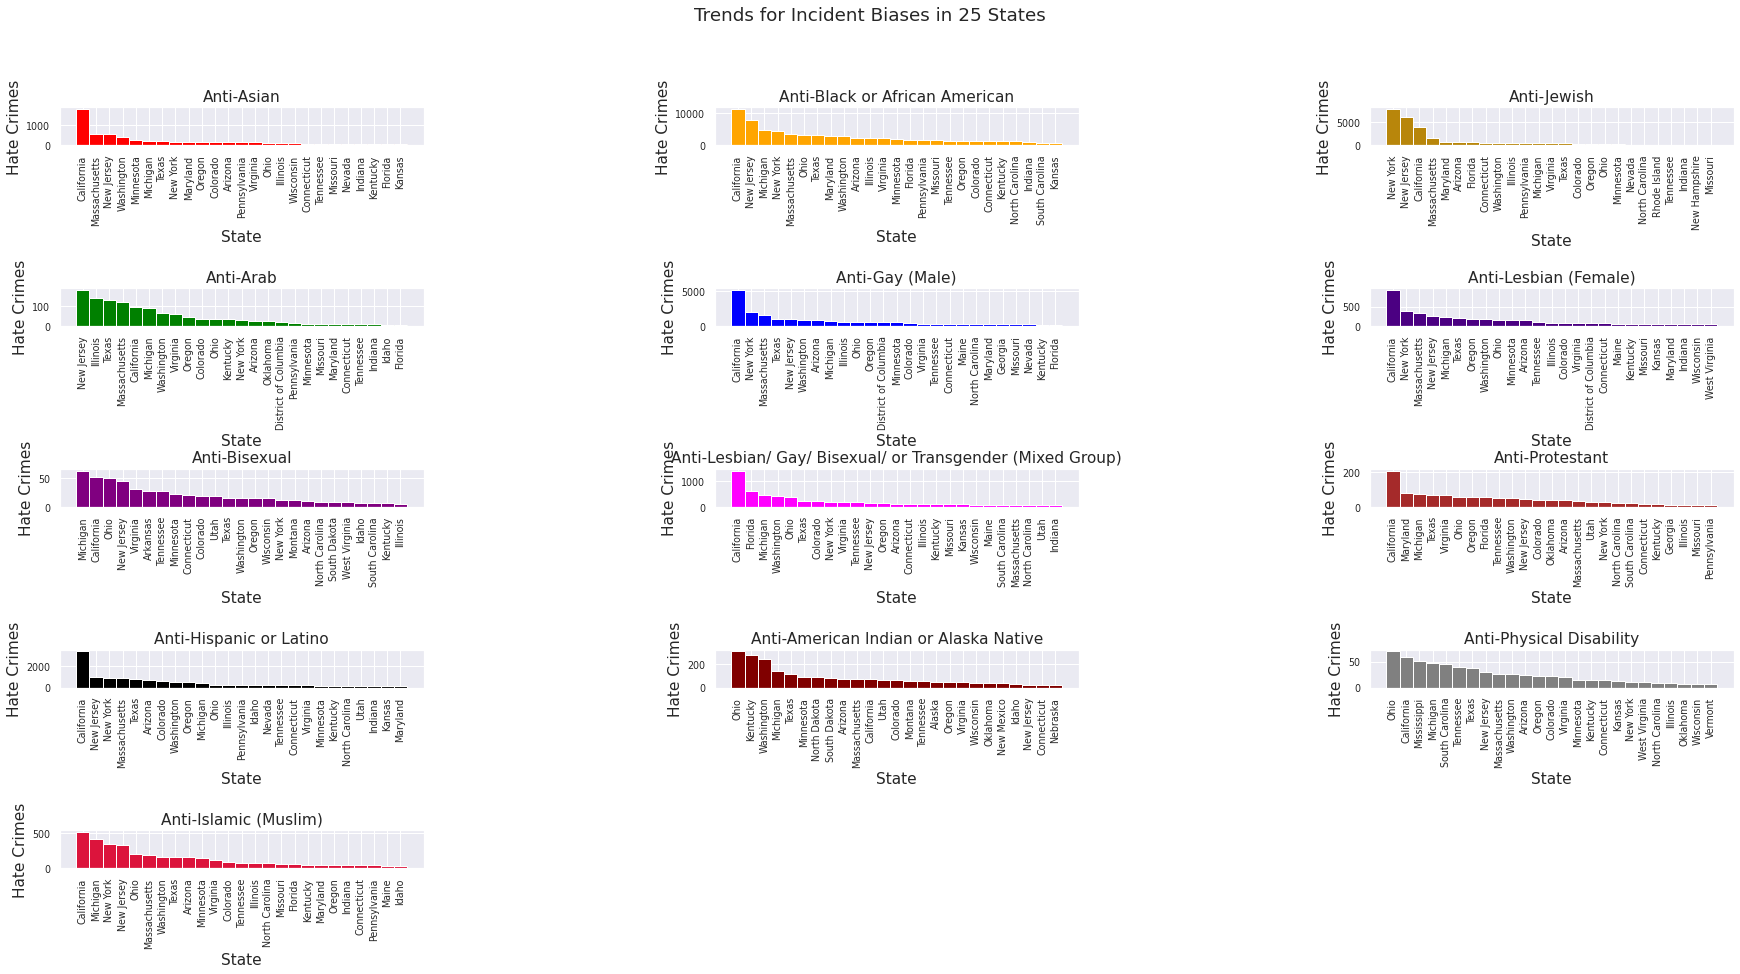

In [ ]:
bias_col = 'BIAS_DESC'
state_col = 'STATE_NAME'
colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 'purple', 
          'fuchsia', 'brown', 'black', 'maroon', 'gray', 'crimson']

# a list of the biases we are concerned about
biases = ['Anti-Asian', 'Anti-Black or African American', 'Anti-Jewish', 
          'Anti-Arab', 'Anti-Gay (Male)', 'Anti-Lesbian (Female)', 
          'Anti-Bisexual', 
          'Anti-Lesbian/ Gay/ Bisexual/ or Transgender (Mixed Group)', 
          'Anti-Protestant', 'Anti-Hispanic or Latino', 
          'Anti-American Indian or Alaska Native', 'Anti-Physical Disability',
          'Anti-Islamic (Muslim)']

# Creates a bar chart representing the frequency of offender ethnicities in 25 
# states with the most incidents with offenders of that race
stat_per_state(stat_col = bias_col, stat_list = biases, subplot_rows = 5, 
               subplot_columns = 3, colors = colors)

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(30, 14)

# adjusts spacing between graphs
plt.subplots_adjust(wspace=.8, hspace=3.75)

# Adds an overarching title to the graph
plt.suptitle('Trends for Incident Biases in 25 States')

Interestingly, California appears to mostly host the most hate crimes of a certain bias no matter the bias. Of the bias types we analyzed, California has the most anti-Asian, anti-Black or African American, anti-gay, anti-lesbian, anti-lesbian/gay/bisexual/transgender, anti-Protestant, and anti-Hispanic or Latino related hate crimes. This finding suggests that most protocol aimed at reducing hate crimes should be geared toward California. Other states that consistently appear in these graphs for the top 25 states with hate crimes of a certain group, including New Jersey, New York, and Massachussets, should also be prioritized with services to alleviate the situations of people subjected to hate crimes. The following list gives a specific run down for the top 5 states (from most hate crime heavy to least hate crime heavy) that experience hate crimes of a certain bias. We hope that people pay more attention to these states when trying to tackle hate crimes pertaining to people of a certain category. Furthermore, people may want to avoid residing in a state within the list of the top 5 states that experience hate crimes of a group they are a part of for their own safety and wellbeing:

- **Anti-Asian**: California, Massachusetts, New Jersey, Washington, Minnesota
- **Anti-Black or African American**: California, New Jersey, Michigan, New York, Massachusetts
- **Anti-Jewish**: New York, New Jersey, California, Massachusetts, Maryland
- **Anti-Arab**: New Jersey, Illinois, Texas, Massachusetts, California
- **Anti-Gay (Male)**: California, New York, Massachusetts, Texas, New Jersey
- **Anti-Lesbian (Female)**: California, New York, Massachusetts, New Jersey, Michigan
- **Anti-Bisexual**: Michigan, California, Ohio, New Jersey, Virginia
- **Anti-Lesbian/Gay/Bisexual/Transgender**: California, Florida, Michigan, Washington, Ohio
- **Anti-Protestant**: California, Maryland, Michigan, Texas, Virginia
- **Anti-Hispanic or Latino**: California, New Jersey, New York, Massachusetts, Texas
- **Anti-American Indian or Alaskan Native**: Ohio, Kentucky, Washington, Michigan, Texas
- **Anti-Physical Disability**: Ohio, California, Mississippi, Michigan, South Carolina
- **Anti-Islamic (Muslim)**: California, Michigan, New York, New Jersey, Ohio

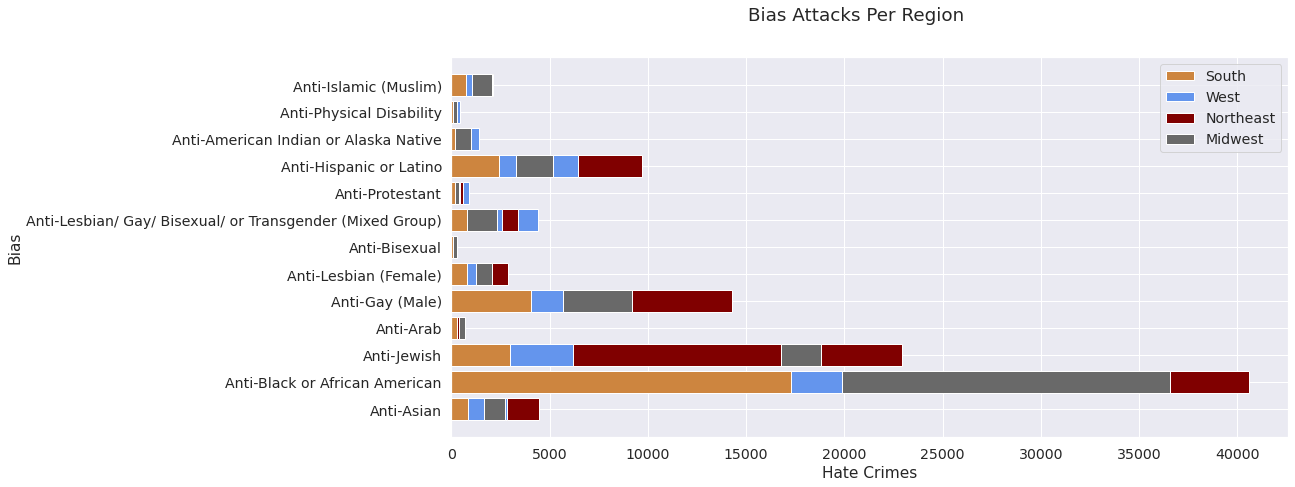

In [ ]:
region_col = 'REGION_NAME'
bias_col = 'BIAS_DESC'

# a list of the regions we are concerned about
regions = ['South', 'West', 'Northeast', 'Midwest']

# a list of the biases we are concerned about
biases = ['Anti-Asian', 'Anti-Black or African American', 'Anti-Jewish', 
          'Anti-Arab', 'Anti-Gay (Male)', 'Anti-Lesbian (Female)', 
          'Anti-Bisexual', 
          'Anti-Lesbian/ Gay/ Bisexual/ or Transgender (Mixed Group)', 
          'Anti-Protestant', 'Anti-Hispanic or Latino', 
          'Anti-American Indian or Alaska Native', 'Anti-Physical Disability',
          'Anti-Islamic (Muslim)']

colors = ['peru', 'cornflowerblue', 'maroon', 'dimgrey']

for i in range(len(biases)):

  region = []
  region_value = []

  bias_data = csv_to_dicts(HATE_CRIME_FILE)
  clean_data(bias_data, biases[i], bias_col)
  region_attacks = defaultdict(lambda: 0)

  for incident in bias_data:
    for key, value in incident.items():
      if key == region_col and value in regions:
        region_attacks[value] += incident[bias_col]

  for key, value in region_attacks.items():
    region.append(key)
    region_value.append(value)

  for j in range(len(region)):
    if j == 0:
      plt.barh(biases[i], region_value[j], label = region[j], color = colors[j])
    else:
      plt.barh(biases[i], region_value[j], left = region_value[j - 1], 
               label = region[j], color = colors[j])
      
# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

# Gives the plot a title and axes labels
plt.suptitle('Bias Attacks Per Region')
plt.ylabel ('Bias')
plt.xlabel ('Hate Crimes')

# Adds a legend to the plot
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

These stacked bar charts provide information about the concentration of hate crimes toward a certain group in each area of the United States. This information indicates what parts of the United States should be brought to greater attention when addressing hate incidents of a certain group. Furthermore, Americans wanting to feel safe can move to a part of the country where attacks against people of their kind are smaller relative to other parts of the country. Interestingly, it seems that hate crimes toward a particular group are generally equally distributed throughout the country. Still, Anti-Islamic crimes are concentrated in the South and Midwest. Anti-American Indian or Alaskan Native attacks mostly occur in the Midwest. Anti-gay (male) attacks are not as prevalent in the West compared to other regions. Anti-Jewish attacks are most common in the Northeast. Anti-Black or African American attacks are most common in the South and Midwest.

Hate crimes per group overall

Text(0, 0.5, 'Count')

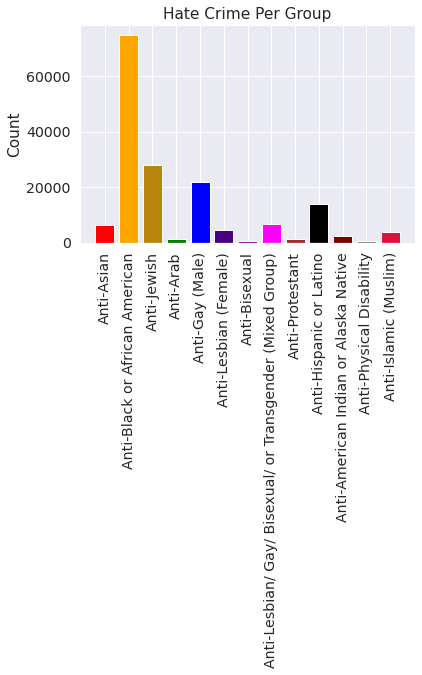

In [ ]:
# a list of the biases we are concerned about
biases = ['Anti-Asian', 'Anti-Black or African American', 'Anti-Jewish', 
          'Anti-Arab', 'Anti-Gay (Male)', 'Anti-Lesbian (Female)', 
          'Anti-Bisexual', 
          'Anti-Lesbian/ Gay/ Bisexual/ or Transgender (Mixed Group)', 
          'Anti-Protestant', 'Anti-Hispanic or Latino', 
          'Anti-American Indian or Alaska Native', 'Anti-Physical Disability',
          'Anti-Islamic (Muslim)']

bias_col = 'BIAS_DESC'
colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 'purple', 
          'fuchsia', 'brown', 'black', 'maroon', 'gray', 'crimson']

bias_dict = dict()
for i in biases:
    bias_dict[i] = 0 

incidents = csv_to_dicts(HATE_CRIME_FILE)

# Tracks the number of attacks of people for each bias 
for incident in incidents:
  for key, value in incident.items():
        if key == bias_col and value in biases:
            bias_dict[incident[bias_col]] += 1 


bias_name = list(bias_dict.keys())
bias_freq = list(bias_dict.values())
# Create bar plot for number of attacks that a hate crime group received overall
plt.bar(bias_name, bias_freq, label=bias_name, color = colors)

plt.xticks(rotation=90)
# plt.legend(bias_name, loc='upper right', prop={'size': 8})
plt.title('Hate Crime Per Group')
plt.ylabel('Count')

A hate crime toward any group is a worrying occurance. Yet, there are currently a greater and troubling number of hate crimes toward black or African American individuals compared to hate crimes toward people in other categories. Blacks and African Americans should therefore be prioritized with better services, laws, and other resources that would help them become safer from harm within the country. A lot of people crticize the Black Lives Matter and believe that we should be focusing on promoting a safer environment for all Americans, not just Black Americans. Yet, our data clearly justifies why Black people deserve greater attention in America's mission toward promoting equality.

**Organizations to assist victims of hate crimes**:
- **Southern Poverty Law Center**: https://www.splcenter.org/what-we-do
- **Safe Horizon**: https://www.safehorizon.org/programs/help-hate-crime-victims/
- **The United States Department of Justice**: https://www.justice.gov/hatecrimes
- **Victim Connect**: https://victimconnect.org/learn/types-of-crime/hate-crimes/
https://www.ceousa.org/ 

**AAPI assistance organizations**

- **Stop Asian Hate**: https://stopaapihate.org/ 
- **Asian Americans Advancing Justice**: https://www.advancingjustice-aajc.org/ 
- **Asian American Federation**: https://www.aafederation.org/ 
- **AAPI Women Lead**: https://www.imreadymovement.org/ 
- **Asian Pacific American Legal Center of Southern California (APALC)**: https://www.ajsocal.org/ 
-Committee Against Anti-Asian Violence (CAAAV) https://caaav.org/ 


**Black assistance organizations**

- **National Association for the Advancement of Colored People (NAACP)**: https://naacp.org/ 
- **National Urban League**: https://nul.org/ 
- **Black Lives Matter**: https://blacklivesmatter.com/
- **The Trayvon Martin Foundation**: https://trayvonmartinfoundation.org/
- **Blackout for Human Rights**: http://www.blackoutforhumanrights.co/

**Jew assistance organizations**

- **American Jewish Committee (AJC)**: https://www.ajc.org/ 
- **Anti-Defamation League**: https://www.adl.org/ 
- **National Conference of Christians and Jews (NCCJ)**: https://www.nccj.org/about/our-story 
- **Detroit Justice for Jews**: https://www.detroitjewsforjustice.org/donate
- **Jewish Council on Urban Affairs (JCUA)**: https://secure.everyaction.com/9m_WTIiOpEO_jylfYUU09A2 
- **Combat Anti-Semitism**: https://combatantisemitism.org/ 

**Arab assistance organizations**

- **American-Arab Anti-Discrimination Committee**: https://www.adc.org/ 
- **Council on American-Islamic Relations**: https://ca.cair.com/losangeles/ 
- **Arab-American Family Support Center**: https://www.aafscny.org/about-us/ 
- **Arab Advice Bureau**: http://www.arabadvicebureau.org.uk/
- **Arab American Action Network**: https://aaan.org/ 

**LGBTQ+ assistance organizations**

- **National Gay and Lesbian Task Force**: (NGLTF) https://www.thetaskforce.org/ 
- **Parents and Friends of Lesbians and Gays (PFLAG)**: https://pflag.org/ 
- **The Trevor Project**: https://www.thetrevorproject.org/
- **Family Equality**: https://www.familyequality.org/ 
- **LGBT Foundation**: https://lgbt.foundation/groups 

**Protestant assistance organizations**

- **The Protestant Christian Support Group (PCSC)**: https://www.pcsg-theprotestantchristiansupportgroup.com/about 

**Hispanic/Latino assistance organizations**

- **Mexican American Legal Defense and Educational Fund (MALDEF)**: https://www.maldef.org/ 
- **National Council of La Raza**: https://www.unidosus.org/ 
- **The Hispanic Institute**: https://www.thehispanicinstitute.net/
- **Latino Victory**: https://latinovictory.org/
- **Voto Latino**: https://votolatino.org/ 

**Native American/Alaskan native assistance organizations**

- **First Nations Development Institute**: https://www.firstnations.org/
- **Stand With Standing Rock**: https://standwithstandingrock.net/donate 
- **Warrior Women**: https://www.warriorwomenfilm.com/
- **Native Wellness**: https://www.instagram.com/nativewellness/?hl=en
- **Native American Rights Fund**: https://secure.narf.org/page/64457/donate/1?_ga=2.215186576.627354145.1601584720-1572519401.1601584720 

**Disability assistance groups**

- **Recovery International**: https://recoveryinternational.org/find-a-meeting/
- **Parent and Caregiver Network**: https://community.dbsalliance.org/
- **Brain Injury Association of America**: https://www.biausa.org/find-bia 
- **Caregiver Action Network**: https://www.caregiveraction.org/ 
- **National Alliance on Mental Illness (NAMI)**: https://nami.org/Home 

**Muslim assistance organizations**

- **Muslim Advocates**: https://muslimadvocates.org/
- **Muslim Public Affairs Council**: https://www.mpac.org/
- **Council on American-Islamic Relations (CAIR)**: https://www.cair.com/
- **Muslims for Progressive Values**: https://www.mpvusa.org/
- **American-Arab Anti-Discrimination Comittee**: https://www.adc.org/ 

Hate crimes per state overall

Text(0, 0.5, 'Count')

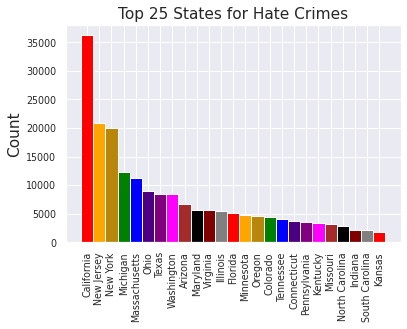

In [ ]:
# Hate crimes per state overall (top 25 because doing all 50 doesn't give a good
# display)
# x-axis states 
# y-axis - frequency of hate crime in the state 
import operator 
colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 'purple', 
          'fuchsia', 'brown', 'black', 'maroon', 'gray']
state_col = 'STATE_NAME'
state_dict = dict()
for incident in incidents:
    for key, value in incident.items():
        if key == state_col:
            if value not in state_dict.keys():
                state_dict[value] = 1 
            else:
                state_dict[value] += 1 

# sort dictionary (cannot use reverse method since this is not python 3.8)
sorted_state_dict = dict(sorted(state_dict.items(), key=operator.itemgetter(1),
                                reverse=True))

state_name = list(sorted_state_dict.keys())
state_freq = list(sorted_state_dict.values())

top_name = state_name[:25]
top_state = state_freq[:25]
plt.bar(top_name, top_state, label=top_name, color=colors, width = 1)
plt.tick_params(labelsize = 9.5)
plt.xticks(rotation=90)
plt.title('Top 25 States for Hate Crimes')
plt.ylabel('Count')


California clearly has had the most hate crimes within the United States from 1991 to 2020. California has about 175% more hate crimes than the state with the second most number of hate crimes, New Jersey. New Jersey, New York, Michigan, and Massachusetts are also concentrated heavily with hate crimes. California's state governors need to evaluate how to best lower the amount of hate crimes in their state. As America keeps diversifying, state governors such as those in California can no longer turn a blind eye to attacks that ruin the harmonious nature of our country's melting pot of diversity. 

Popularity of statutes per state

In [ ]:
STATUTE_FILE = 'state_statute.csv'

In [ ]:
state_statute = csv_to_dicts(STATUTE_FILE)
statute_colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 
                  'purple', 'fuchsia', 'brown', 'black', 'maroon', 'gray', 
                  'darkslategrey', 'darksalmon', 'chocolate', 'yellowgreen', 
                  'indianred', 'aqua', 'midnightblue', 'steelblue', 
                  'palevioletred', 'slateblue', 'saddlebrown', 'burlywood', 
                  'cadetblue', 'crimson', 'hotpink', 'darkorchid', 'blueviolet', 
                  'violet', 'darkolivegreen', 'forestgreen']

Text(0.5, 0.98, 'Popularity of Statutes Across States')

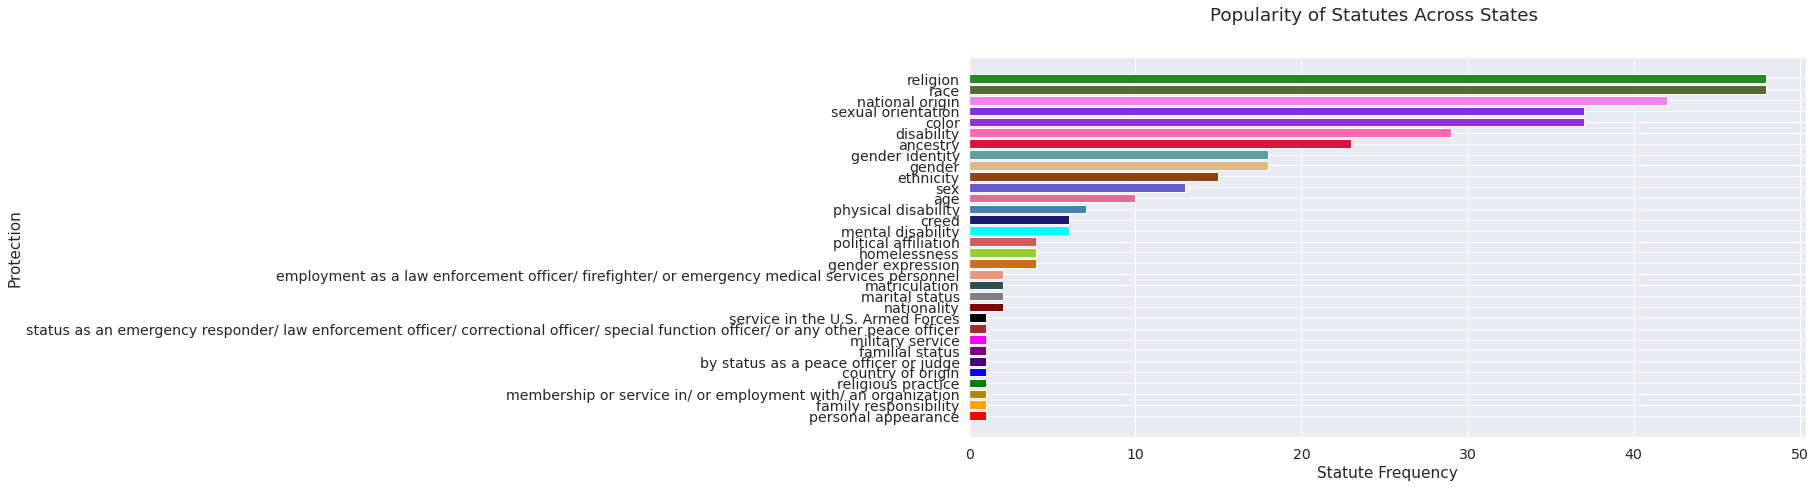

In [ ]:

protection_column = 'protection_name'
statutes = defaultdict(lambda: 0)

# Counts the number of times that a state offers a particular statute
for protection_data in state_statute:
  for key, value in protection_data.items():
    if key == protection_column:
      statutes[value] += 1

# Sorts the data based on the statutes' frequency
statutes = dict(sorted(statutes.items(), key=lambda x:x[1]))

state_statutes = [key for key in statutes.keys()]
statute_counts = [value for value in statutes.values()]

# Plots the frequency of statutes across the United States
plt.barh(state_statutes, statute_counts, color = statute_colors)

# Labels the bar chart and re-sizes it for clarity
plt.gcf().set_size_inches(15, 7)
plt.xlabel('Statute Frequency')
plt.ylabel('Protection')
plt.suptitle('Popularity of Statutes Across States')

The top 5 most popular statutes across the United States offer protection based on religion, race, national origin, sexual orientation, and color. Three states don't offer statutes that protect people from bias-motivated intimidation or harm: Arkansas, South Carolina, and Wyoming. Statutes that make a civil cause of action along to the criminal penalty for similar acts exist in Washington D.C. and 34 states. Statutes mandating the gathering of hate crime statistics are enforced in 30 states and Washington D.C. 20 of those areas include sexual orientation in their data collection findings. Statutes involving gender specifically are present in Washington D.C. and 27 states. Statutes protecting one's gender identity only exist in 18 states. Only Washington D.C. and 3 other states have statutes protecting the homeless.

Juvenille victim counts over time in America and per region

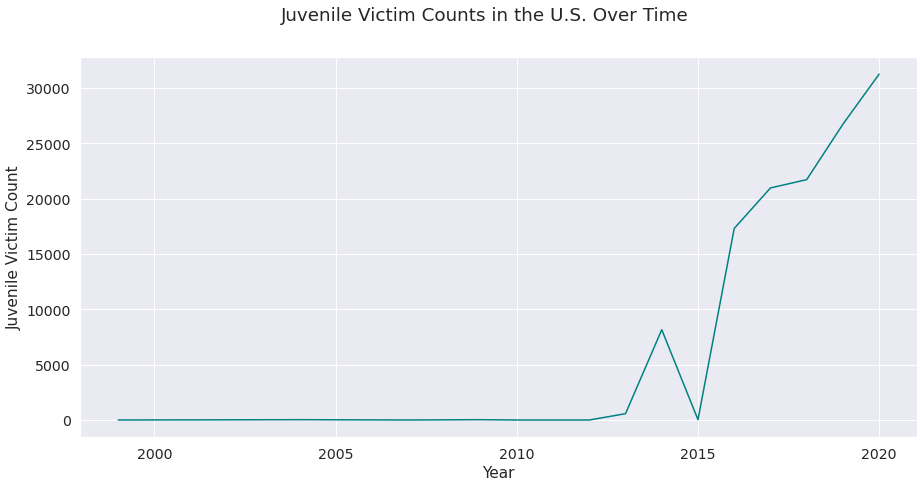

In [ ]:
year_col = 'DATA_YEAR'
juv_vic_col = 'JUVENILE_VICTIM_COUNT'

stat_over_time(juv_vic_col, year_col, 'teal', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Juvenile Victim Counts in the U.S. Over Time')
plt.xlabel("Year")
plt.ylabel("Juvenile Victim Count")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Juvenile Victim Counts Per Region in the U.S. Over Time')

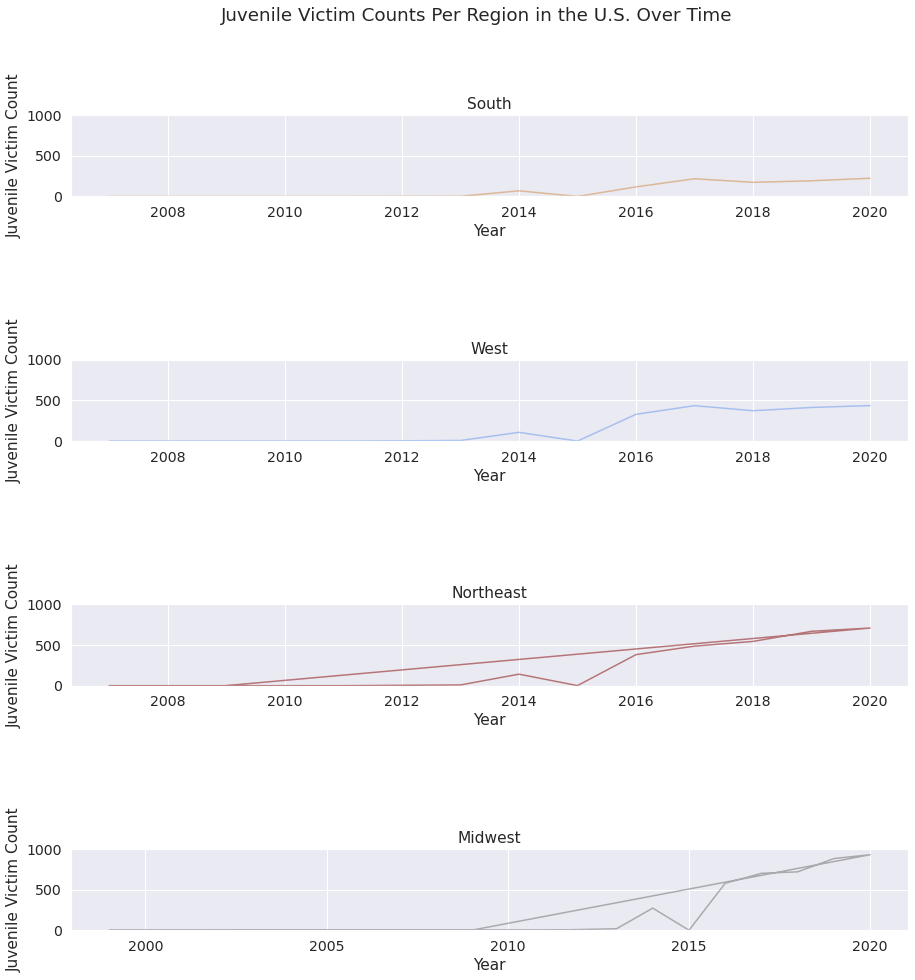

In [ ]:
stat_per_region(juv_vic_col, incidents, 0.5, 'Juvenile Victim Count', (0, 1000))
# Gives the plot a title
plt.suptitle('Juvenile Victim Counts Per Region in the U.S. Over Time')

The Department of Justice defines juveniles as [individuals who are younger than 18](https://www.justice.gov/archives/jm/criminal-resource-manual-38-juvenile-defined). Hence, the number of hate crime victims under 18 rose dramatically after 2015. Juvenile victim counts steeply declined around 2014, but have been growing rapidly ever since. Juvenile victim counts are also increasing in each region of the United States, especially in the Northeast and Midwest. Hence, juvenile protection should be a priority in defining laws to eradicate hate crimes. State governments in the Northeast and Midwest in particular should establish actions that protect people under 18 from hate crime incidents.

Adult victim counts over time in America and per region

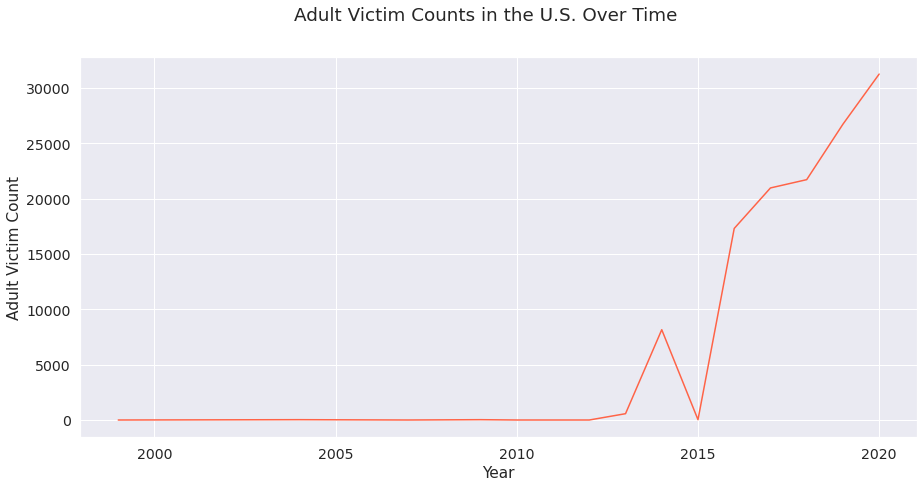

In [ ]:
year_col = 'DATA_YEAR'
adult_vic_col = 'ADULT_VICTIM_COUNT'

stat_over_time(juv_vic_col, year_col, 'tomato', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Adult Victim Counts in the U.S. Over Time')
plt.xlabel("Year")
plt.ylabel("Adult Victim Count")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Adult Victim Counts Per Region in the U.S. Over Time')

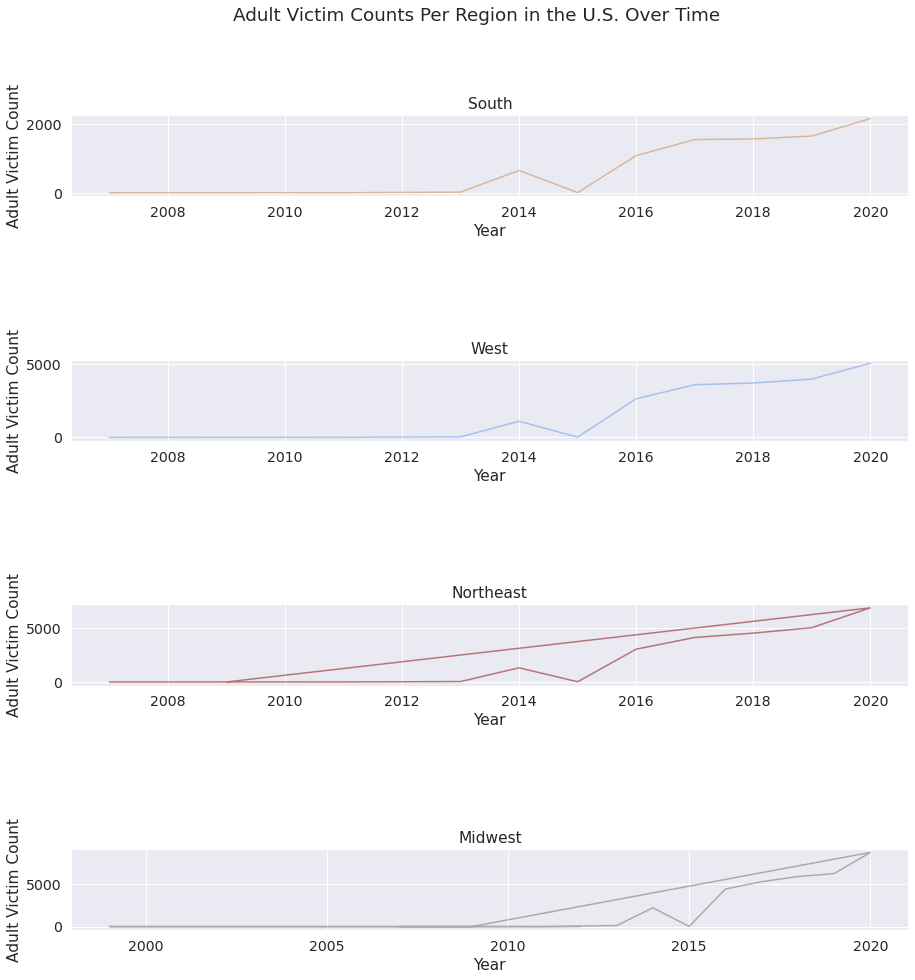

In [ ]:
stat_per_region(adult_vic_col, incidents, 0.5, 'Adult Victim Count')

# Gives the plot a title
plt.suptitle('Adult Victim Counts Per Region in the U.S. Over Time')

Similar to juvenile victim counts, adult victim (people 18+) counts also dramatically declined around 2014 then rose quickly after 2015. Furthermore, adult victim counts appear to be increasing rapidly in all regions of the United States. Conversely, juvenile victim counts recently were increasing steadily in the South and West. The y axis of each region subplot indicates that adult victim counts are a lot lower in the South compared to other regions. Still, protections for adult victims should still be present within all states of America. The truth is that any increase in victim counts, no matter the age, is concerning and should be addressed by those in America that have the power to do so. Any hate crime anywhere is intolerable.

Total offender count over time in America and per region

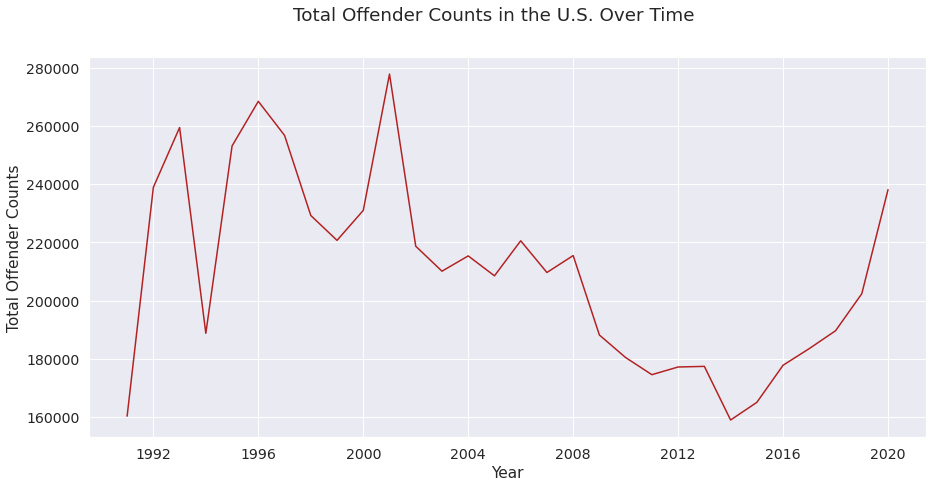

In [ ]:
year_col = 'DATA_YEAR'
total_off_col = 'TOTAL_OFFENDER_COUNT'

# Plots the total offender count over time in America
stat_over_time(total_off_col, year_col, 'firebrick', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Total Offender Counts in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Total Offender Counts")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Total Offender Counts Per Region in the U.S. Over Time')

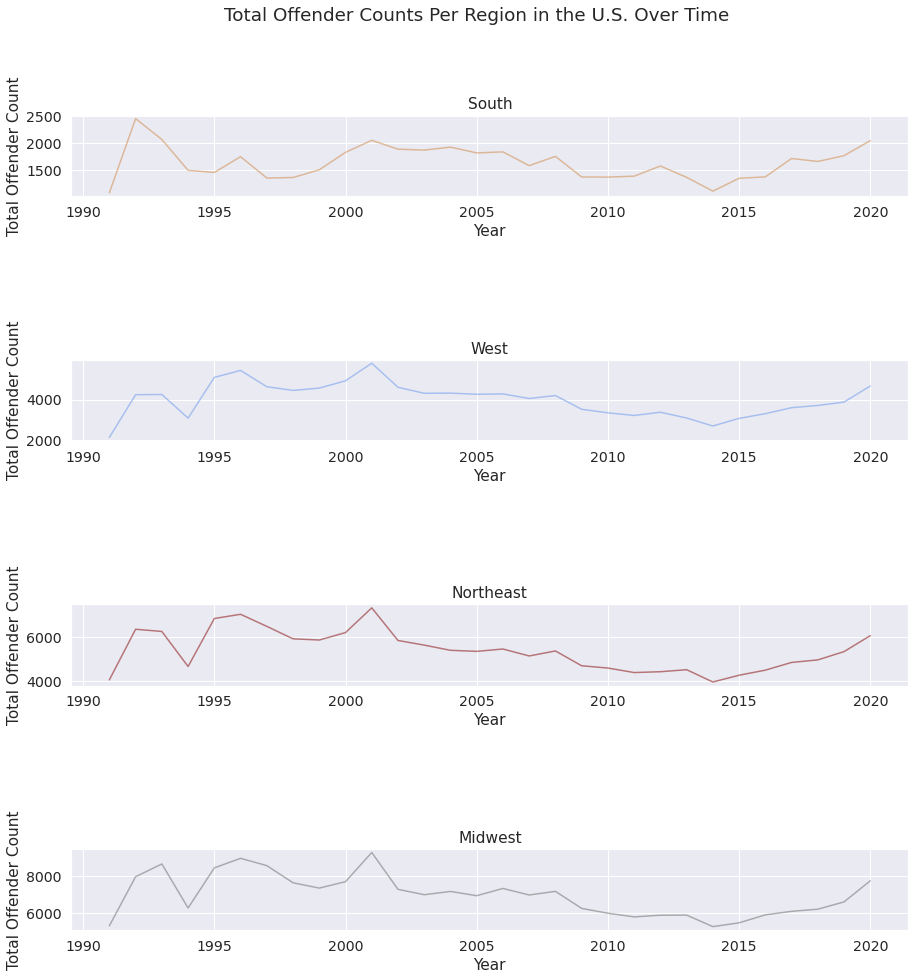

In [ ]:
# Plots the total offender counts over time in each American region
stat_per_region(total_off_col, incidents, 0.5, 'Total Offender Count')

# Gives the plot a title
plt.suptitle('Total Offender Counts Per Region in the U.S. Over Time')

Interestingly, nationwide offender counts seemed to have declined from about 2001 to 2014. Yet, the counts started increasing quickly after 2014. The nationwide trend seems to also be reflected within each region of the United States. Total offender counts, according to the y-axis of each subplot, are the highest in the Midwest and the lowest in the South. There must have been some actions enforced or circumstances occurring between 2001 and 2014 that helped total offender counts to decline during that time. People looking to reduce hate crime rates should observe what those factors could have been to better evaluate how to lower total offender counts in the future.

Adult offender counts over time in America and per region

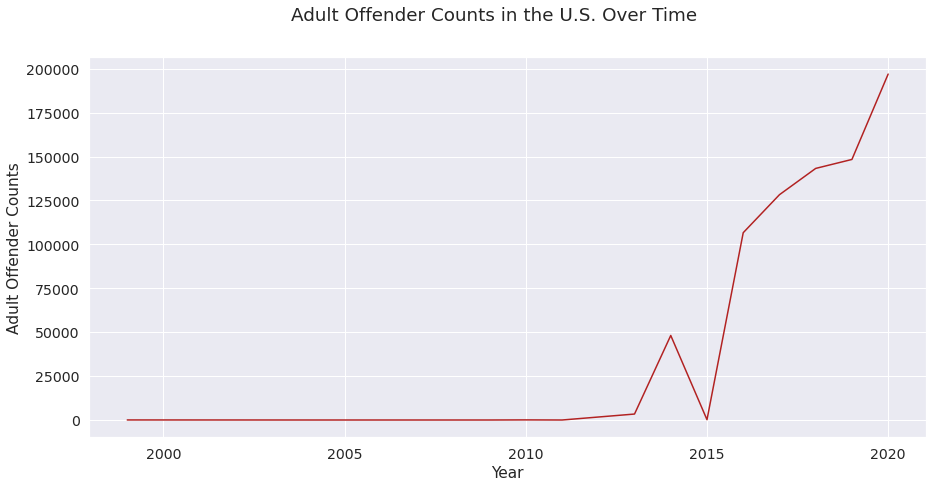

In [ ]:
year_col = 'DATA_YEAR'
adult_off_col = 'ADULT_OFFENDER_COUNT'

# Plots the adult offender count over time in America
stat_over_time(adult_off_col, year_col, 'firebrick', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Adult Offender Counts in the U.S. Over Time')
plt.xlabel("Year")
plt.ylabel("Adult Offender Counts")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Adult Offender Counts Per Region in the U.S. Over Time')

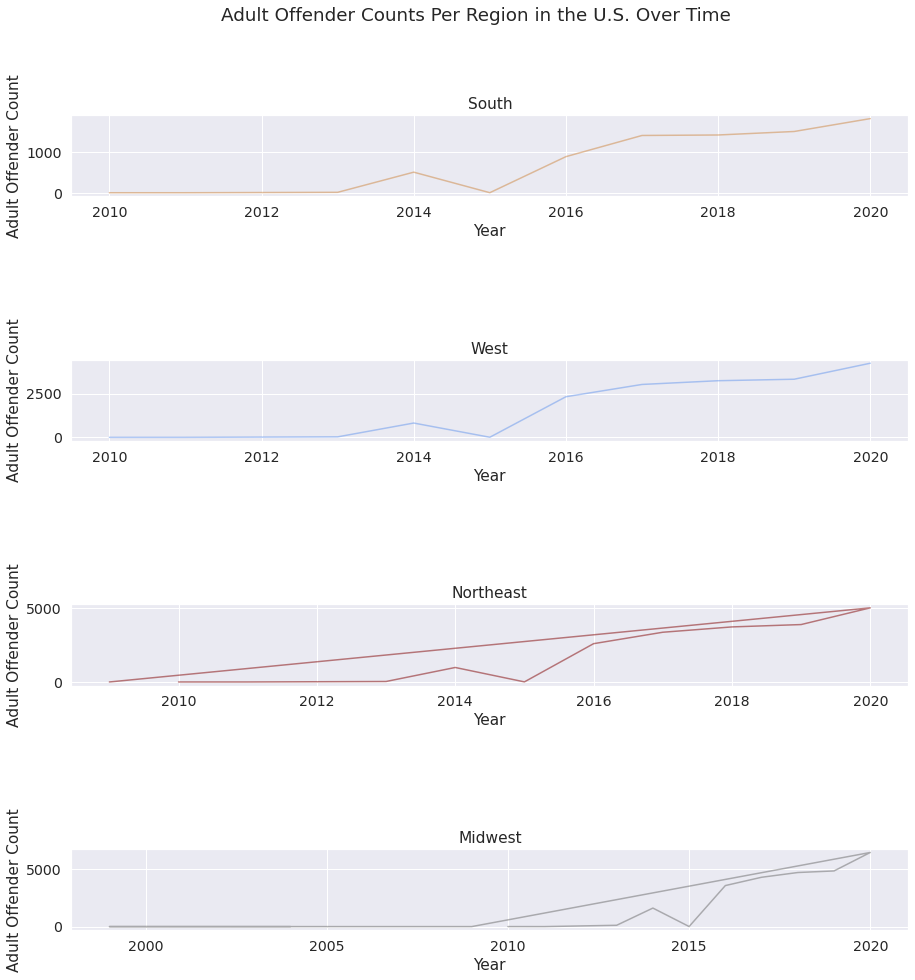

In [ ]:
# Plots the adult offender counts over time in each American region
stat_per_region(adult_off_col, incidents, 0.5, 'Adult Offender Count')

# Gives the plot a title
plt.suptitle('Adult Offender Counts Per Region in the U.S. Over Time')

Unlike total offender counts, adult offender counts didn't experience a dramatic decline from 2001 to 2014. Adult offender counts, after experiencing a brief steep decline in 2014, magnified greatly from 2015 onwards. This nationwide trend is also shared across each region in the United States. Adult offender counts in each region seemed to have increased steadily from 2016 to 2019. Starting at about 2019, adult offender count rates in each region started to rise. Adult offender counts are the highest in the Northeast and Midwest and the lowest in the South, as suggested by the region subplots' y axes.

Juvenile offender count over time in America and per region

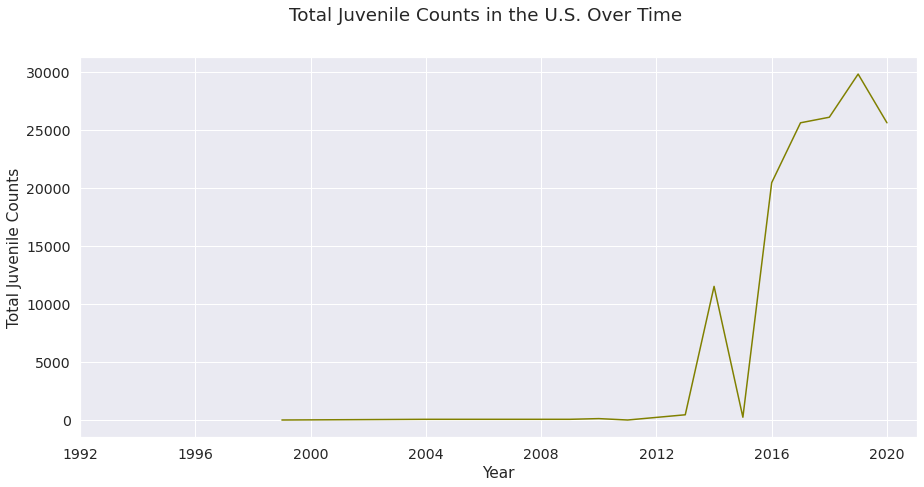

In [ ]:
year_col = 'DATA_YEAR'
juv_off_col = 'JUVENILE_OFFENDER_COUNT'

# Plots the juvenile offender count over time in America
stat_over_time(juv_off_col, year_col, 'olive', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Total Juvenile Counts in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Total Juvenile Counts")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Juvenile Offender Counts Per Region in the U.S. Over Time')

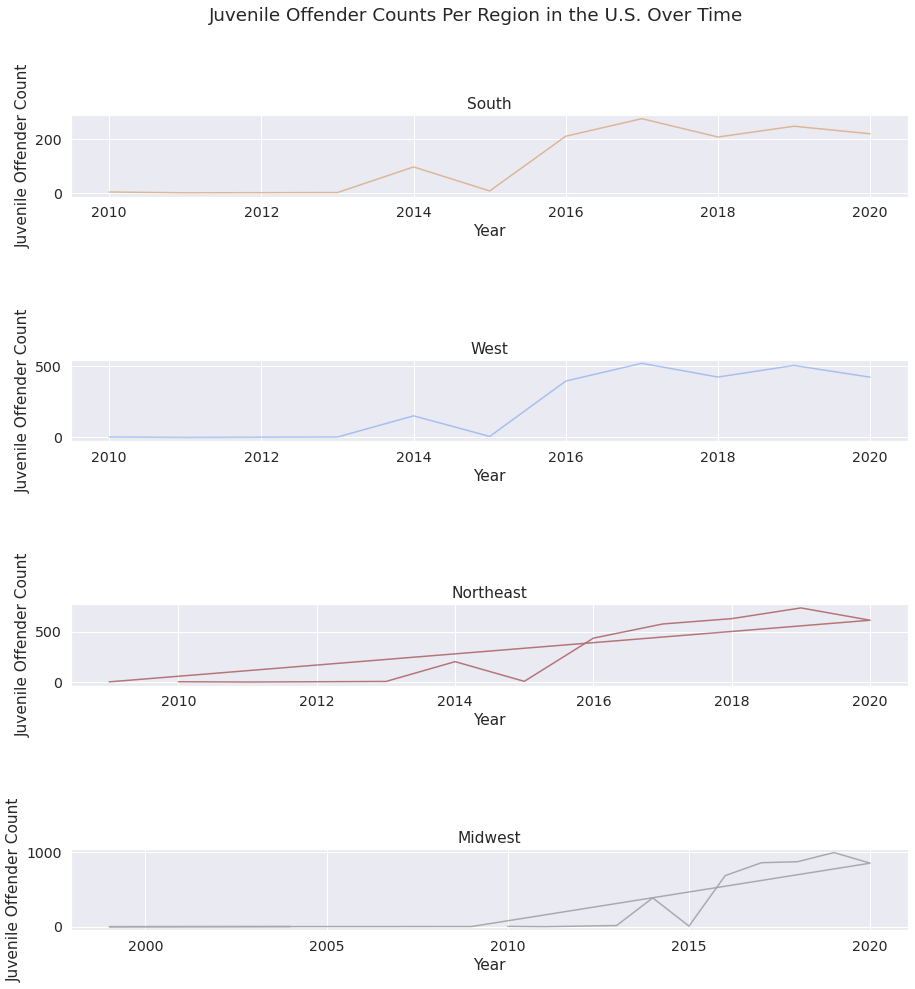

In [ ]:
# Plots the juvenile offender counts over time in each American region
stat_per_region(juv_off_col, incidents, 0.5, 'Juvenile Offender Count')

# Gives the plot a title
plt.suptitle('Juvenile Offender Counts Per Region in the U.S. Over Time')

As with the other features of hate crimes, juvenile offender counts decreased dramatically after 2014 and rose dramatically around 2015 and onwards. This trend is also reflected within each region of the United States. According to the y axis of each subregion plot, juvenille offender counts are the highest in the Midwest and the lowest in the South. The values seemed to have slightly decreased after 2019. Hence, it would be interesting to whether specific actions enforced in 2019 that helped this trend to occur. If so, these actions should be considered for people trying to develop the best ways to give juveniles the resources they need to preclude them from engaging in hate crimes. Still, the number of juvenile offenders in hate crimes is still quite high and should be reduced as much as possible.

Victim count over time in America and per region

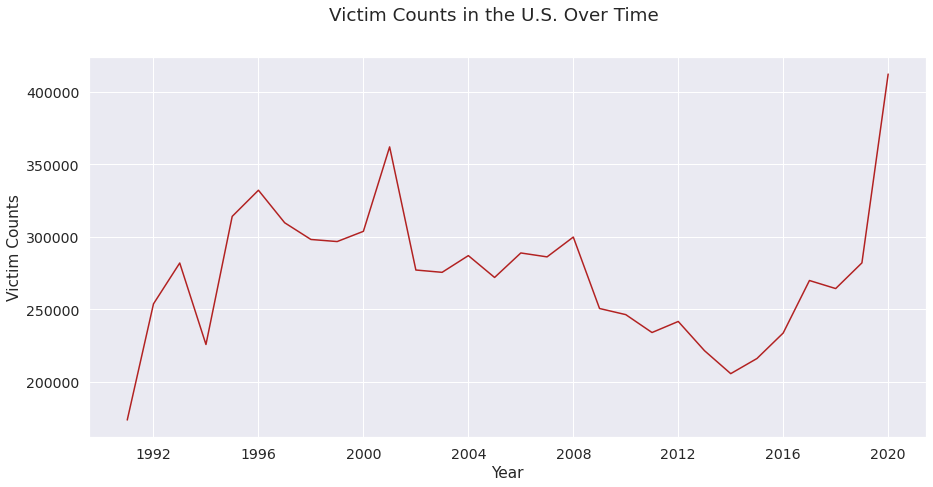

In [ ]:
year_col = 'DATA_YEAR'
victim_col = 'VICTIM_COUNT'

# Plots the victim counts over time in America
stat_over_time(victim_col, year_col, 'firebrick', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Victim Counts in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Victim Counts")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Victim Counts Per Region in the U.S. Over Time')

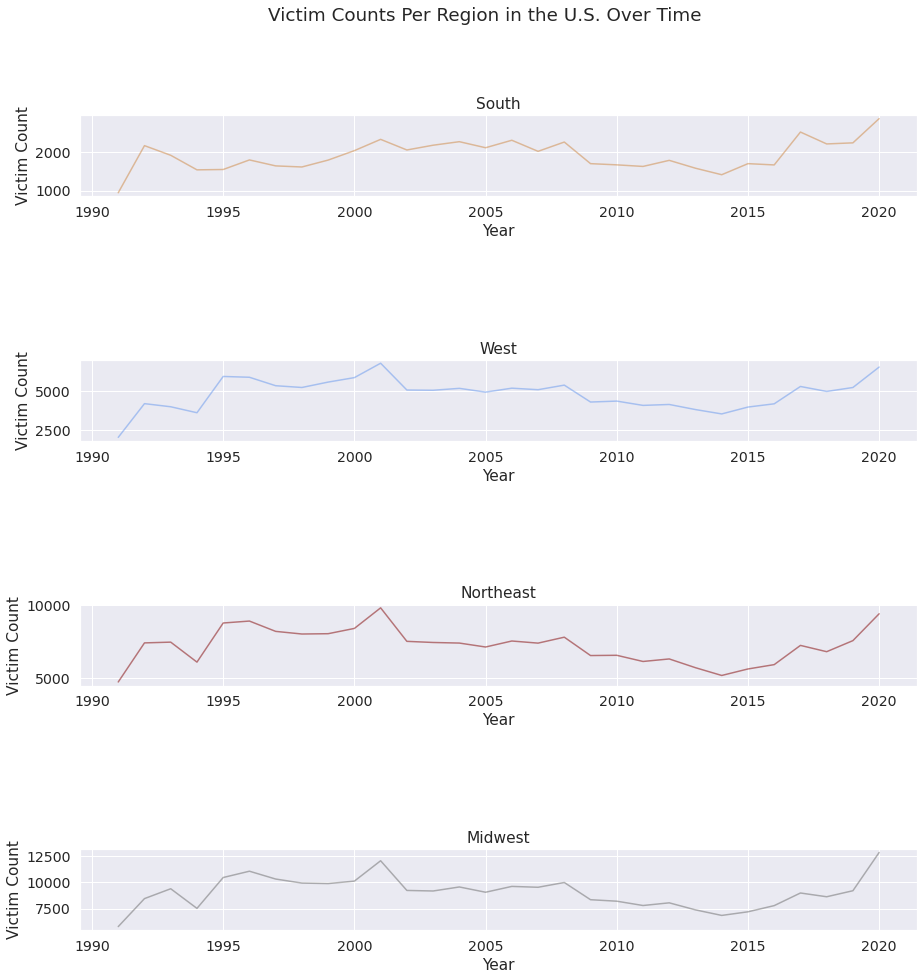

In [ ]:
# Plots the victim counts over time in each American region
stat_per_region(victim_col, incidents, 0.5, 'Victim Count')

# Gives the plot a title
plt.suptitle('Victim Counts Per Region in the U.S. Over Time')

Nationwide victim counts initially rose until about 2001, decreased until about 2014, then increased dramatically onwards. This trend almost appears within each region of the United States. Wthin each region, while nationwide victim counts also steadily increased until 2001, they steadily declined until 2014, steadily increased until about 2019, and then started to increase rapidly. The subplots' y-axes show that these types of attacks are the most popular in the Midwest and the least popular in the South. These graphs tell a story about America. This story suggests that we are entering an era in which agitation over our differences is spreading like wildfire. This fire needs to be tamed to help equitable opportunities and safety become more accessible within our nation.

Total individual victim count over time in America and per region

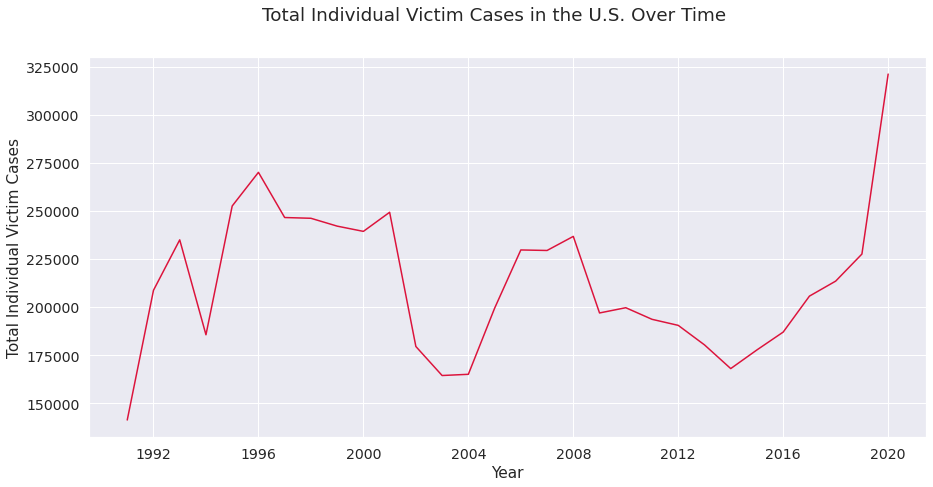

In [ ]:
year_col = 'DATA_YEAR'
total_ind_vic_col = 'TOTAL_INDIVIDUAL_VICTIMS'

# Plots the total individual counts over time in America
stat_over_time(total_ind_vic_col, year_col, 'crimson', 0.5, incidents)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Total Individual Victim Cases in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Total Individual Victim Cases")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Total Individual Victims Cases Per Region in the U.S. Over Time')

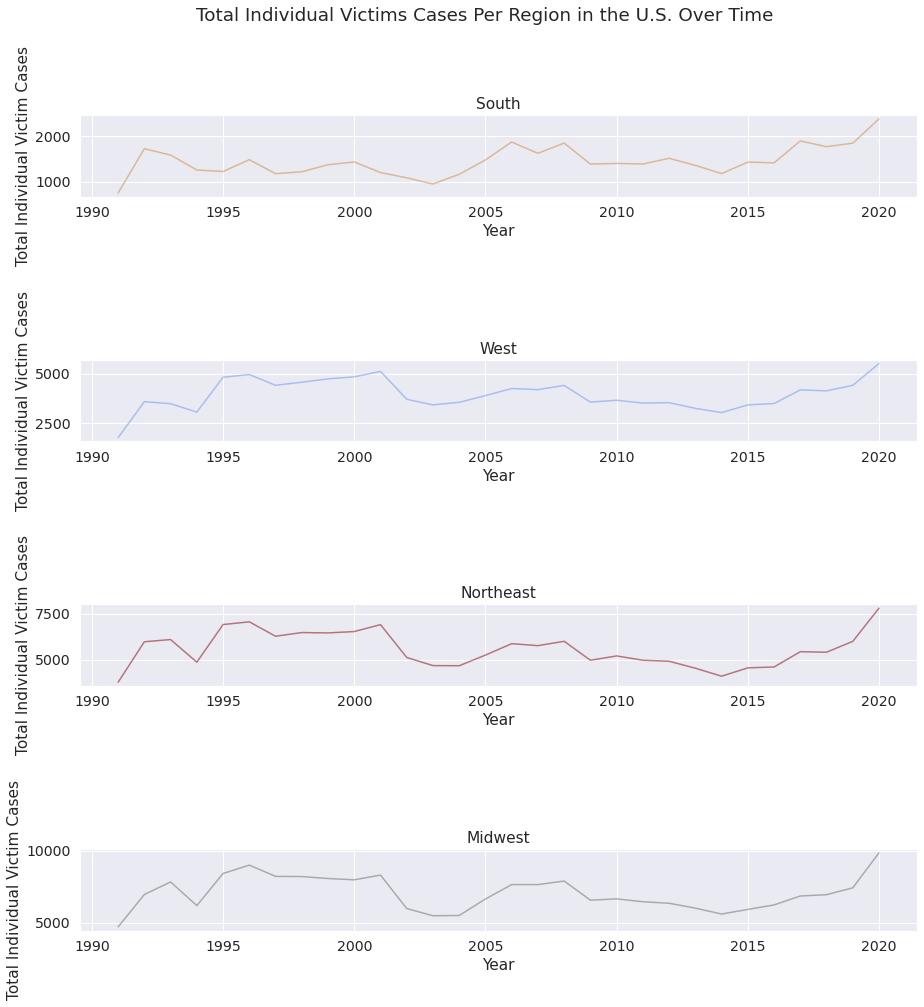

In [ ]:
# Plots the total individual counts over time in each American region
stat_per_region(total_ind_vic_col, incidents, 0.5, 
                'Total Individual Victim Cases')

# Gives the plot a title
plt.suptitle('Total Individual Victims Cases Per Region in the U.S. Over Time')

Nationwide hate crime incidents in which a single victim was targeted increased until about 1996, decreased steadily until 2001 and then dramatically until 2004, rose until 2008, declined steeply until 2014, then increased dramatically afterward. The trend seems relatively inconsistent, but in general, natiowide individual victim cases have risen since 1991. Interestingly, the nationwide trend is also reflected similarly within each region of the United States. Nationwide hate crimes with a single victim are most popular in the Midwest and least popular in the South, as suggested by the y axes of the region subplots. The fact that total individual victim cases have spiked recently suggests that nationwide and state governments need to enforce tactics that would lower the prevalency of those cases as soon as now.

Multiple offense and single offense over time in America and per state

In [ ]:
multiple_off_col = 'MULTIPLE_OFFENSE'
multiple_offenses = csv_to_dicts(HATE_CRIME_FILE)
single_offenses = csv_to_dicts(HATE_CRIME_FILE)

In [ ]:
for offense in multiple_offenses:
  for key, value in offense.items():
    if key == multiple_off_col:
      if value == 'M':
        offense[multiple_off_col] = 1
      else:
        offense[multiple_off_col] = 0

In [ ]:
for offense in single_offenses:
  for key, value in offense.items():
    if key == multiple_off_col:
      if value == 'S':
        offense[multiple_off_col] = 1
      else:
        offense[multiple_off_col] = 0

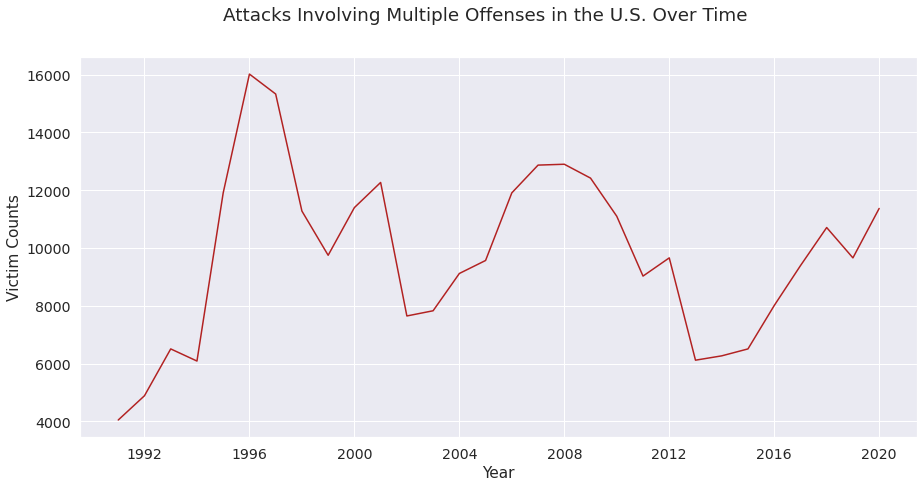

In [ ]:
# Plots the number of multiple offense cases per year 

year_col = 'DATA_YEAR'
mult_off_col = 'MULTIPLE_OFFENSE'

# Plots the victim counts over time in America
stat_over_time(mult_off_col, year_col, 'firebrick', 0.5, multiple_offenses)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Attacks Involving Multiple Offenses in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Victim Counts")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Multiple Offenses in the U.S. Over Time')

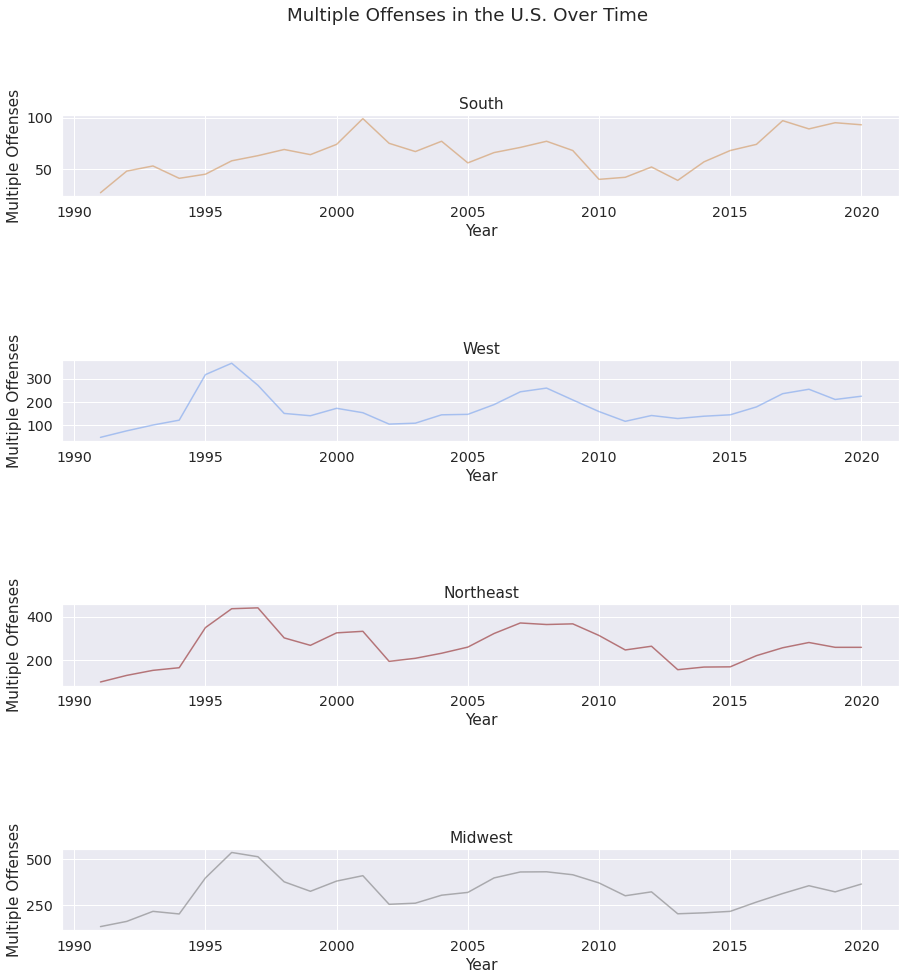

In [ ]:
# Plots the number of multiple offenses over time in each American region
stat_per_region(multiple_off_col, multiple_offenses, 0.5, 'Multiple Offenses')

# Gives the plot a title
plt.suptitle('Multiple Offenses in the U.S. Over Time')

Nationwide attacks involving multiple offenses peaked in 1996 and decreased until about 2002. They then increased again until 2008, decreased until about 2014, and have started to increase again recently. This trend is reflected in each region except the South. In the South, attacks involving multiple offenses actually peaked in 2001.  They then decreased until about 2014 and then increased onwards. The y axis for each region subplot suggests that multiple offense cases mostly occur in the Midwest and are not as prevalent in other regions, especially the South. We have yet to experience as many attacks involving multiple offenses as we did in 1996. However, with the number of those kinds of attacks starting to increase rapidly, the numbers achieved in 1996 could be achieved in the near future if proper actions are not enforced.

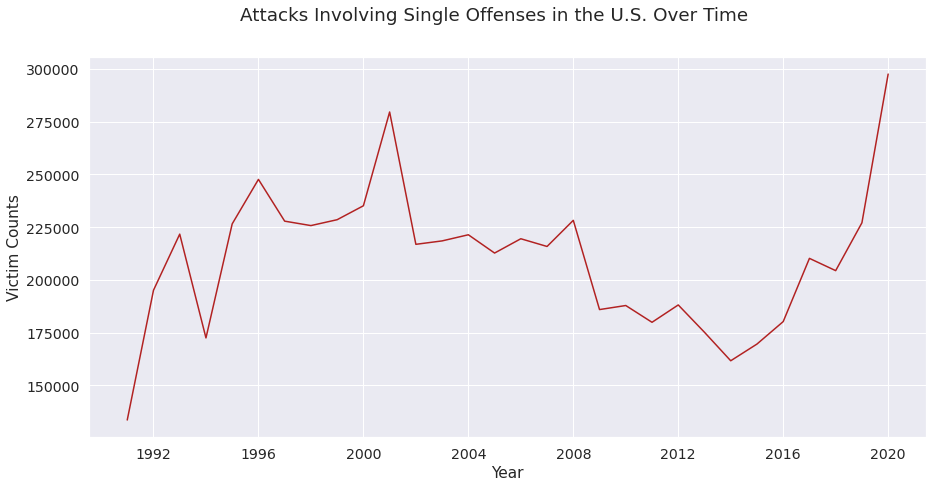

In [ ]:
# Plots the number of single offense cases per year 

year_col = 'DATA_YEAR'
single_off_col = 'MULTIPLE_OFFENSE'

# Plots the victim counts over time in America
stat_over_time(single_off_col, year_col, 'firebrick', 0.5, single_offenses)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Attacks Involving Single Offenses in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Victim Counts")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Single Offenses in the U.S. Over Time')

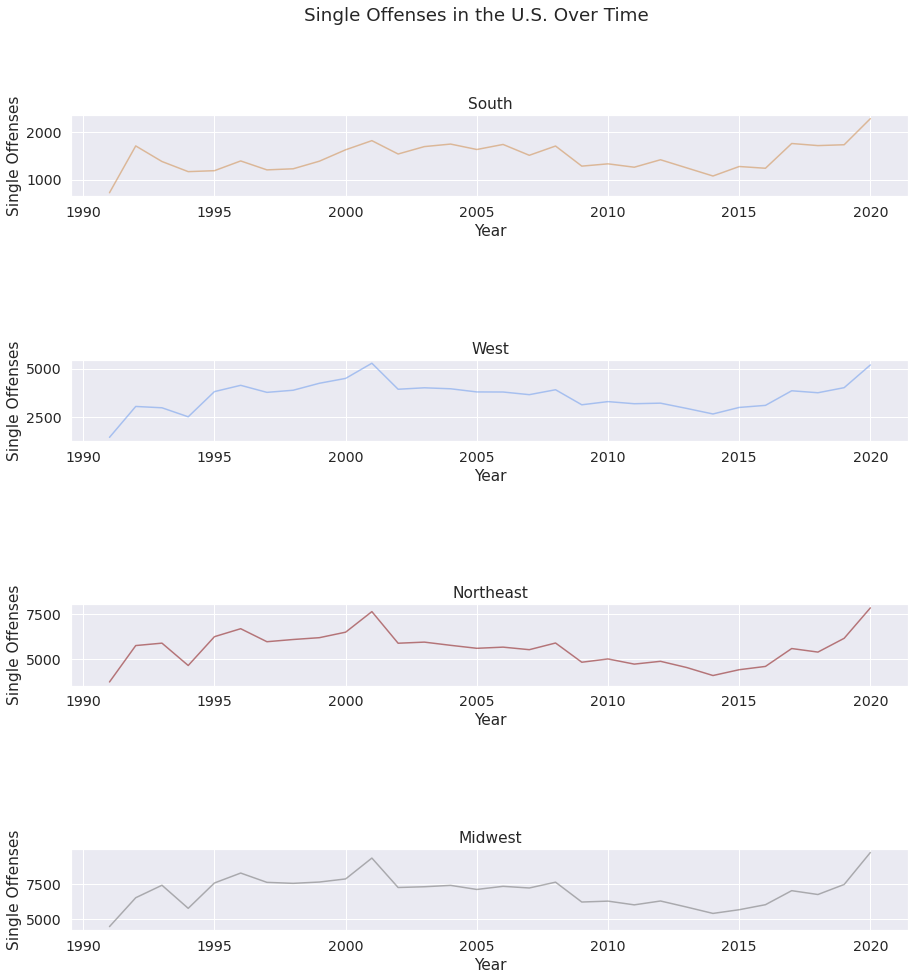

In [ ]:
# Plots the number of single offenses over time in each American region
stat_per_region(multiple_off_col, single_offenses, 0.5, 'Single Offenses')

# Gives the plot a title
plt.suptitle('Single Offenses in the U.S. Over Time')

Nationwide attacks involving single offenses peaked in about 2002, decreased until 2014, and have started to increase rapidly recently. This trend is reflected in each region except the South. The y axis labels of each subplot suggest that single offense cases are most prevalent in the Northeast and Midwest. Attacks involving single offenses have become higher than they have before. However, with the number of those kinds of attacks starting to increase rapidly, proper actions to lower these rates need to be enforced to experience a decline similar to the one that happened after 2002.

Multiple bias and single bias over time in America and per state

In [ ]:
multiple_bias_col = 'MULTIPLE_BIAS'
multiple_bias = csv_to_dicts(HATE_CRIME_FILE)
single_bias = csv_to_dicts(HATE_CRIME_FILE)

In [ ]:
for offense in multiple_bias:
  for key, value in offense.items():
    if key == multiple_bias_col:
      if value == 'M':
        offense[key] = 1
      else:
        offense[key] = 0

In [ ]:
for offense in single_bias:
  for key, value in offense.items():
    if key == multiple_bias_col:
      if value == 'S':
        offense[key] = 1
      else:
        offense[key] = 0

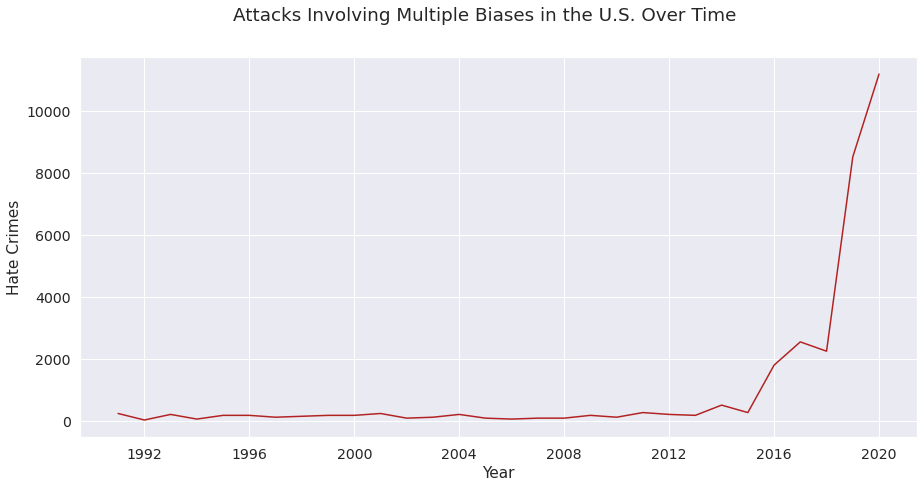

In [ ]:
# Plots the number of multiple bias cases per year 

year_col = 'DATA_YEAR'
mult_bias_col = 'MULTIPLE_BIAS'

# Plots the victim counts over time in America
stat_over_time(mult_bias_col, year_col, 'firebrick', 0.5, multiple_bias)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Attacks Involving Multiple Biases in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Hate Crimes")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Attacks Involving Multiple Biases in U.S. Regions Over Time')

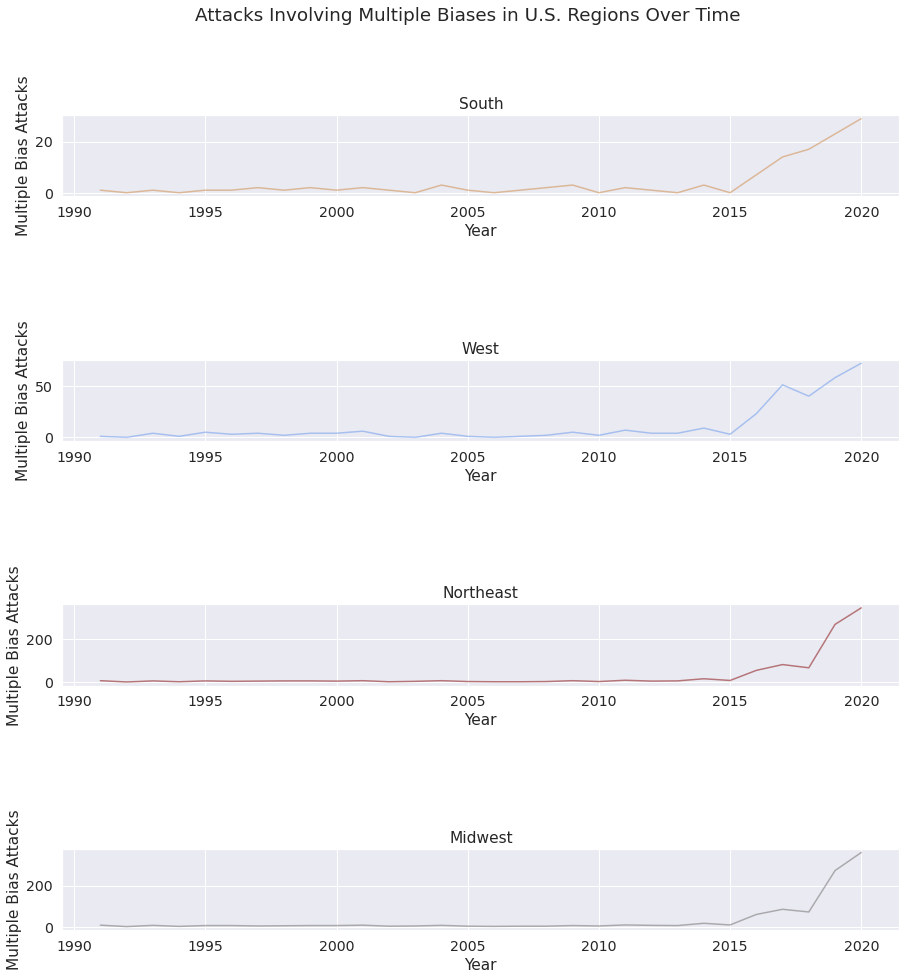

In [ ]:
# Plots the number of multiple biases over time in each American region
stat_per_region(multiple_bias_col, multiple_bias, 0.5, 'Multiple Bias Attacks')

# Gives the plot a title
plt.suptitle('Attacks Involving Multiple Biases in U.S. Regions Over Time')

Recorded attacks involving multiple biases were relatively low until about 2015. From there, these types of attacks increased very rapidly. This same trend is reflected across each region within the United States as well. The y axis of the region subplots indicate that the Northeast and Midwest experience more attacks fueled by multiple biases than the South and West. This rise in cases involving multiple biases suggests that groups of hate crimes victims would benefit from fighting for their justice within solidarity. Despite existing tensions between people of different groups (e.g. Blacks and Asians, Asians and members of the LGBTQ+ community), people need to recognize that all victims of hate crimes can empathize with each other's pain and fight together.

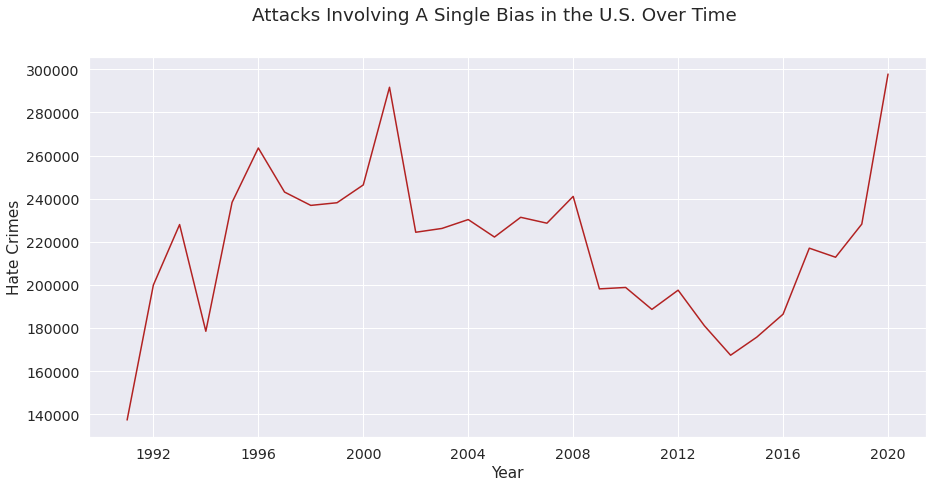

In [ ]:
# Plots the number of single bias cases per year 

year_col = 'DATA_YEAR'
mult_bias_col = 'MULTIPLE_BIAS'

# Plots the victim counts over time in America
stat_over_time(mult_bias_col, year_col, 'firebrick', 0.5, single_bias)

# Gives the plot a title and axes labels. Also adjusts the x-axis values 
plt.suptitle('Attacks Involving A Single Bias in the U.S. Over Time')
plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
plt.xlabel("Year")
plt.ylabel("Hate Crimes")

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

Text(0.5, 0.98, 'Attacks Involving Single Biases in U.S. Regions Over Time')

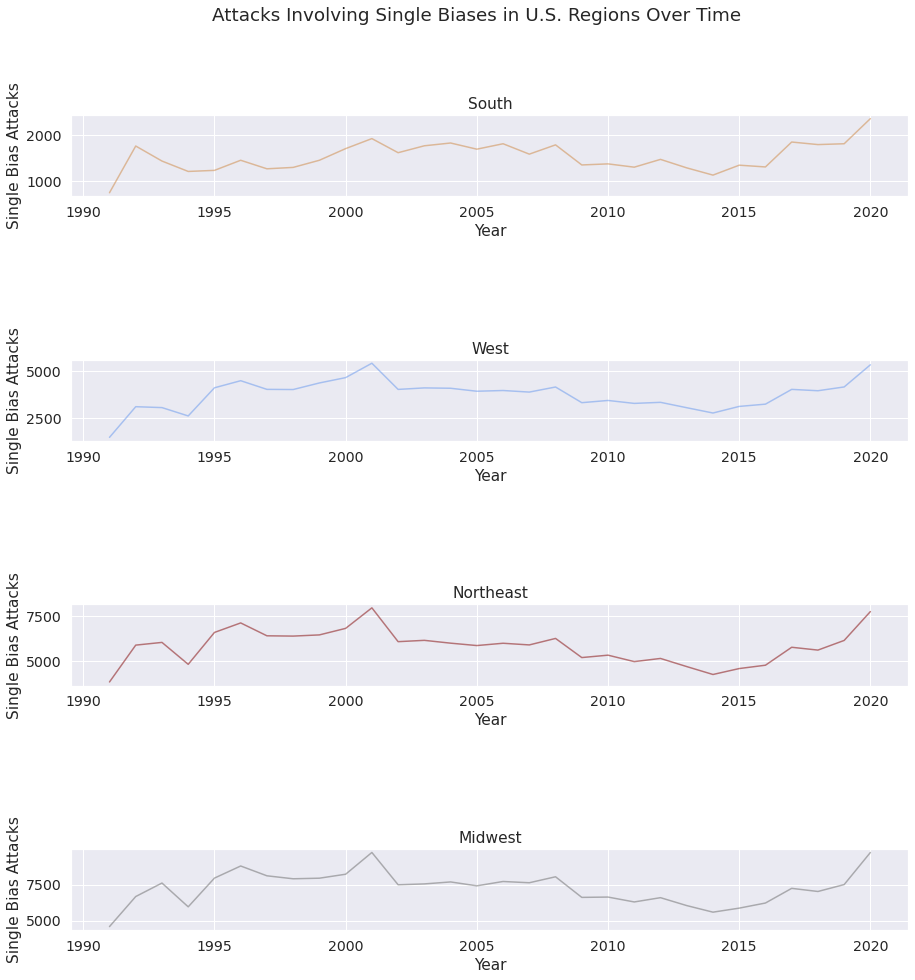

In [ ]:
# Plots the number of single biases over time in each American region
stat_per_region(multiple_bias_col, single_bias, 0.5, 'Single Bias Attacks')

# Gives the plot a title
plt.suptitle('Attacks Involving Single Biases in U.S. Regions Over Time')

Recorded attacks involving a single biases relatively increased from 1991 to about 2001. From there, these types of attacks decreased until about 2014. Since then, they have been increasing very rapidly. This same trend is reflected across each region within the United States as well. The y axis of the region subplots indicate that the Northeast and Midwest experience more attacks fueled by multiple biases than the West and especially the South. This rise in cases involving single biases further justifies the need for immediate action by people who are privileged enough to be safe from hate crimes to protect those who cannot relate.

Offender race over time in America and per region

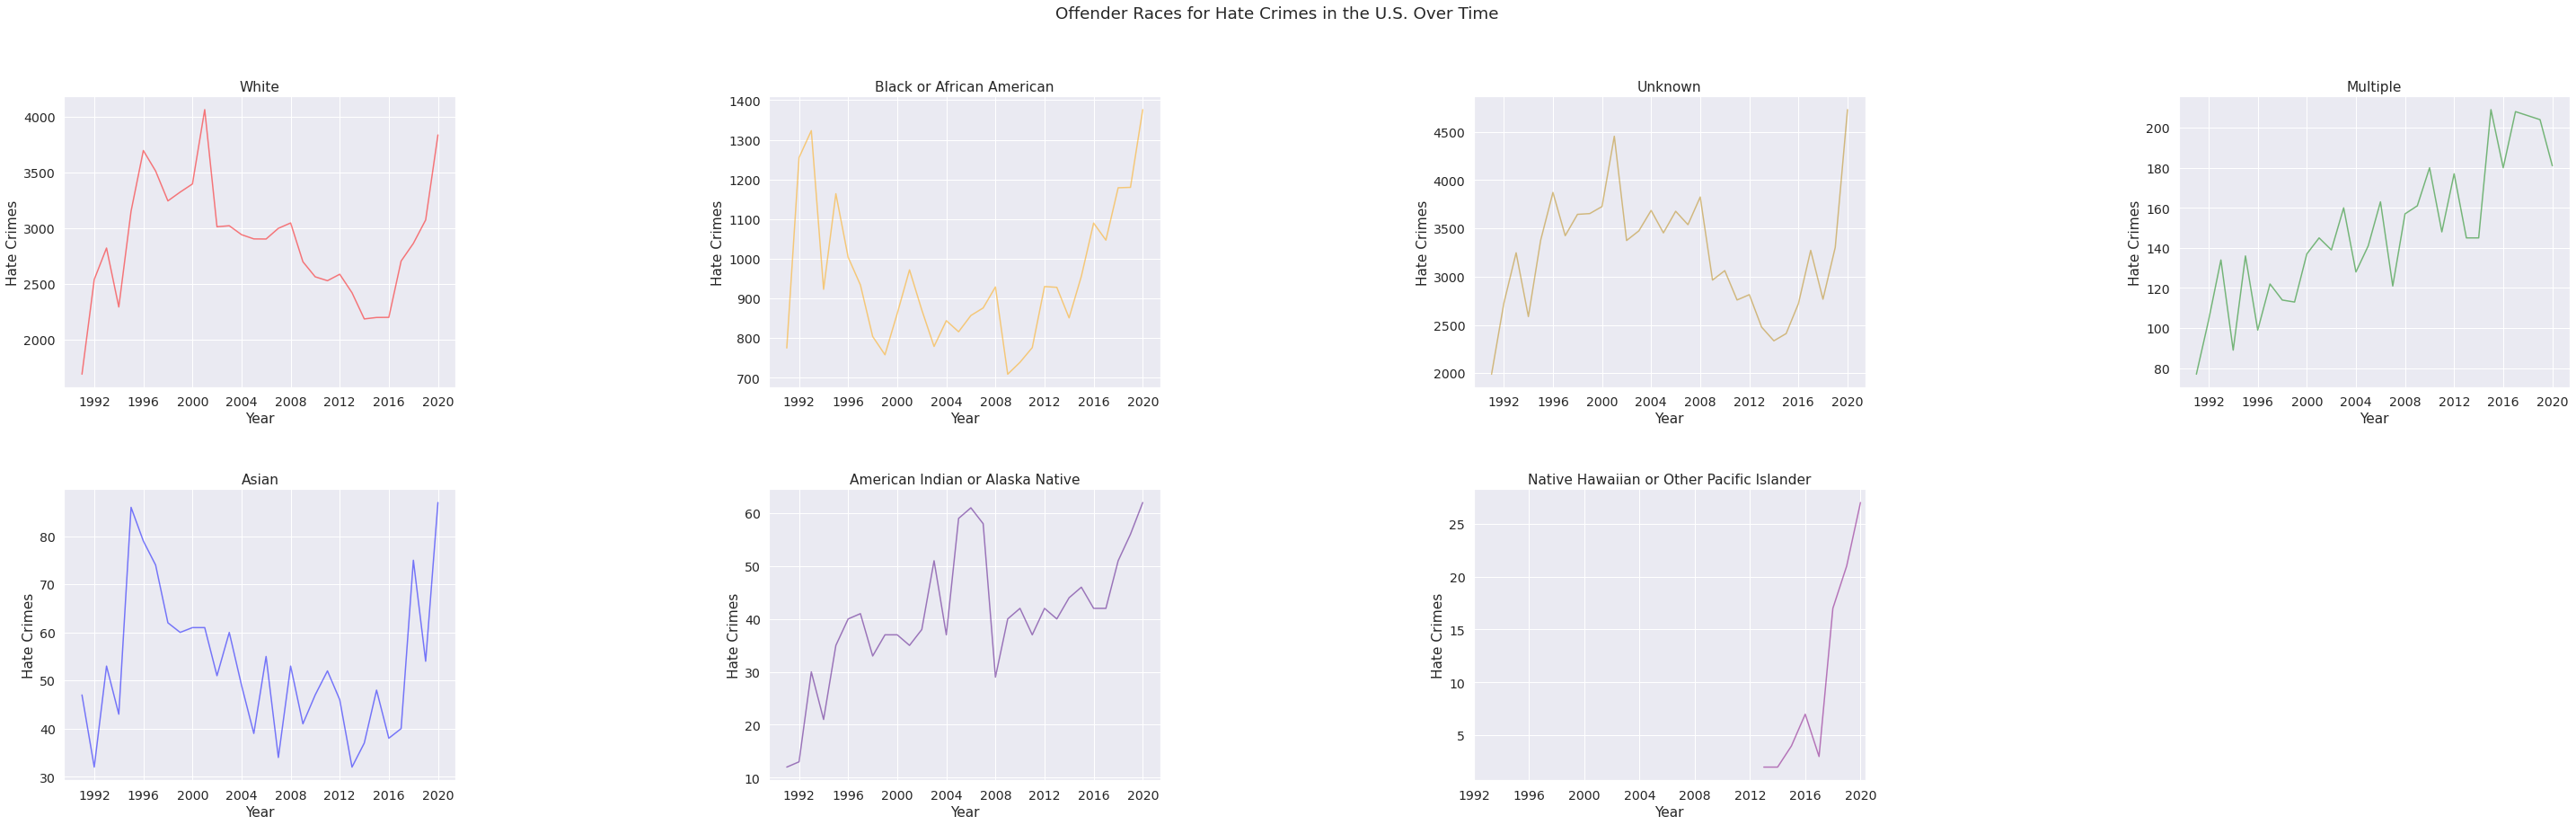

In [ ]:
year_col = 'DATA_YEAR'
off_race_col = 'OFFENDER_RACE'
colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 'purple']

# a list of the offender races we are concerned about
off_races = ['White', 'Black or African American', 'Unknown', 'Multiple', 
             'Asian', 'American Indian or Alaska Native', 
             'Native Hawaiian or Other Pacific Islander']

# Tracks the number of attacks by people of a certain race in one year
for i in range(len(off_races)):

  off_race_counts = defaultdict(lambda: 0)
  
  for incident in incidents:
    for key, value in incident.items():
      if key == off_race_col and value == off_races[i]:
          off_race_counts[incident[year_col]] += 1

  years = [int(year) for year in off_race_counts.keys()]
  counts = [count for count in off_race_counts.values()]

  # Creates subplots for the number of attacks that a hate crime group received
  # over time

  plt.subplot(2, 4, i + 1)
  plt.plot(years, counts, color = colors[i], alpha = 0.5)
  plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
  plt.xlabel("Year")
  plt.ylabel("Hate Crimes")

  # Each subplot is labeled based on the bias they are representing
  plt.gca().title.set_text(off_races[i])

# Gives the plot a title
plt.suptitle('Offender Races for Hate Crimes in the U.S. Over Time')

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(50, 14)

# adjusts spacing between graphs
plt.subplots_adjust(wspace=.8, hspace=.35)

The subplots show that from 1991 until today, more people of all the races described in the plots have been engaging in hate crimes as attackers. In particular, the number of offenders who are White have consistently been much larger than the number of offenders who are part of another known race. The number of offenders, no matter the race, peaked around a certain year, declined, and then rose rapidly until present day. In particular, White people need to be monitored more closely and educated about the dangers of imposing hate crimes in the United States. Even though they cannot truly understand the hardships that people of color have to face, providing resources that help them become compassionate rather than hateful individuals can help transform American societies into more peaceful areas for all. We think that people should try to to decrease the number of hate crimes initiated by White individuals through tactics that avoid antagonizing White individuals but rather aim at strengthening White people's empathy toward people of color. Antagonizing tactics have been used for a long time, but considering how offender race counts have been increasing rapidly recently, people need to consider another approach to limiting hate crimes in the United States.

---



Text(0.5, 0.98, 'Trends of Offender Races in 25 States')

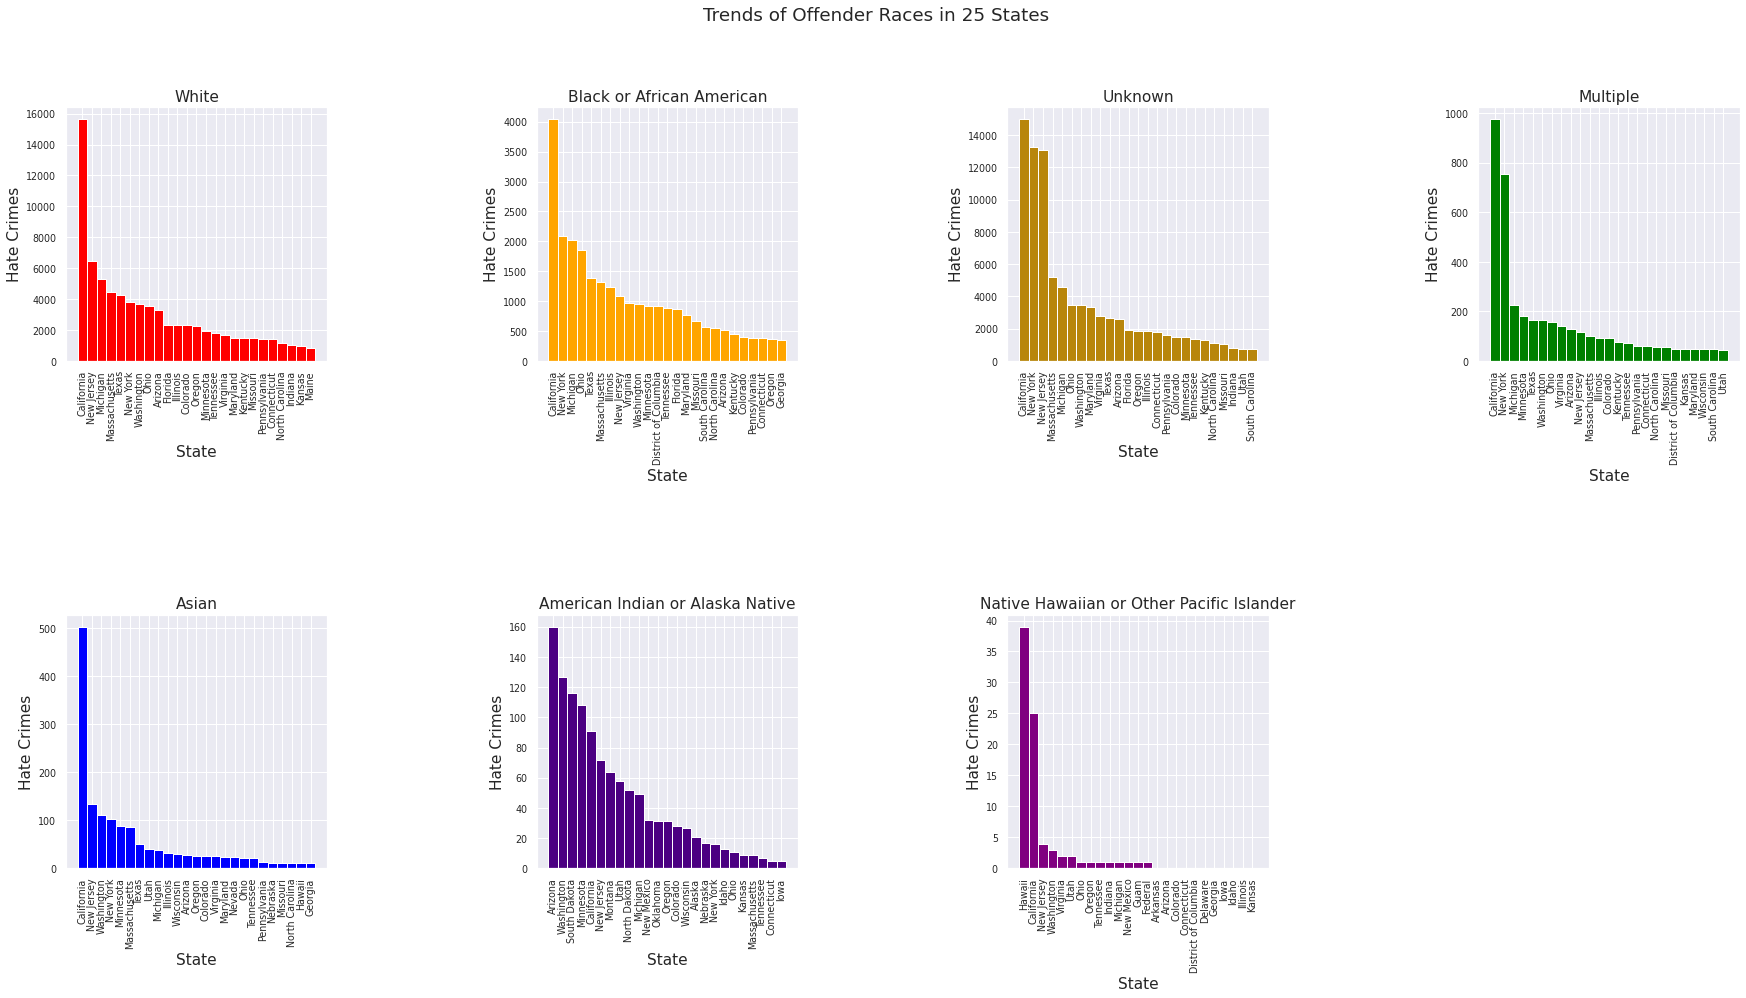

In [ ]:
# a list of the offender races we are concerned about
off_races = ['White', 'Black or African American', 'Unknown', 'Multiple', 
             'Asian', 'American Indian or Alaska Native', 
             'Native Hawaiian or Other Pacific Islander']
colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'indigo', 'purple', 
          'fuchsia', 'brown', 'black', 'maroon', 'gray']
off_race_col = "OFFENDER_RACE"

# Creates a bar chart representing the frequency of offender races in 25 states
# with the most incidents with offenders of that race
stat_per_state(off_race_col, off_races, 2, 4, colors = colors)

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(30, 14)

# adjusts spacing between graphs
plt.subplots_adjust(wspace=.8, hspace=1)

# Adds an overarching title to the graph
plt.suptitle('Trends of Offender Races in 25 States')

California is the state that typically hosts the most number of hate crimes conducted by people of a certain race, no matter the race. California has the most White, Black or African American, unknown, multi-racial, and Asian hate crime offenders. Arizona, [one of the 14 states with more than 100,000 American Indian or Alaskan natives](https://www.acf.hhs.gov/ana/fact-sheet/american-indians-and-alaska-natives-numbers), has the most American Indian offenders. Hawaii, [which has the most Native Hawaiian or other Pacific Islanders in the United States](https://minorityhealth.hhs.gov/omh/browse.aspx?lvl=3&lvlid=65), has the most Native Hawaiian/Pacific Islander offenders. Governors in states that hold the most offenders of a particular race should devise strategies that target the people most likely to initiate a hate crime in their state. Also, support groups within the state that foster communities of people similar to those who engage in the most hate crimes of that state could engage their communities in restorative processes that help them get in touch with their emotions, reduce their inclination toward violence, and promote universal tranquility. For instance, Asian support groups in California should unite other Asians within the state and help to give them access to [specific resources](https://www.jw.org/en/library/magazines/g201208/Causes-of-Violence/) (such as jobs, housing, circle groups, and substance abuse counseling services) that would stray Asians from risk factors that would cause them to do harm. Here are the top 5 states, listed from most incidents to least incidents, that have hate crimes caused by people of a particular offender group:

- **White**: California, New Jersey, Michigan, Massachusetts, Texas
- **Black or African American**: California, New York, Michigan, Ohio, Texas
- **Unknown**: California, New York, New Jersey, Massachusetts, Michigan
- **Multiple**: California, New York, Michigan, Minnesota, Texas
- **Asian**: California, New Jersey, Washington, New York, Minnesota
- **American Indian or Alaska Native**: Arizona, Washington, South Dakota, Minnesota, California
- **Native Hawaiian or Other Pacific Islander**: Hawaii, California, New Jersey, Washington, Virginia

Offender ethnicity over time in America and per state

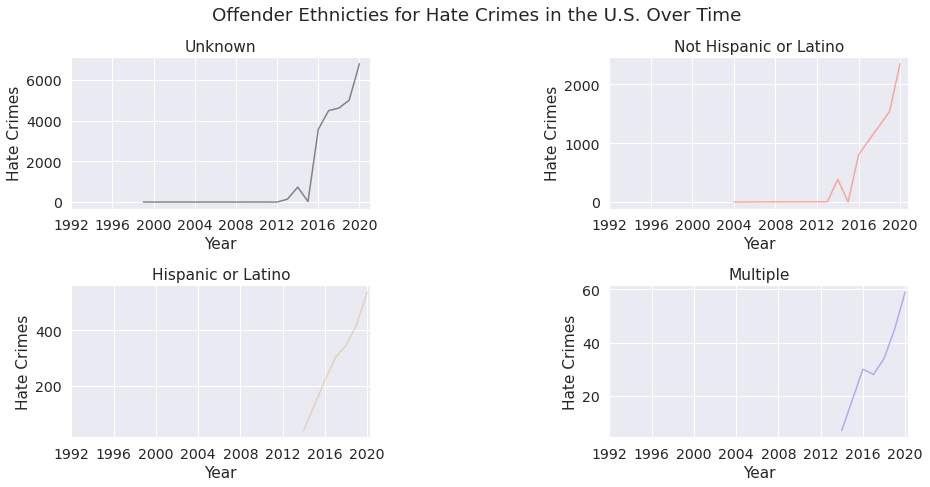

In [ ]:
year_col = "DATA_YEAR"
off_ethnicity_col = 'OFFENDER_ETHNICITY'
colors = ['k', 'tomato', 'burlywood', 'mediumslateblue']

# a list of the offender ethnicities we are concerned about
off_ethnicities = ['Unknown', 'Not Hispanic or Latino', 'Hispanic or Latino',
                   'Multiple']

# Tracks the number of attacks by people of a certain race in one year
for i in range(len(off_ethnicities)):

  off_ethnicity_counts = defaultdict(lambda: 0)
  
  for incident in incidents:
    for key, value in incident.items():
      if key == off_ethnicity_col and value == off_ethnicities[i]:
          off_ethnicity_counts[incident[year_col]] += 1

  years = [int(year) for year in off_ethnicity_counts.keys()]
  counts = [count for count in off_ethnicity_counts.values()]

  # Creates subplots for the number of attacks that a hate crime group received
  # over time

  plt.subplot(2, 2, i + 1)
  plt.plot(years, counts, color = colors[i], alpha = 0.5)
  plt.xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
  plt.xlabel("Year")
  plt.ylabel("Hate Crimes")

  # Each subplot is labeled based on the bias they are representing
  plt.gca().title.set_text(off_ethnicities[i])

# Gives the plot a title
plt.suptitle('Offender Ethnicties for Hate Crimes in the U.S. Over Time')

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(15, 7)

# adjusts spacing between graphs
plt.subplots_adjust(wspace=.8, hspace=.5)

Most of the ethnicities of people who engage in hate crimes have been unknown from 1991 until now. Of the offenders whose ethnicity is known, as suggested by the y-axis of each subplot, most of the offenders are not Hispanic or Latino. Offenders of all ethnicities have been increasing rapidly. The number of non-Hispanic or Latino and unknown offenders slightly declined in 2014. The number of offenders associated with multiple ethnicities slightly declined during around 2017. The overall increase in offenders of all ethnicities reflects another reason for accelerating the push towards limiting hate crimes. 

Text(0.5, 0.98, 'Trends for Offender Races in 25 States')

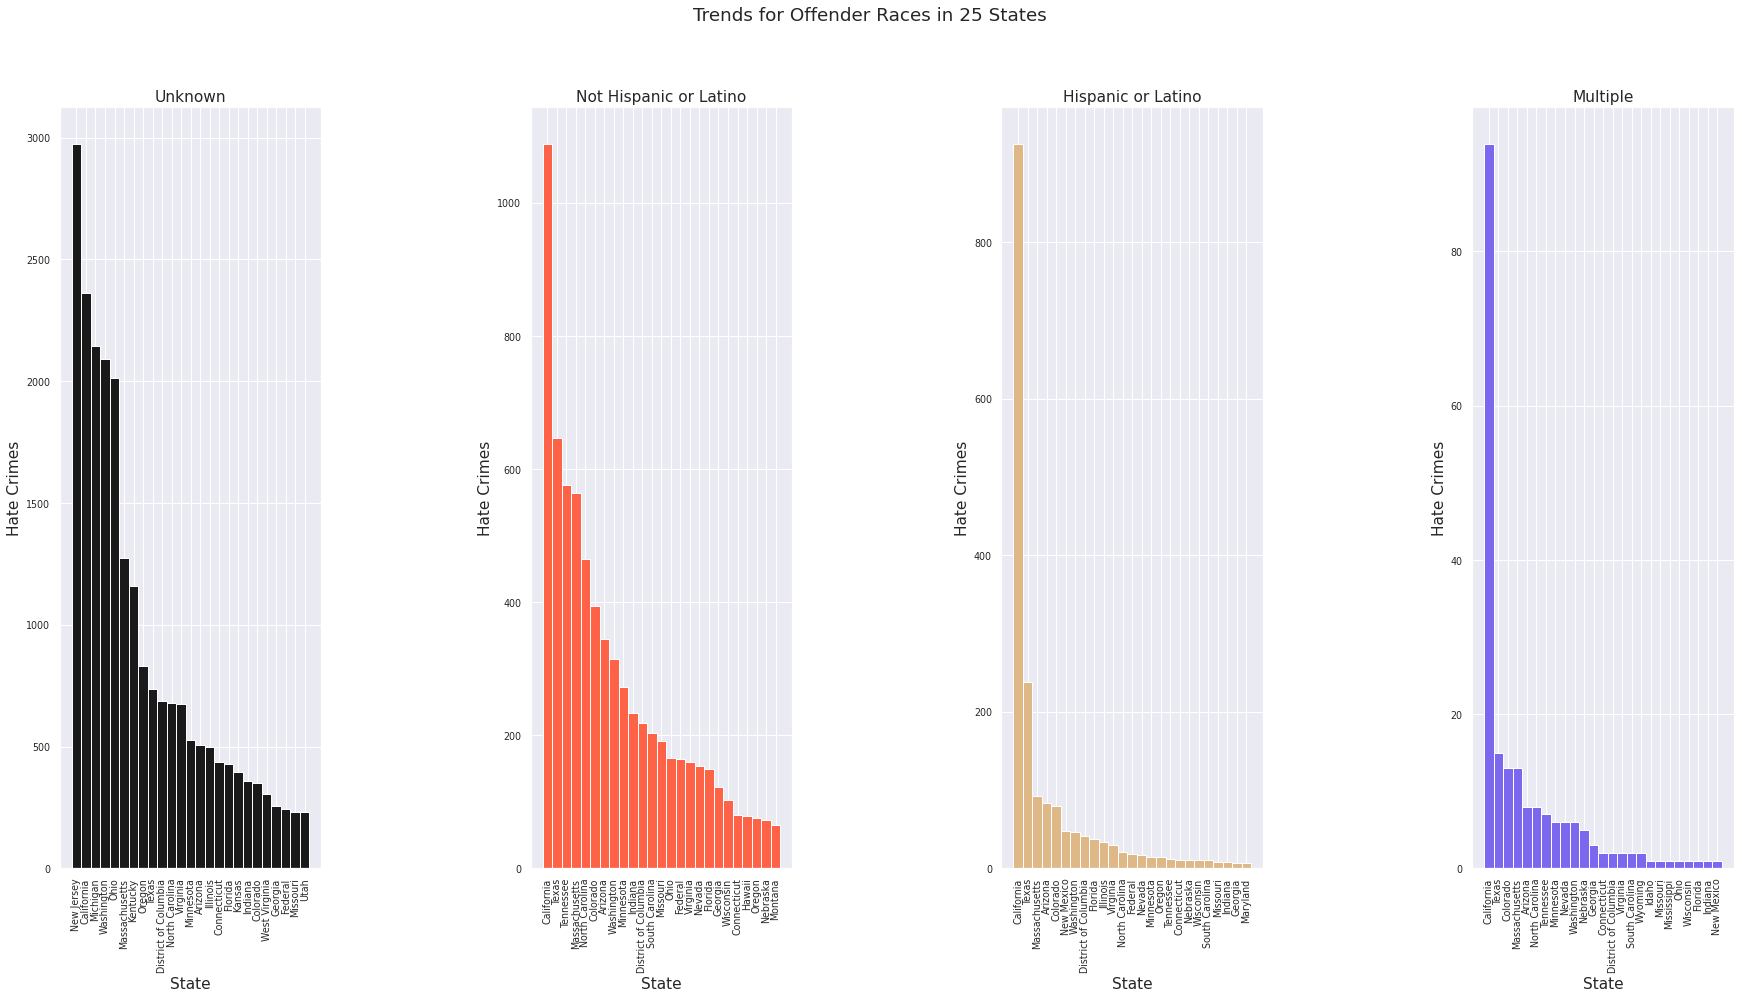

In [ ]:
off_ethnicity_col = 'OFFENDER_ETHNICITY'
colors = ['k', 'tomato', 'burlywood', 'mediumslateblue']

# a list of the offender ethnicities we are concerned about
off_ethnicities = ['Unknown', 'Not Hispanic or Latino', 'Hispanic or Latino',
                   'Multiple']


# Creates a bar chart representing the frequency of offender ethnicities in 25 
# states with the most incidents with offenders of that race
stat_per_state(off_ethnicity_col, off_ethnicities, 1, 4, colors = colors)

# resizes the graph to ensure that it can be clearly read
plt.gcf().set_size_inches(30, 14)

# adjusts spacing between graphs
plt.subplots_adjust(wspace=.8, hspace=1)

# Adds an overarching title to the graph
plt.suptitle('Trends for Offender Races in 25 States')

California and Texas are the states that usually experience the most number of hate crimes conducted by people of a certain ethnicity, no matter the ethnicity. California, followed by Texas, have the most non-Hispanic or Latino, Hispanic or Latino, and multi-ethnic hate crime offenders. New Jersey has the most hate crime offenders with an unknown ethnicity. Governors in states with high rates of hate crime offenders of a particular ethnicity should reflect on this data when formulating initiatives to lower hate crimes of their state. New Mexico state governors could use the fact that many of their hate crime offenders are Hispanic or Latino to support Hispanics and Latinos in their state to prevent them from engaging in hate crimes. Hispanic and Latino groups within New Mexico can also assist Hispanic and Latin communities in the state in an effort to lower hate crimes in New Mexico. [Risk factors](https://www.jw.org/en/library/magazines/g201208/Causes-of-Violence/) for violence include jealousy, substance and drug abuse, corrupt justice systems, discrimination, and economic instability. If community support groups and governments recognize that these socioeconomic factors are a significant reason for our nation's rise in hate crimes, rather than putting all of the blame on individuals, these communities and governments can efficiently engage in restorative justice. Here are the top 5 states, listed from most incidents to least incidents, that have hate crimes caused by people of a particular ethnicity:

- **Unknown**: New Jersey, California, Michigan, Washington, Ohio
- **Not Hispanic or Latino**: California, Texas, Tennessee, Massachusetts, North Carolina
- **Hispanic or Latino**: California, Texas, Massachusetts, Arizona, Colorado
- **Multiple**: California, Texas, Colorado, Massachusetts, Arizona

Algorithm to determine the factors that would best protect people of a certain bias

In this section, we used a kNN-classifier to determine the factors that best determine the bias motivated by a state. In other words, the classifier predicts the bias involved in a hate crime based on a set of characteristics for each hate crime. These characteristics are:

- The state that the hate crime is located in
- The division that the hate crime is located in
- The region that the hate crime is located in
- The race of the hate crime's offender
- The ethnicity of the hate crime's offender
- The type of offense involved in the hate crime
- The type of location where the hate crime occurs (e.g. grocery, school, bus, synagogue, college)
- The type of the victim (e.g. individual, religious organization, society)
- Whether the hate crime involved multiple offenses
- Whether the hate crime involved multiple biases

We hope that by finding the characteristics that are most prominent among hate crimes of a certain type, we can propose the most important factors that people who want to lower hate crimes rates of a certain kind need to consider. The factors listed above definitely do not fully encompass the essence of a hate crime. However, the dataset we have access to only allows us to draw conclusions from those features. Nevertheless, initiatives that involve the characteristics that our algorithm discovers to be most significant in determining a hate crime's bias could help America to be a safer place to live for people of all branches of diversity.

In [ ]:
# a list of the biases we are concerned about
biases = ['Anti-Asian', 'Anti-Black or African American', 'Anti-Jewish', 
          'Anti-Arab', 'Anti-Gay (Male)', 'Anti-Lesbian (Female)', 
          'Anti-Bisexual', 
          'Anti-Lesbian/ Gay/ Bisexual/ or Transgender (Mixed Group)', 
          'Anti-Protestant', 'Anti-Hispanic or Latino', 
          'Anti-American Indian or Alaska Native', 'Anti-Physical Disability',
          'Anti-Islamic (Muslim)']

HATE_CRIME_FILE = 'hate_crime_algo.csv'
df_hate_crime_filtered = pd.DataFrame()

# read the hate crime file and turn it into a dataframe
df_hate_crime = pd.read_csv(HATE_CRIME_FILE)

# Cleans the hate crime dataframe to only include hate crime incidents with the
# offender race of interest
for i in range(len(biases)):
  bias_bool = df_hate_crime.loc[:, 'BIAS_DESC'] == biases[i]
  if i == 0:
    df_hate_crime_filtered = df_hate_crime.loc[bias_bool, :]
  elif i > 1:
    df_bias_attacks = df_hate_crime.loc[bias_bool, :]
    df_hate_crime_filtered = \
      pd.merge(df_hate_crime_filtered, df_bias_attacks, how = 'outer')

# discard any rows missing data or data that equals infinity
df_hate_crime_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_hate_crime_filtered.dropna(axis=0, inplace=True)

# get the dummies and store it in a variable
dummies = pd.get_dummies(df_hate_crime_filtered)
 
# Concatenate the dummies to original dataframe
df_hate_crime_filtered = \
  pd.concat([df_hate_crime_filtered, dummies], axis = 'columns')
 
# drop the original values that are now represented by dummies, as well as
# the dummies created with the bias descriptions
df_hate_crime_filtered = df_hate_crime_filtered.drop(['STATE_NAME', 
  'DIVISION_NAME', 'REGION_NAME', 'OFFENDER_RACE', 'OFFENDER_ETHNICITY', 
  'OFFENSE_NAME', 'LOCATION_NAME', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE', 
  'MULTIPLE_BIAS'], axis = 'columns')

for bias in biases:
  # none of the black or Anti-African American data remain after cleaning out
  # the null and infinite values from the data
  if bias != 'Anti-Black or African American':
    df_hate_crime_filtered = df_hate_crime_filtered.drop([f'BIAS_DESC_{bias}'],
                                                        axis = 'columns')

# remove duplicate columns
df_hate_crime_filtered = \
df_hate_crime_filtered.loc[:,~df_hate_crime_filtered.columns.duplicated()].copy()

# show the first few rows of the hate crime dataframe
df_hate_crime_filtered.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


ADULT_VICTIM_COUNT  JUVENILE_VICTIM_COUNT  TOTAL_OFFENDER_COUNT  \
5360                 1.0                    0.0                     1   
5382                 1.0                    0.0                     1   
5386                 1.0                    0.0                     0   
5400                 1.0                    0.0                     1   
5401                 1.0                    0.0                     1   

      ADULT_OFFENDER_COUNT  JUVENILE_OFFENDER_COUNT  VICTIM_COUNT  \
5360                   1.0                      0.0             1   
5382                   1.0                      0.0             1   
5386                   0.0                      0.0             1   
5400                   1.0                      0.0             1   
5401                   1.0                      0.0             1   

      TOTAL_INDIVIDUAL_VICTIMS   BIAS_DESC  STATE_NAME_Alabama  \
5360                       1.0  Anti-Asian                   0   
5382                       1.0  Anti-Asian                   1   
5386                       1.0  Anti-Asian                   0   
5400                       1.0  Anti-Asian                   0   
5401                       1.0  Anti-Asian                   0   

      STATE_NAME_Alaska  ...  VICTIM_TYPES_Individual;Society/Public  \
5360                  0  ...                                       0   
5382                  0  ...                                       0   
5386                  0  ...                                       0   
5400                  0  ...                                       0   
5401                  0  ...                                       0   

      VICTIM_TYPES_Individual;Unknown  VICTIM_TYPES_Law Enforcement Officer  \
5360                                0                                     0   
5382                                0                                     0   
5386                                0                                     0   
5400                                0                                     0   
5401                                0                                     0   

      VICTIM_TYPES_Other  VICTIM_TYPES_Religious Organization  \
5360                   0                                    0   
5382                   0                                    0   
5386                   0                                    0   
5400                   0                                    0   
5401                   0                                    0   

      VICTIM_TYPES_Society/Public  VICTIM_TYPES_Unknown  MULTIPLE_OFFENSE_M  \
5360                            0                     0                   0   
5382                            0                     0                   0   
5386                            0                     0                   0   
5400                            0                     0                   0   
5401                            0                     0                   0   

      MULTIPLE_OFFENSE_S  MULTIPLE_BIAS_S  
5360                   1                1  
5382                   1                1  
5386                   1                1  
5400                   1                1  
5401                   1                1  

[5 rows x 294 columns]

In [ ]:
# hides the pip logs of this cell
%%capture

# by dividing each feature by the standard deviation, outputs will have same 
# std dev
df_hate_crime_scaled = pd.DataFrame()

# apply principal component analysis
pca = PCA(whiten = True)

for feat in df_hate_crime_filtered.columns:
    feature_vals = df_hate_crime_filtered[feat].values

    if feat != 'BIAS_DESC':
        feature_vals  = pca.fit_transform(feature_vals.reshape(-1, 1))
        df_hate_crime_scaled[f'{feat}_scaled'] = \
        df_hate_crime_filtered[feat] / df_hate_crime_filtered[feat].std()

# discard any rows missing data or data that equals infinity
df_hate_crime_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)
df_hate_crime_scaled.dropna(axis=0, inplace=True)

In [ ]:
# builds a new dataframe for the hate crime data with normalized values
df_hate_crime_scaled = \
  df_hate_crime_scaled.join(df_hate_crime_filtered['BIAS_DESC'])
df_hate_crime_scaled.head()

Empty DataFrame
Columns: [ADULT_VICTIM_COUNT_scaled, JUVENILE_VICTIM_COUNT_scaled, TOTAL_OFFENDER_COUNT_scaled, ADULT_OFFENDER_COUNT_scaled, JUVENILE_OFFENDER_COUNT_scaled, VICTIM_COUNT_scaled, TOTAL_INDIVIDUAL_VICTIMS_scaled, STATE_NAME_Alabama_scaled, STATE_NAME_Alaska_scaled, STATE_NAME_Arizona_scaled, STATE_NAME_Arkansas_scaled, STATE_NAME_California_scaled, STATE_NAME_Colorado_scaled, STATE_NAME_Connecticut_scaled, STATE_NAME_Delaware_scaled, STATE_NAME_District of Columbia_scaled, STATE_NAME_Federal_scaled, STATE_NAME_Florida_scaled, STATE_NAME_Georgia_scaled, STATE_NAME_Hawaii_scaled, STATE_NAME_Idaho_scaled, STATE_NAME_Illinois_scaled, STATE_NAME_Indiana_scaled, STATE_NAME_Iowa_scaled, STATE_NAME_Kansas_scaled, STATE_NAME_Kentucky_scaled, STATE_NAME_Louisiana_scaled, STATE_NAME_Maine_scaled, STATE_NAME_Maryland_scaled, STATE_NAME_Massachusetts_scaled, STATE_NAME_Michigan_scaled, STATE_NAME_Minnesota_scaled, STATE_NAME_Mississippi_scaled, STATE_NAME_Missouri_scaled, STATE_NAME_Montana_scaled, STATE_NAME_Nebraska_scaled, STATE_NAME_Nevada_scaled, STATE_NAME_New Hampshire_scaled, STATE_NAME_New Jersey_scaled, STATE_NAME_New Mexico_scaled, STATE_NAME_New York_scaled, STATE_NAME_North Carolina_scaled, STATE_NAME_North Dakota_scaled, STATE_NAME_Ohio_scaled, STATE_NAME_Oklahoma_scaled, STATE_NAME_Oregon_scaled, STATE_NAME_Pennsylvania_scaled, STATE_NAME_Rhode Island_scaled, STATE_NAME_South Carolina_scaled, STATE_NAME_South Dakota_scaled, STATE_NAME_Tennessee_scaled, STATE_NAME_Texas_scaled, STATE_NAME_Utah_scaled, STATE_NAME_Vermont_scaled, STATE_NAME_Virginia_scaled, STATE_NAME_Washington_scaled, STATE_NAME_West Virginia_scaled, STATE_NAME_Wisconsin_scaled, STATE_NAME_Wyoming_scaled, DIVISION_NAME_East North Central_scaled, DIVISION_NAME_East South Central_scaled, DIVISION_NAME_Middle Atlantic_scaled, DIVISION_NAME_Mountain_scaled, DIVISION_NAME_New England_scaled, DIVISION_NAME_Other_scaled, DIVISION_NAME_Pacific_scaled, DIVISION_NAME_South Atlantic_scaled, DIVISION_NAME_West North Central_scaled, DIVISION_NAME_West South Central_scaled, REGION_NAME_Midwest_scaled, REGION_NAME_Northeast_scaled, REGION_NAME_Other_scaled, REGION_NAME_South_scaled, REGION_NAME_West_scaled, OFFENDER_RACE_American Indian or Alaska Native_scaled, OFFENDER_RACE_Asian_scaled, OFFENDER_RACE_Black or African American_scaled, OFFENDER_RACE_Multiple_scaled, OFFENDER_RACE_Native Hawaiian or Other Pacific Islander_scaled, OFFENDER_RACE_Unknown_scaled, OFFENDER_RACE_White_scaled, OFFENDER_ETHNICITY_Hispanic or Latino_scaled, OFFENDER_ETHNICITY_Multiple_scaled, OFFENDER_ETHNICITY_Not Hispanic or Latino_scaled, OFFENDER_ETHNICITY_Unknown_scaled, OFFENSE_NAME_Aggravated Assault_scaled, OFFENSE_NAME_Aggravated Assault;Arson_scaled, OFFENSE_NAME_Aggravated Assault;Arson;Destruction/Damage/Vandalism of Property_scaled, OFFENSE_NAME_Aggravated Assault;Burglary/Breaking & Entering_scaled, OFFENSE_NAME_Aggravated Assault;Burglary/Breaking & Entering;Destruction/Damage/Vandalism of Property_scaled, OFFENSE_NAME_Aggravated Assault;Burglary/Breaking & Entering;Robbery_scaled, OFFENSE_NAME_Aggravated Assault;Destruction/Damage/Vandalism of Property_scaled, OFFENSE_NAME_Aggravated Assault;Destruction/Damage/Vandalism of Property;Intimidation;Shoplifting_scaled, OFFENSE_NAME_Aggravated Assault;Destruction/Damage/Vandalism of Property;Simple Assault_scaled, OFFENSE_NAME_Aggravated Assault;Drug/Narcotic Violations_scaled, OFFENSE_NAME_Aggravated Assault;Impersonation_scaled, OFFENSE_NAME_Aggravated Assault;Intimidation_scaled, OFFENSE_NAME_Aggravated Assault;Intimidation;Kidnapping/Abduction;Weapon Law Violations_scaled, OFFENSE_NAME_Aggravated Assault;Intimidation;Robbery_scaled, OFFENSE_NAME_Aggravated Assault;Intimidation;Sexual Assault With An Object;Simple Assault_scaled, ...]
Index: []

[0 rows x 294 columns]

Since no valid data would remain if we normalized it, we cannot use normalized values for our classifier.

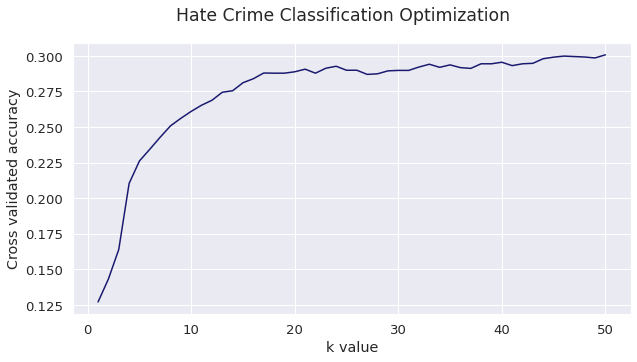

In [ ]:
# Determines the tested and true values
x_feat_list = list(df_hate_crime_filtered.columns)
x_feat_list.remove('BIAS_DESC')
y_feat = 'BIAS_DESC'

x = df_hate_crime_filtered.loc[:, x_feat_list].values
y_true = df_hate_crime_filtered.loc[:, y_feat].values
accuracies = []

# Seaborn makes your plots look nicer!
sns.set(font_scale=1.2)

# Plots the cross validated accuracy of the k-NN classifier for k = 1 to 50
for i in range(1, 51):
    accuracy = get_cv_acc_knn(x, y_true, k = i, n_splits = 10)
    accuracies.append(accuracy)
    
k_values = [num for num in range(1, 51)]
plt.plot(k_values, accuracies, color = 'midnightblue')

# Adds labels to the plot and resizes it
plt.xlabel('k value')
plt.ylabel('Cross validated accuracy')
plt.suptitle('Hate Crime Classification Optimization')
plt.gcf().set_size_inches(10, 5)

The graph shows that a k value of 50 and up would enable the classifier to predict the bias of a certain attack with the greatest level of accuracy.

In [ ]:
k = 50
x_feat_list = list(df_hate_crime_filtered.columns)
x_feat_list.remove('BIAS_DESC')
y_feat = 'BIAS_DESC'

x = df_hate_crime_filtered.loc[:, x_feat_list].values
y_true = df_hate_crime_filtered.loc[:, y_feat].values

# initialize a knn classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Cross-validation: ensuring that every sample in the test set does NOT appear
# in the training set

# construction of kfold object
# Use StratifiedKFold for nominal data
kfold = StratifiedKFold(n_splits=10, shuffle = True)

# allocate an empty array to store predictions in
y_pred = np.empty_like(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]

    # fit happens "inplace", we modify the internal state of knn_classifier to 
    # remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # guess the bias of the attack
    y_pred[test_idx] = knn_classifier.predict(x_test)


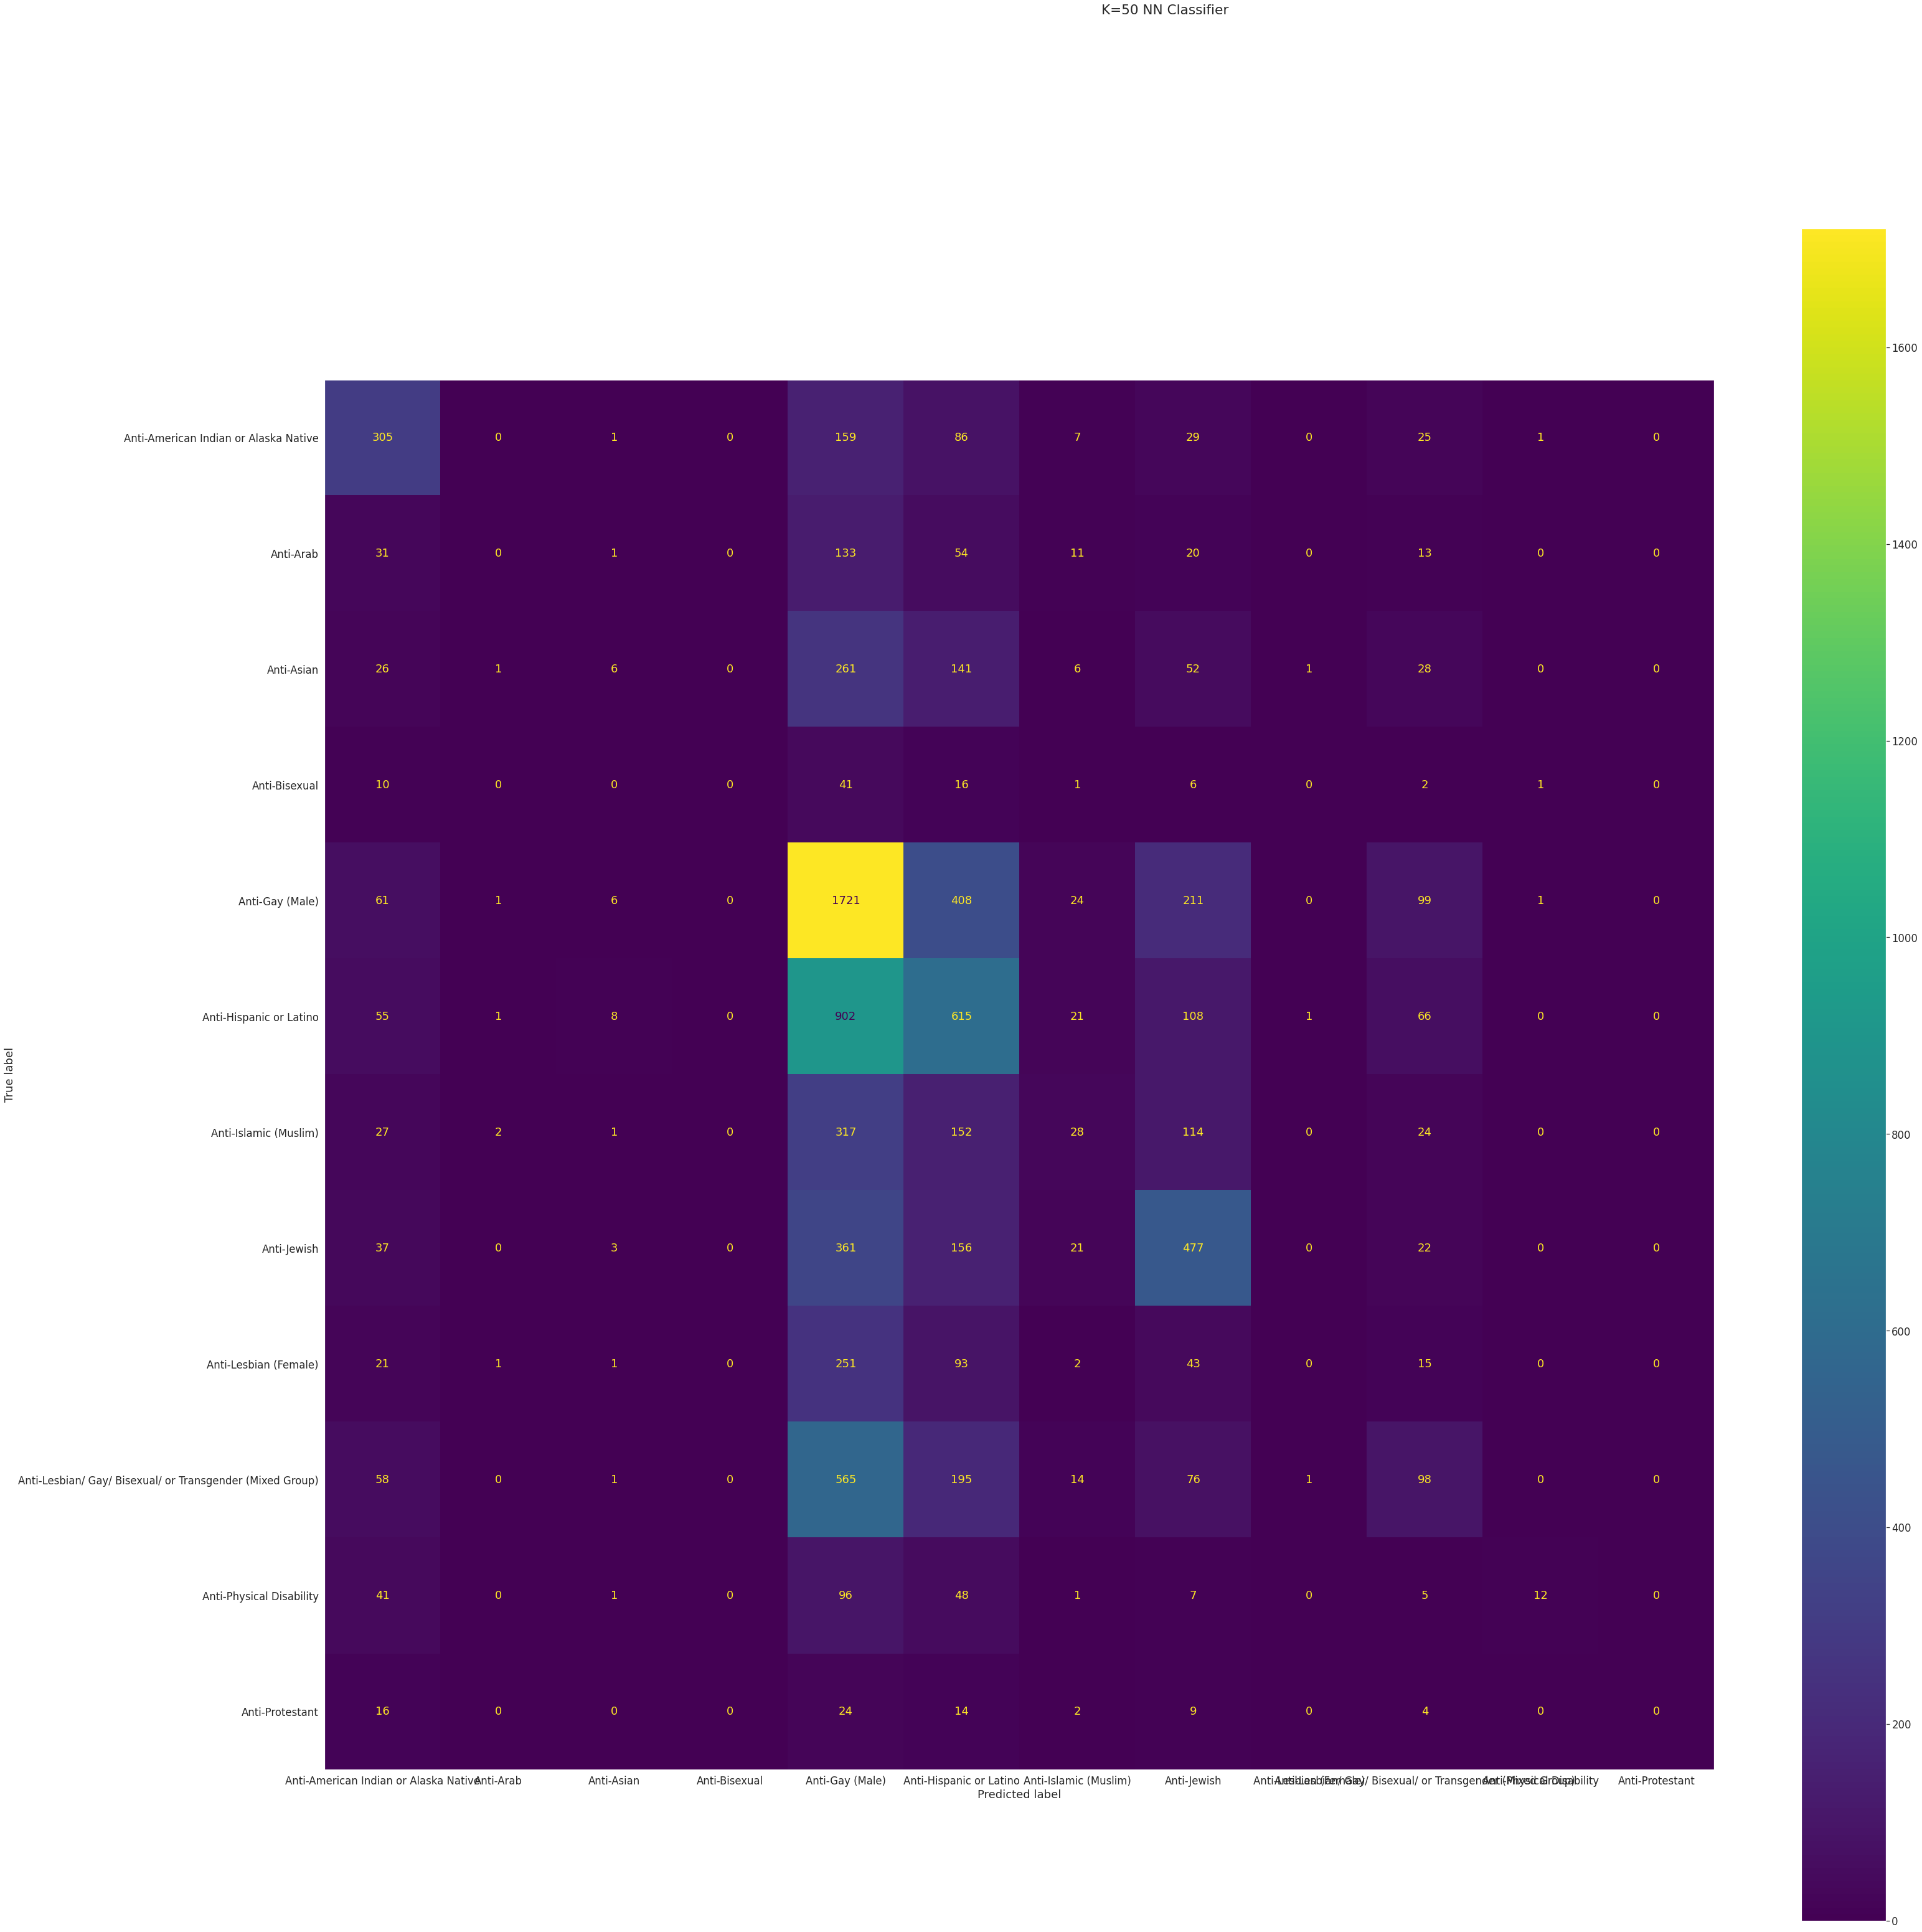

In [ ]:
# build the new confusion matrix based on the classifier's ability to predict
# new values
conf_hate_crime_filt = confusion_matrix(y_true = y_true, y_pred = y_pred)
conf_hate_crime_filt_disp = \
    ConfusionMatrixDisplay(conf_hate_crime_filt, 
                           display_labels = np.unique(y_true))

# plots the confusion matrix for the K=21 NN Classifier for 
# df_hate_crime_filtered
sns.set(font_scale=1.5)
conf_hate_crime_filt_disp.plot()
plt.suptitle('K=50 NN Classifier')
plt.gcf().set_size_inches(50, 50)
plt.grid(False)

In [ ]:
biases = conf_hate_crime_filt_disp.display_labels

# Computes the accuracy for each hate crime
df_hate_crime_accuracy = pd.DataFrame()
for i in range(len(biases) - 1):

    # For each bias, gather the number of hate crime that were motivated by the 
    # bias and correctly classified and the number that actually existed
    hate_crime_true = conf_hate_crime_filt[i, i]
    total_tested = sum(conf_hate_crime_filt[i])
    
    # Determines the accuracy for the hate crime's bias based on its predicted
    # and expected values
    accuracy = hate_crime_true / total_tested
    df_hate_crime_accuracy.loc[biases[i], 'Accuracy'] = accuracy

In [ ]:
# Display the accuracy score of the kNN-classifier
knn_classifier_accuracy = accuracy_score(y_true, y_pred)
knn_classifier_accuracy

0.3529921004220323

Admittedly, the classifier is not very accurate at predicting the bias of a hate crime. The classifier only correctly predicts a hate crime's bias about 36% of the time.

In [ ]:
df_hate_crime_accuracy

Accuracy
Anti-American Indian or Alaska Native               0.497553
Anti-Arab                                           0.000000
Anti-Asian                                          0.011494
Anti-Bisexual                                       0.000000
Anti-Gay (Male)                                     0.679700
Anti-Hispanic or Latino                             0.346089
Anti-Islamic (Muslim)                               0.042105
Anti-Jewish                                         0.442897
Anti-Lesbian (Female)                               0.000000
Anti-Lesbian/ Gay/ Bisexual/ or Transgender (Mi...  0.097222
Anti-Physical Disability                            0.056872

The classifier was able to accurately determine the bias of some hate crimes better than others. It was the best at classifying:
- Anti-gay (male) hate crimes (accuracy = 0.6737756714060031)

It has a hard time classifying:
- Anti-Arab hate crimes (accuracy = 0)
- Anti-bisexual hate crimes (accuracy = 0)
- Anti-lesbian (female) hate crimes (accuracy = 0)

Anti-Arab, anti-bisexual, and anti-lesbian all get most commonly confused with anti-gay crimes. This finding may suggest that the three aforementioned types of hate crimes may experience similar conditions. It makes sense for anti-bisexual and anti-lesbian (female) hate crimes to get confused with anti-gay (male) hate crimes since all of those hate crimes are directed toward the LGBTQ+ community. The reason for why anti-Arab hate crimes get confused with anti-gay hate crimes is unclear.

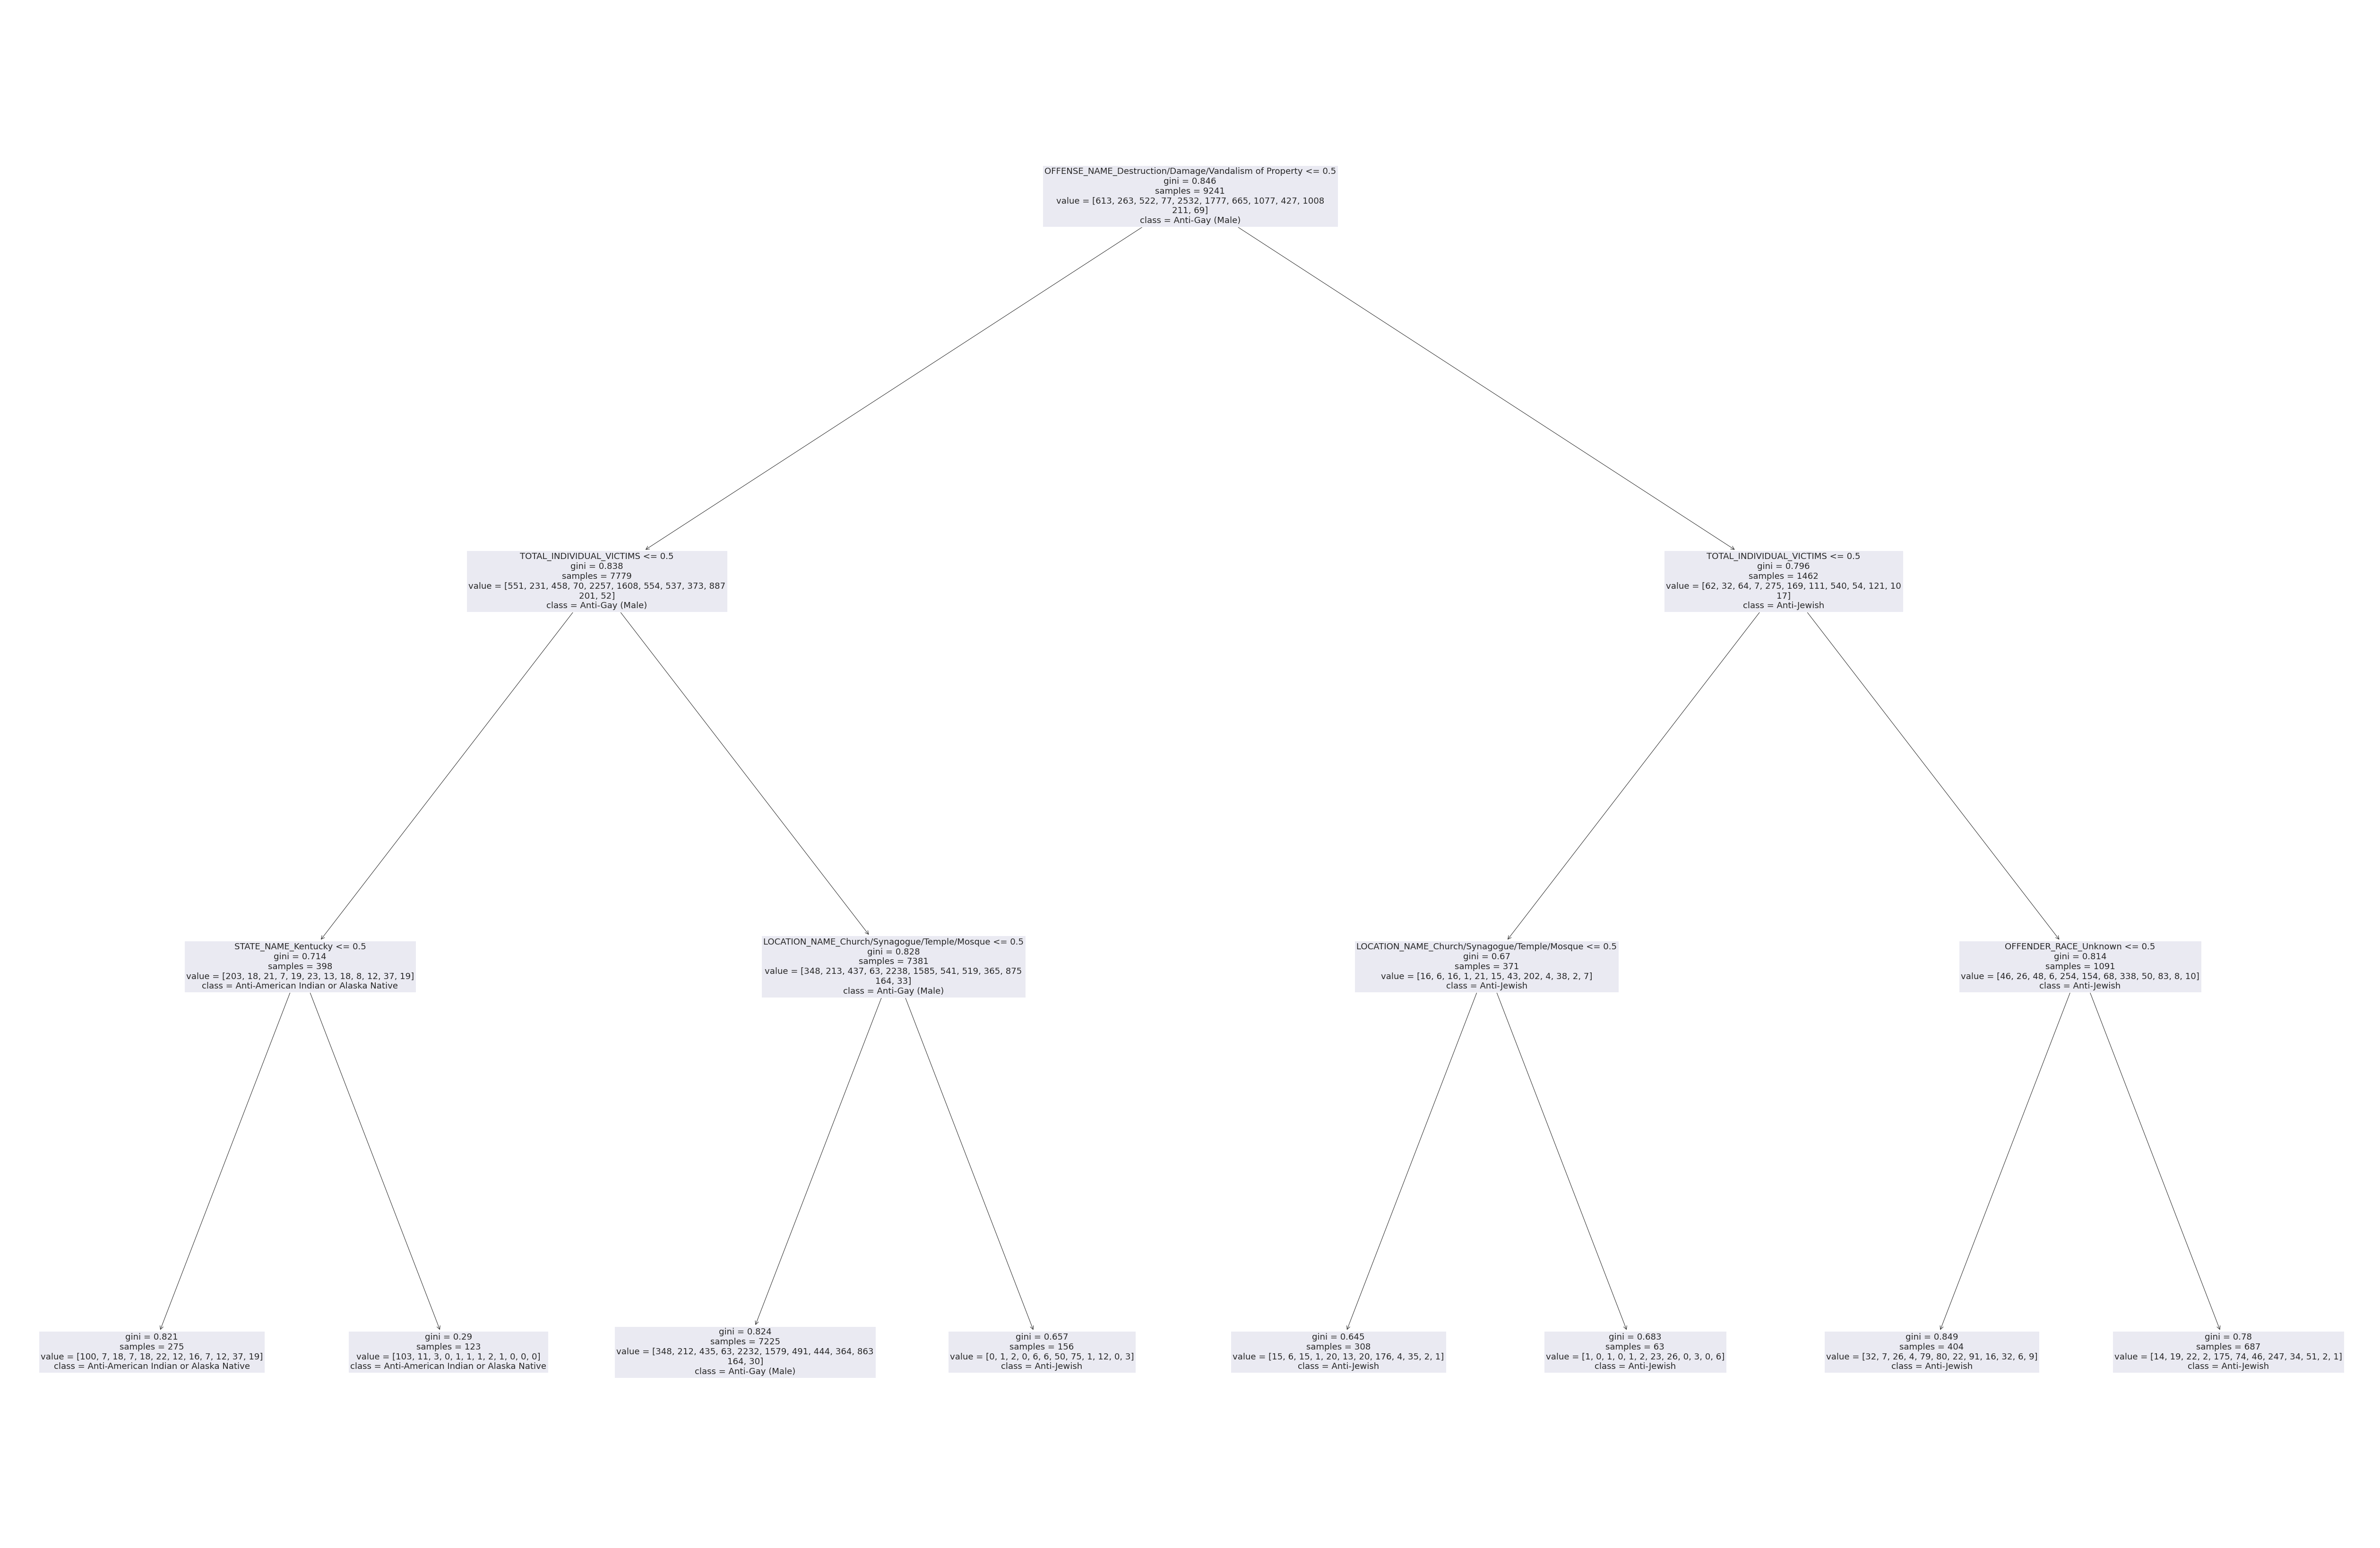

In [ ]:
# plots the decision tree for the hate crime classifier
dec_tree = train_dec_tree_hate_crimes(df_hate_crime_filtered, 
                                      max_depth = 3, 
                                      x_feat_list = x_feat_list,
                                      plot = True)

In [ ]:
# create a Random Forest Classifier with the hate crime data
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x, y_true)

RandomForestClassifier()

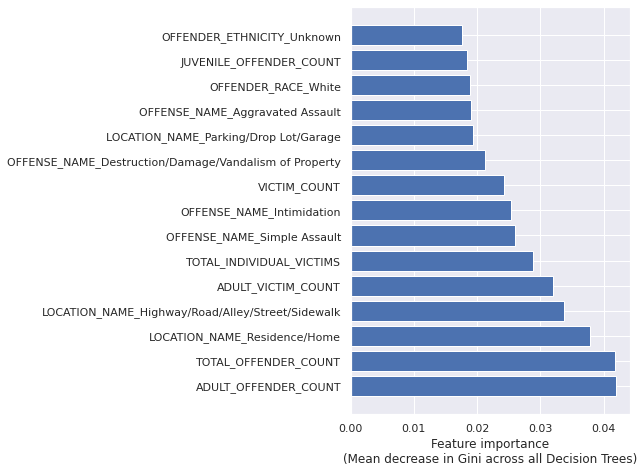

In [ ]:
# plot the importance of the top 15 most important features that the classifer
# uses to determine the bias that motivated a hate crime

sns.set()

plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit = 15)

According to the kNN-classifier, the total offender count is the most important feature in determining the possible bias that motivated a hate crime. More importantly, it seems that whether a hate crime takes place at a residence/home or a highway/road/alley/street/sidewalk is a critical determinant as well. These findings does not imply that an increase or decrease in total offender counts or hate crimes near a residence/home or highway/road/alley/street/sidewalk correlates with an increase or decrease in hate crimes motivated by a particular bias. Conversely, there may be distinct ranges of total offender counts or hate crimes at those locations that are popular among hate crimes targeted toward certain groups of human beings. Nevertheless, considering the low accuracy of our classifier for determining the bias of certain hate crimes, our findings should be taken with a grain of salt. Still, it may be a good idea for people to focus their efforts on limiting hate crimes on determining the types of locations that place people of a certain race, gender, sexual orientation, or other category at risk for an attack. Furthermore, there are more definite ways that we can help to reduce hate crime rates (as explained by points 8 through 10 in our summary).

Recommendations

Based on our research:

1) Hate crime rates are rapidly on the rise, even though they somewhat decreased between 2003 and 2015
  - Actions taken against hate crimes are becoming outdated
  - Organizations, governments, and other people wanting to lower hate crimes rate need to create newer plans that would allow hate crime rates to lower again

2) People of all kinds are negatively affected by hate crimes. Specifically, Asians, Blacks/African Americans, Hispanics/Latinos, and people with physical disabilities have experienced more hate crimes more rapidly recently
  - Greater efforts, whether by the government, community groups, or even the general public, to protect those groups should be enforced
  - Blacks and African Americans have experienced vastly more hate crimes than people of other groups
    - The Black Lives Matter is justifiable: Black people deserve more attention

3)  The state that is most prone to experiencing a hate crime incident is California
  - California experiences the most anti-Asian, anti-Black or African American, anti-LGBTQ+, anti-Protestant, and anti-Hispanic or Latino hate crimes
    - California state governors need to address the problem of hate crimes more seriously
  - Other states that have high hate crime rates include New Jersey, New York, and Massachusetts
  - More initiatives to lower hate crimes should be targeted toward these states
  - People may want to reconsider living in a state that is known for having high hate crime rates against people of their kind

4)  The prevalence of hate crimes toward a particular group is generally the same across the South, West, Northeast, and Midwest of the United States

5) Statutes need to be imposed in Arkansas, South Carolina, and Wyoming
  - Only 60% of states have mandates for the gathering of hate crime statistics
    - 20% of those states include data about sexual orientation in those mandates
  - 27 states and D.C. have statutes involving gender
  - Only 18 states have protections for one’s gender identity
  - Only D.C. and 3 states have statutes protecting the homeless

6) Certain characteristics of hate crimes are increasing nationwide and in the Southern, Northeastern, Western, and Midwestern United States. These characteristics should be considered in peoples’ plans to lower hate crimes:
  - Juvenile victim counts
  - Adult victim counts
  - Total offender counts
  - Adult offender counts
  - Juvenile offender counts
  - Victim counts
  - Individual victim cases
  - Multiple offense cases
  - Single offense cases
  - Multiple bias cases
  - Single bias cases
  - Cases with offenders of any race
  - Cases with offenders of any ethnicity

Hence, hate crimes involving various age ranges, biases, ethnicities, races, and victim counts are increasing

7) Our weak classifier suggests that to lower hate crimes of a certain bias, people should think about how to how to lower hate crimes around homes, residences, highways, roads, alleys, streets, and sidewalks
  - Regulations that make these areas safer could work to lower hate crimes in the United States

8) Even though the assertions made by our classifier are questionable, some factors that contribute to violence in the United States are undeniable. People should realize that the tensions within a community are not solely due to the individuals in that community. Socioeconomic factors fueled by privileged individuals are an overlooked reason for our nation’s rise in hate crimes, Governors, community groups, the general public, and other individuals can lower hate crimes by addressing these risk factors with communities prone to experiencing violence
  - Desperation and despair
  - The mob spirit
  - Jealousy
  - Substance and drug abuse
  - Corrupt justice system
  - Discrimination
  - False religion
  - Economic instability

9) [Risk factors for violence](https://www.cdc.gov/violenceprevention/youthviolence/riskprotectivefactors.html ):
  - Individual risk factors
    - Experience with violence victimization
    - Attention deficits, learning disorders, hyperactivity
    - Displays of early aggressive behavior in the past
    - Engagement with drugs, alcohol, or tobacco
    - Low IQ
    - Inability to control behaviors
    - Poor social cognitive or information-processing abilities
    - Abundant emotional distress
    - Treated for emotional issues in the past
    - Antisocial attitudes and beliefs
    - Encounters with arguments and harm in the family
  - Family risk factors
    - Authoritarian child-rearing attitudes
    - Hostile, passive, or inconsistent disciplinary actions
    - Minimal parental involvement
    - Weak emotional attachment to parents or guardians
    - Miniscule parental education and income
    - Parental criminality or abuse of substances
    - Bad family functioning
    - Insufficient overlooking and monitoring of children
  - Peer and social risk factors
    - Involvement with delinquent peers
    - Participation in gangs
    - Social rejection
    - Avoidance of conventional activities
    - Struggle with academics
    - Low drive to do well in school
    - Failing in school
  - Community risk factors
    - Scarce economic opportunities
    - An abundant number of poor residents within a community
    - Greater amounts of transiency
    - Greater amounts of family disruption
    - Rare community participation
    - Social disorganization

10) [Protective factors against violence](https://www.cdc.gov/violenceprevention/youthviolence/riskprotectivefactors.html ):
- Individual protective factors:
    - Disapproval toward deviance
    - High IQ
    - High GPA
    - Educational goals
    - Positive social orientation
    - Popularity
    - Strong social skills and competencies
    - Excels at realistic planning
    - Religion
- Family protective factors
    - Support from families or adults outside the family
    - Parents are approachable enough to discuss problems with
    - Parents seemingly hold high expectations about scholastic achievement
    - Parents and children engage in activities together
    - Involved parents (e.g. parent wakes their child up, is present when their child comes back from school, eats dinner with their child, gets their child ready for bed)
    - Parents and children participate in social activities together
    - Parents use constructive strategies for solving problems with their children
- Peer and social protective factors
    - Strong, close, and pro-socially oriented relationships with classmates
    - Heightened grit to do well in school
    - Profound bonds with non-deviant peers
    - Participation in peer groups against antisocial behavior
    - Engagement in pro-social activity
    - Experience in schools that enforce meticulous supervision, defined behavior rules, clear disciplinary actions, and involvement of teachers and parents




Works Cited

- 2022 Watch Tower Bible and Tract Society of Pennsylvania. (2012, August). Causes of Violence. JW.ORG. Retrieved November 8, 2022, from https://www.jw.org/en/library/magazines/g201208/Causes-of-Violence/
- "76-3-203.14. Victim targeting penalty enhancement -- Penalties". utah.gov. Retrieved July 10, 2021.
- "After Ugly Incident In Fargo, A Push For Hate Crime Laws". WCCO. Associated Press. 17 September 2017. Retrieved 9 July 2019.
- Alabama State Legislature. "Section 13A-5-13 - Crimes motivated by victim's race, color, religion, national origin, ethnicity, or physical or mental disability". Code of Alabama. Retrieved 19 June 2019.
- Allison, Natalie (14 February 2019). "Tennessee becomes first state in the South with hate crime law protecting transgender people". The Tennessean. Retrieved 10 July 2019.
- Arizona State Legislature. "Section 13-701. Sentence of imprisonment for felony; presentence report; aggravating and mitigating factors; consecutive terms of imprisonment; definition". Arizona Revised Statutes. Retrieved 22 June 2019. 15. Evidence that the defendant committed the crime out of malice toward a victim because of the victim's identity in a group listed in section 41-1750, subsection A, paragraph 3 or because of the defendant's perception of the victim's identity in a group listed in section 41-1750, subsection A, paragraph 3.
- Arizona State Legislature. "Section 41-1750. Central state repository; department of public safety; duties; funds; accounts; definitions". Arizona Revised Statutes. Retrieved 22 June 2019.
- AS 12.55.155
- California State Legislature (2004). "CHAPTER 1. Definitions [422.55 - 422.57]". Penal Code of California. Retrieved 22 June 2019.
- Centers for Disease Control and Prevention. (2020, March 2). Risk and Protective Factors. Centers for Disease Control and Prevention. Retrieved November 7, 2022, from https://www.cdc.gov/violenceprevention/youthviolence/riskprotectivefactors.html
- "Civil Rights Monitor". The Leadership Conference. The Leadership Conference Education Fund. Archived from the original on 2014-11-29. Retrieved 19 November 2014.
- Colorado General Assembly. "Section 18-9-121. Bias-motivated crimes". Colorado Revised Statutes. LexisNexis. Retrieved 22 June 2019.
- Connecticut General Assembly. "Chapter 952 - Penal Code: Offenses". General Statutes of Connecticut. Retrieved 22 June 2019. Sec. 53a-181j. Intimidation based on bigotry or bias in the first degree: Class C felony [infra]
- Cornell University. (n.d.). 18 U.S. Code § 241 - Conspiracy against rights. Legal Information Institute. Retrieved November 7, 2022, from https://www.law.cornell.edu/uscode/text/18/241
- Cornell University. (n.d.). 18 U.S. Code § 247 - Damage to religious property; obstruction of persons in the free exercise of religious beliefs. Legal Information Institute. Retrieved November 7, 2022, from https://www.law.cornell.edu/uscode/text/18/247
- Council of the District of Columbia. "Chapter 37. Bias-Related Crime". Code of the District of Columbia. Retrieved 22 June 2019.
- Criminal Civil Rights Laws. United States Attorney's Office - District of South Carolina. (2017, January 27). Retrieved November 7, 2022, from https://www.justice.gov/usao-sc/criminal-civil-rights-laws
- Delaware General Assembly. "TITLE 11 - CHAPTER 5. SPECIFIC OFFENSES - Subchapter VII. Offenses Against Public Health, Order and Decency". Delaware Code Online. Retrieved 22 June 2019. § 1304 Hate crimes; class A misdemeanor, class G felony, class F felony, class E felony, class D felony, class C felony, class B felony, class A felony. [infra]
- "Federal Civil Rights Statutes". Federal Bureau of Investigation.
- "Federally Protected Activities". United States Department of Justice, Civil Rights Division. Archived from the original on 1 January 2011.
- Florida Legislature. "877.19 Hate Crimes Reporting Act.—". 2018 Florida Statutes. Retrieved 22 June 2019.
- "H.R. 3525 (104th): Church Arson Prevention Act of 1996". GovTrack.us. Civic Impulse, LLC. Retrieved 13 November 2014.
- "Hate Crime Laws". LGBT Map. Retrieved April 1, 2021.
- Hate Crime Laws. The United States Department of Justice. (2019, March 7). Retrieved November 7, 2022, from https://www.justice.gov/crt/hate-crime-laws
- "Hate Crime Sentencing Act". Anti-Defamation League. Archived from the original on 7 July 2009. Retrieved 10 December 2009.
- "Hate crime statistics 1996" (PDF). CJIS. Archived from the original (PDF) on 2007-07-09. Retrieved 10 December 2009.
- Hate Crime Statistics Annual Reports. Federal Bureau of Investigation Crime Data Explorer. (2021, August 30). Retrieved November 7, 2022, from https://crime-data-explorer.fr.cloud.gov/pages/downloads
- Hawaii Legislature. "§846-51 Definitions". 2018 Hawaii Revised Statutes. Retrieved 4 July 2019.
- HRC Foundation. (n.d.). Hate Crimes Timeline. The Human Rights Campaign. Retrieved November 7, 2022, from https://www.hrc.org/resources/hate-crimes-timeline
- Idaho Legislature. "Section 18-7901. PURPOSE". Idaho Statutes. Retrieved 4 July 2019.
- Illinois General Assembly. "Article 12 - Subdivision 15. Intimidation". Retrieved 4 July 2019. Sec. 12-7.1. Hate crime. [infra]
- Indiana General Assembly. "IC 10-13-3-1 "Bias crime"". Indiana Code. Retrieved 4 July 2019.
- Iowa Legislature. "CHAPTER 729A - VIOLATION OF INDIVIDUAL RIGHTS — HATE CRIMES". Iowa Code. Retrieved 4 July 2019.
- Kansas State Legislature. "21-6815. Imposition of presumptive sentence; jury requirements; departure sentencing; substantial and compelling reasons for departure; mitigating and aggravating factors". Kansas Statutes. Retrieved 4 July 2019. (C) The offense was motivated entirely or in part by the race, color, religion, ethnicity, national origin or sexual orientation of the victim or the offense was motivated by the defendant's belief or perception, entirely or in part, of the race, color, religion, ethnicity, national origin or sexual orientation of the victim whether or not the defendant's belief or perception was correct.
- Kentucky State Legislature. "532.031 Hate crimes -- Finding – Effect -- Definitions" (PDF). Kentucky Revised Statutes. Retrieved 8 July 2019.
- Library of Congress. (n.d.). S.937 - 117th Congress (2021-2022): Covid-19 hate crimes act. Congress.gov. Retrieved November 8, 2022, from https://www.congress.gov/bill/117th-congress/senate-bill/937
- Louisiana State Legislature. "§107.2. Hate crimes". Louisiana Revised Statutes. Retrieved 8 July 2019.
- Maine State Legislature. "Title 17-A, §1151. Purposes". Maine Revised Statutes. Retrieved 8 July 2019.
- Maryland General Assembly. "Criminal Law" (PDF). Maryland Code. p. 425. Retrieved 8 July 2019. §10–304. [infra]
- Massachusetts General Court. "Part I, Title II, Chapter 22C, Section 32: Definitions applicable to Secs. 33 to 35". Massachusetts General Laws. Retrieved 8 July 2019.
- "Michigan Legislature - Section 750.147b". www.legislature.mi.gov. Retrieved 2021-02-04.
- Minnesota Legislature. "611A.79 CIVIL DAMAGES FOR BIAS OFFENSES". 2018 Minnesota Statutes. Retrieved 8 July 2019.
- Mississippi Legislature. "§ 99-19-301. Penalties subject to enhancement; definitions". Mississippi Code of 1972. LexisNexis. Retrieved 8 July 2019.
- Missouri Legislature. "557.035. Hate offenses — provides enhanced penalties for motivational factors in certain offenses". Revised Statutes of Missouri. Missouri Reviser of Statutes. Retrieved 8 July 2019.
- Montana Legislature. "45-5-221. Malicious intimidation or harassment relating to civil or human rights -- penalty". Montana Code Annotated 2017. Retrieved 8 July 2019.
- Nebraska Legislature. "28-111. Enhanced penalty; enumerated offenses". Nebraska Revised Statutes. Retrieved 9 July 2019.
- Nevada Legislature. "Title 15 - Crime and Punishments: Chapter 193 - General Provisions". Nevada Revised Statutes. Retrieved 9 July 2019. NRS 193.1675  Additional penalty: Commission of crime because of certain actual or perceived characteristics of victim. [infra]
- New Hampshire General Court. "651:6 Extended Term of Imprisonment". New Hampshire Statutes. Retrieved 9 July 2019.
- New Jersey Legislature. "2C:16-1 Bias intimidation". New Jersey Legislative Statutes. Archived from the original on 8 March 2021. Retrieved 9 July 2019.
- New Mexico Legislature. "31-18B-3. Hate crimes; noncapital felonies, misdemeanors or petty misdemeanors committed because of the victim's actual or perceived race, religion, color, national origin, ancestry, age, disability, gender, sexual orientation or gender identity; alteration of basic sentence". NMOneSource.com. New Mexico Compilation Commission. Retrieved 9 July 2019.
- New York State Legislature. Penal Law § 485.00 Consolidated Laws of New York.
- North Carolina General Assembly. "§ 15A-1340.16. Aggravated and mitigated sentences" (PDF). North Carolina General Statutes. Retrieved 9 July 2019. (17) The offense for which the defendant stands convicted was committed against a victim because of the victim's race, color, religion, nationality, or country of origin.
- North Dakota Legislature. "CHAPTER 12.1-14 - OFFICIAL OPPRESSION - ELECTIONS - CIVIL RIGHTS" (PDF). North Dakota Century Code. Retrieved 9 July 2019.
- Ohio Legislature. "2929.12 Seriousness of crime and recidivism factors". Ohio Revised Code. Retrieved 9 July 2019.
- Oklahoma Legislature. "Title 21. Crimes and Punishments" (RTF). Oklahoma Statutes. p. 227. Retrieved 9 July 2019.
- Pennsylvania General Assembly. "Title 18 - Crimes and Offenses" (PDF). Pennsylvania Consolidated Statutes. p. 95. Retrieved 9 July 2019.
- Rhode Island General Assembly. "§ 12-19-38. Hate Crimes Sentencing Act". Rhode Island General Laws. Retrieved 9 July 2019.
- "S. 1890 (104th): Church Arson Prevention Act of 1996". GovTrack.us. Civic Impulse, LLC. Retrieved 13 November 2014.
- Section 1, Chapter No. 271 of 2019 (PDF). Washington State Legislature. p. 1. Retrieved 10 July 2019.
- Section 1, Senate Bill No. 577 of 2019 (PDF). Oregon State Legislature. Retrieved 9 July 2019.
- Senate Bill No. 198 of 2019. Indiana General Assembly. p. 2. Retrieved 4 July 2019.
- Slotkin, Jason (June 25, 2020). "After Ahmaud Arbery's Killing, Georgia Governor Signs Hate Crimes Legislation". NPR. Retrieved April 1, 2021.
- South Dakota Legislature. "Chapter 22-19B - Hate Crimes". South Dakota Codified Laws. Retrieved 10 July 2019.
- Sprayregen, Molly (March 6, 2020). "Virginia's Governor Just Signed 3 Pro-LGBTQ Bills". LGBTQ Nation. Retrieved April 1, 2021.
- Tennessee General Assembly. "§ 40-35-114. Enhancement factors". Tennessee Code Unannotated. LexisNexis. Retrieved 10 July 2019. (17) The defendant intentionally selected the person against whom the crime was committed or selected the property that was damaged or otherwise affected by the crime, in whole or in part, because of the defendant's belief or perception regarding the race, religion, color, disability, sexual orientation, national origin, ancestry or gender of that person or the owner or occupant of that property; however, this subdivision (17) should not be construed to permit the enhancement of a sexual offense on the basis of gender selection alone;
- Texas Legislature. "Chapter 42. Judgment and Sentence". Texas Code of Criminal Procedure. Retrieved 10 July 2019. Art. 42.014. FINDING THAT OFFENSE WAS COMMITTED BECAUSE OF BIAS OR PREJUDICE. [infra]
- The United States Department of Justice. (2020, January 16). 38. "Juvenile" Defined. The United States Department of Justice Archives. Retrieved November 7, 2022, from 
- U.S. Department of Justice. (2022, October 14). Laws and Policies. The United States Department of Justice. Retrieved November 7, 2022, from https://www.justice.gov/hatecrimes/laws-and-policies#
- Utah State Legislature. "76-3-203.3. Penalty for hate crimes -- Civil rights violation". Utah Code. Retrieved 10 July 2019.
- Van Slooten, Philip (March 5, 2020). "VA. Governor Signs Three LGBTQ Bills into Law". Washington Blade. Retrieved April 1, 2021.
- Vermont General Assembly. "Title 13: Crimes And Criminal Procedure - Chapter 33: Injunctions Against Hate-motivated Crimes". Vermont Statutes Online. Retrieved 10 July 2019.
- Virginia General Assembly. "§ 52-8.5. Reporting hate crimes". Code of Virginia. Retrieved 10 July 2019.
- Washington State Legislature. "9A.36.078: Malicious harassment—Finding". Revised Code of Washington. Retrieved 10 July 2019.
- Wisconsin Legislature. "939.645 Penalty; crimes committed against certain people or property". Wisconsin Statutes. Retrieved 10 July 2019.
- WVC §61-6-21
